In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pyFAI.detectors as dets
import pyFAI

from pathlib import Path

import glob

from importlib import reload
from dataproc.operations import hitp

plt.rcParams["figure.figsize"]=(10, 8)

In [78]:
reload(hitp)

<module 'dataproc.operations.hitp' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/dataproc/operations/hitp.py'>

In [375]:
df = pd.read_csv("YijinXRD.dat", sep = '\t')
qq = df.iloc[:, 0]

patterns = df.iloc[:, 2:]
patterns = patterns.values.T
for i in range(len(patterns)):
    patterns[i] = patterns[i] - i * 1000
    
x = np.arange(len(patterns[0])) + 1
y = patterns[0]
    
boundaries = hitp.bayesian_block_finder(x, y)

numBlocks: 352, dataPts/Block: 1.6988636363636365


In [3]:
import pdb

In [276]:
import time
import json
from pathlib import Path
import re
import pyFAI.detectors as dets
import numpy as np


from dataproc.operations.utils import single_select, folder_select
from scipy.ndimage.filters import gaussian_filter as gf

template = ''
configPath = "workflows/alanConfig"

# Configuration setup
# Grab configs
print(configPath)
with open(configPath) as jp:
    cfg = json.load(jp)
cfg['fitInfo']['blockBounds'] = boundaries


def workflow(y, boundaries, downsample_int = 10, noise_estimate = None, background = None,
             **kwargs):
    """
    kwargs are passed to hitp.fit_peak
    """

    # Fill out experimental information
    expInfo = {}


    expInfo['blockBounds'] = cfg['fitInfo']['blockBounds']

    print('Experimental Info used: \n')
    print(expInfo)

    # Pull out Fit info
    fitInfo = cfg['fitInfo']

    # Start processing loop =======================================================
    run_enable = True
    
    # restrict range?
    subx, suby = np.arange(len(y)) + 1, y
    #pdb.set_trace()
    
    if background is None:
        # Background subtract/move to zero
        suby = suby - np.min(suby)
        subx, suby = hitp.bkgd_sub(subx, suby, downsample_int)
    else:
        suby = y - background
        if suby.min() < 0:
            print('negative values in background-subtracted pattern. taking absolute value.')
            suby = suby - suby.min()

    # segment rangeinto two...
    xList = []
    yList = []
    noiseList = []
    paramsList = []
    bnds = expInfo['blockBounds']
    for leftBnd in range(len(bnds) - 1): # indexes
        selector = np.where((subx >= bnds[leftBnd]) & (subx < bnds[leftBnd + 1]))
        xList.append(subx[selector])
        yList.append(suby[selector])
        if noise_estimate is not None:
            noiseList.append(noise_estimate[selector] + 1e-9) 
        else:
            noiseList.append(None)
    for i, (xbit, ybit, noisebit) in enumerate(zip(xList, yList, noiseList)):
        # Restrict range and fit peaks
        curveParams, derivedParams = hitp.fit_peak(xbit, ybit,
                            peakShape=fitInfo['peakShape'],
                            fitMode=fitInfo['fitMode'],
                            numCurves=fitInfo['numCurves'],
                            noise_estimate = noisebit,
                                             **kwargs)
        print(f'    ----Saving data for block between {np.min(xbit):.2f} - {np.max(xbit):.2f}')
        # output/saving of blocks
        hitp.save_dict(curveParams, cfg['exportPath'], template + f'_block{i}_curve')
        hitp.save_dict(derivedParams, cfg['exportPath'], template + f'_block{i}_derived')
        hitp.save_curve_fit(xbit, ybit, curveParams, cfg['exportPath'], 
                        template + f'_block{i}', peakShape=fitInfo['peakShape'])
        paramsList.append(derivedParams)
    return suby, paramsList

def fit_curves(y, **kwargs):
    boundaries = hitp.bayesian_block_finder(x, gf(y, 1.5))
    #boundaries = [b for b in boundaries if b >= boundaries_min and b <= boundaries_max]
    print(boundaries)
    cfg['fitInfo']['blockBounds'] = boundaries
    suby, derivedParams = workflow(y, boundaries, **kwargs)
    return suby, derivedParams

def curvefit_2d(patterns, background = None, noise_estimate = None, **kwargs):
    def _background(i):
        if background is not None:
            return background[i]
        return None
    def _noise_estimate(i):
        if noise_estimate is not None:
            return noise_estimate[i]
        return None
    outputs = [fit_curves(y, background = _background(i),
                                 noise_estimate = _noise_estimate(i), **kwargs)
                      for i, y in enumerate(patterns)]
    arrays = [elt[0] for elt in outputs]
    params = [elt[1] for elt in outputs]
    return np.vstack(arrays), params

workflows/alanConfig


In [6]:
hitp.bayesian_block_finder(x, gf(patterns[20], 1.5))

numBlocks: 392, dataPts/Block: 1.5255102040816326


array([  0.,  32., 126., 171., 227., 260., 301., 347., 406., 425., 445.,
       491., 533., 597.])

In [15]:
i = 33

y3 = fit_curves(patterns[i])

numBlocks: 412, dataPts/Block: 1.4514563106796117
[  0.  79. 124. 150. 178. 190. 215. 250. 295. 315. 354. 386. 428. 460.
 481. 495. 509. 534. 558. 578. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  79., 124., 150., 178., 190., 215., 250., 295., 315., 354.,
       386., 428., 460., 481., 495., 509., 534., 558., 578., 597.])}
Peak at 70, start iteration with error = 0.6967618746170375
Peak at 70, iteration 0: error = 0.3112924796404795
Peak at 70, iteration 1: error = 0.05352889846870834
Peak at 70, iteration 2: error = 0.05061529640836045
    ----Saving data for block between 1.00 - 78.00
Peak at 81, start iteration with error = 0.2687681791448506
Peak at 81, iteration 0: error = 0.7266628965444057
Peak at 81, iteration 1: error = 0.009561001698481692
Peak at 81, iteration 2: error = 0.0069264497933581
    ----Saving data for block between 79.00 - 123.00
Peak at 134, start iteration with error = 0.2933373609291151
Peak at 134, iteration 0: error = 0.688458434515989
Peak 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 481.00 - 494.00
Peak at 499, start iteration with error = 0.425517386893646
Peak at 499, iteration 0: error = 0.5699762268002508
Peak at 499, iteration 1: error = 0.01503499425180893
Peak at 499, iteration 2: error = 0.011721380254876675


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 495.00 - 508.00
Peak at 526, start iteration with error = 0.2752900918386989
Peak at 526, iteration 0: error = 0.7205723345003803
Peak at 526, iteration 1: error = 0.02647386410167709
Peak at 526, iteration 2: error = 0.015908219288365274
    ----Saving data for block between 509.00 - 533.00
Peak at 534, start iteration with error = 0.25983185089042976
Peak at 534, iteration 0: error = 0.7278541945281239
Peak at 534, iteration 1: error = 0.010698931187932803
Peak at 534, iteration 2: error = 0.007962399080997837
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 534.00 - 557.00
Peak at 573, start iteration with error = 0.21659962203842426
Peak at 573, iteration 0: error = 0.7746776422571334
Peak at 573, iteration 1: error = 0.03009621956332542
Peak at 573, iteration 2: error = 0.023018622679099522
    ----Saving data for block between 558.00 - 577.00
Peak at 591, start iterati

In [5]:
plt.rcParams["figure.figsize"]=(10, 8)

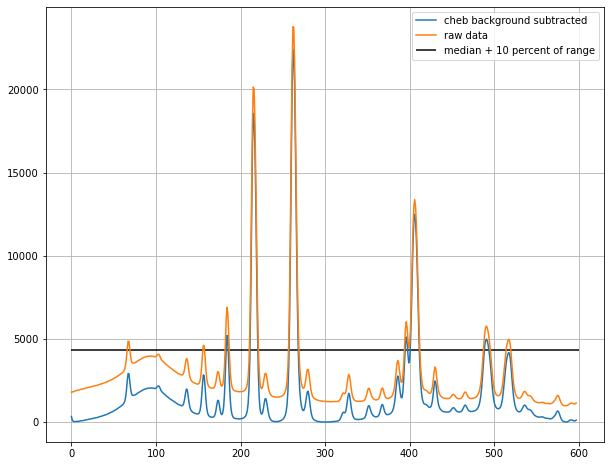

In [33]:
plt.plot(y3, label = 'cheb background subtracted')
plt.plot(patterns[i], label  = 'raw data')
plt.hlines(np.percentile(patterns[i], 50) + 0.1 * (patterns[i].max() - patterns[i].min()), 0, 600, 'k',
           label = 'median + 10 percent of range')
plt.legend()
plt.grid()

In [45]:
y3 = fit_curves(patterns[i], downsample_int = 50)

numBlocks: 414, dataPts/Block: 1.4444444444444444
[  0. 128. 151. 189. 224. 255. 298. 339. 365. 405. 438. 477. 524. 551.
 583. 597.]
Experimental Info used: 

{'blockBounds': array([  0., 128., 151., 189., 224., 255., 298., 339., 365., 405., 438.,
       477., 524., 551., 583., 597.])}
Peak at 73, start iteration with error = 0.8131252195519438
Peak at 73, iteration 0: error = 3.2724629672571846
Peak at 73, iteration 1: error = 0.2706696171606327
Peak at 73, iteration 2: error = 0.270669617426323
    ----Saving data for block between 1.00 - 127.00
Peak at 135, start iteration with error = 0.7212719280967178
Peak at 135, iteration 0: error = 0.2023706877655001
Peak at 135, iteration 1: error = 0.09187521663104968
Peak at 135, iteration 2: error = 0.12481627024941336
    ----Saving data for block between 128.00 - 150.00
Peak at 170, start iteration with error = 0.7273658383882524
Peak at 170, iteration 0: error = 0.20370045286649968
Peak at 170, iteration 1: error = 0.1331344753787456
Pe

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 583.00 - 596.00


In [46]:
y4 = fit_curves(patterns[i], downsample_int = 50)

numBlocks: 414, dataPts/Block: 1.4444444444444444
[  0. 128. 151. 189. 224. 255. 298. 339. 365. 405. 438. 477. 524. 551.
 583. 597.]
Experimental Info used: 

{'blockBounds': array([  0., 128., 151., 189., 224., 255., 298., 339., 365., 405., 438.,
       477., 524., 551., 583., 597.])}
Peak at 73, start iteration with error = 0.9336557257800359
Peak at 73, iteration 0: error = 5.1461082672077305
Peak at 73, iteration 1: error = 0.6439893688207164
Peak at 73, iteration 2: error = 0.6439894510871301
    ----Saving data for block between 1.00 - 127.00
Peak at 135, start iteration with error = 0.33941583285295485
Peak at 135, iteration 0: error = 0.6495668416283141
Peak at 135, iteration 1: error = 0.026552964605618363
Peak at 135, iteration 2: error = 0.02400662258377597
    ----Saving data for block between 128.00 - 150.00
Peak at 170, start iteration with error = 0.21847419815303698
Peak at 170, iteration 0: error = 0.7798414198244922
Peak at 170, iteration 1: error = 0.0094484686939404

In [50]:
pwd

'/Users/ollie/Documents/SLAC/xrd_clustering/notebooks'

In [49]:
cfg['exportPath']

'fitoutput/'

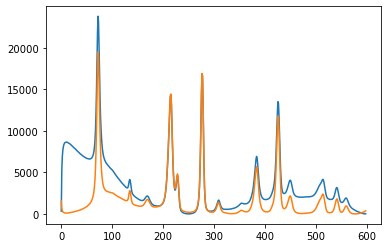

In [37]:
plt.plot(y3)
plt.plot(y4)

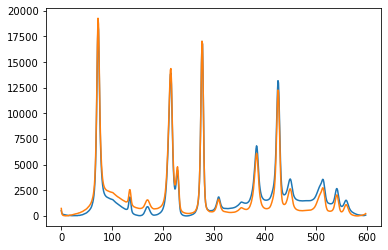

In [47]:
plt.plot(y3)
plt.plot(y4)

In [42]:
len(x)

598

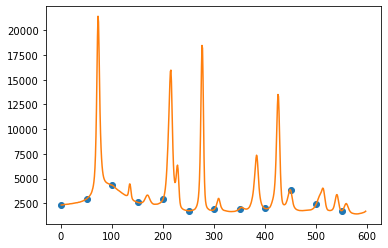

In [44]:
ds = 50
plt.plot(x[::ds], patterns[i][::ds], 'o')
plt.plot(x, patterns[i])

In [29]:
%matplotlib inline

In [21]:
bgsubbed = np.vstack([fit_curves(y) for y in patterns])

numBlocks: 358, dataPts/Block: 1.670391061452514
[  0.  35. 127. 183. 230. 263. 297. 342. 408. 430. 448. 501. 512. 539.
 567. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  35., 127., 183., 230., 263., 297., 342., 408., 430., 448.,
       501., 512., 539., 567., 597.])}
Peak at 6, start iteration with error = 0.8744876110049672
Peak at 6, iteration 0: error = 0.3360550172241699
Peak at 6, iteration 1: error = 0.29478581198305304
Peak at 6, iteration 2: error = 0.27326844264947986
    ----Saving data for block between 1.00 - 34.00
Peak at 71, start iteration with error = 0.7904498272201014
Peak at 71, iteration 0: error = 0.7563760960680689
Peak at 71, iteration 1: error = 0.06056021557924004
Peak at 71, iteration 2: error = 0.06056021557597892
    ----Saving data for block between 35.00 - 126.00
Peak at 132, start iteration with error = 0.542922858290663
Peak at 132, iteration 0: error = 0.4393858171528767
Peak at 132, iteration 1: error = 0.046455246948087885
Peak at 13

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 501.00 - 511.00
Peak at 523, start iteration with error = 0.4412642239353948
Peak at 523, iteration 0: error = 0.5264316851004637
Peak at 523, iteration 1: error = 0.06758496536088339
Peak at 523, iteration 2: error = 0.05663312064883592
    ----Saving data for block between 512.00 - 538.00
Peak at 555, start iteration with error = 0.4715860134471545
Peak at 555, iteration 0: error = 0.5185359829695014
Peak at 555, iteration 1: error = 0.05467249404483868
Peak at 555, iteration 2: error = 0.030391000927953195
    ----Saving data for block between 539.00 - 566.00
Peak at 573, start iteration with error = 0.8571907760268471
Peak at 573, iteration 0: error = 0.1389149324233521
Peak at 573, iteration 1: error = 0.2017497474438672
Peak at 573, iteration 2: error = 0.24373936603188262
    ----Saving data for block between 567.00 - 596.00
numBlocks: 358, dataPts/Block: 1.670391061452514
[  0.  35. 127. 186. 230. 263. 297. 356. 408. 430. 448. 501. 511. 539

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 501.00 - 510.00
Peak at 523, start iteration with error = 0.37299116026538787
Peak at 523, iteration 0: error = 0.6090644437262444
Peak at 523, iteration 1: error = 0.06454078764083507
Peak at 523, iteration 2: error = 0.04738570619886323
    ----Saving data for block between 511.00 - 538.00
Peak at 554, start iteration with error = 0.34032842122052304
Peak at 554, iteration 0: error = 0.6528513544472726
Peak at 554, iteration 1: error = 0.04515998774782589
Peak at 554, iteration 2: error = 0.024840625428730376
    ----Saving data for block between 539.00 - 563.00
Peak at 572, start iteration with error = 0.8411134627229001
Peak at 572, iteration 0: error = 0.19586252952153105
Peak at 572, iteration 1: error = 0.18161118903908388
Peak at 572, iteration 2: error = 0.2301307692164994
    ----Saving data for block between 564.00 - 596.00
numBlocks: 364, dataPts/Block: 1.6428571428571428
[  0.  35. 127. 183. 230. 263. 303. 340. 408. 431. 448. 488. 514.

Peak at 461, start iteration with error = 0.34654450868926645
Peak at 461, iteration 0: error = 0.6376743120517538
Peak at 461, iteration 1: error = 0.016189403619223365
Peak at 461, iteration 2: error = 0.01569232763341317
    ----Saving data for block between 448.00 - 487.00
Peak at 510, start iteration with error = 0.12136790986804954
Peak at 510, iteration 0: error = 0.8773026321514783
Peak at 510, iteration 1: error = 0.004907379473262704
Peak at 510, iteration 2: error = 0.0037471702787619156
    ----Saving data for block between 488.00 - 513.00
Peak at 523, start iteration with error = 0.37534928765873293
Peak at 523, iteration 0: error = 0.6065226800794886
Peak at 523, iteration 1: error = 0.04989361296007392
Peak at 523, iteration 2: error = 0.05103227714295234
    ----Saving data for block between 514.00 - 543.00
Peak at 554, start iteration with error = 0.47822624083422144
Peak at 554, iteration 0: error = 0.5172681607923407
Peak at 554, iteration 1: error = 0.02788088616883

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 500.00 - 510.00
Peak at 522, start iteration with error = 0.42156449224447157
Peak at 522, iteration 0: error = 0.5376175126412431
Peak at 522, iteration 1: error = 0.05763613954303362
Peak at 522, iteration 2: error = 0.048152126367340786
    ----Saving data for block between 511.00 - 543.00
Peak at 554, start iteration with error = 0.5242591241057147
Peak at 554, iteration 0: error = 0.47128506666858366
Peak at 554, iteration 1: error = 0.03288179913141158
Peak at 554, iteration 2: error = 0.021476440858572553
    ----Saving data for block between 544.00 - 566.00
Peak at 572, start iteration with error = 0.921238584216043
Peak at 572, iteration 0: error = 0.32390768489646277
Peak at 572, iteration 1: error = 0.20156405459164375
Peak at 572, iteration 2: error = 0.1425179724749099
    ----Saving data for block between 567.00 - 596.00
numBlocks: 363, dataPts/Block: 1.6473829201101928
[  0.  35. 129. 196. 229. 262. 297. 339. 397. 430. 447. 500. 510.

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 500.00 - 509.00
Peak at 522, start iteration with error = 0.41153743540264626
Peak at 522, iteration 0: error = 0.5545001776952491
Peak at 522, iteration 1: error = 0.06461923643581872
Peak at 522, iteration 2: error = 0.04046004145602228
    ----Saving data for block between 510.00 - 537.00
Peak at 554, start iteration with error = 0.34693446853228005
Peak at 554, iteration 0: error = 0.6496455173995501
Peak at 554, iteration 1: error = 0.025429853256432766
Peak at 554, iteration 2: error = 0.012663802859596163
    ----Saving data for block between 538.00 - 562.00
Peak at 572, start iteration with error = 0.7972137677831049
Peak at 572, iteration 0: error = 0.2768055011469168
Peak at 572, iteration 1: error = 0.4522749651279532
Peak at 572, iteration 2: error = 0.547078450002038
    ----Saving data for block between 563.00 - 596.00
numBlocks: 359, dataPts/Block: 1.6657381615598885
[  0.  35. 130. 181. 229. 262. 297. 339. 407. 429. 447. 499. 510. 5

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 522, start iteration with error = 0.3727469038964142
Peak at 522, iteration 0: error = 0.607814239834606
Peak at 522, iteration 1: error = 0.0566990615045349
Peak at 522, iteration 2: error = 0.0566990614847933
    ----Saving data for block between 510.00 - 542.00
Peak at 553, start iteration with error = 0.48616943073224483
Peak at 553, iteration 0: error = 0.5074149953563832
Peak at 553, iteration 1: error = 0.044231675092145394
Peak at 553, iteration 2: error = 0.025764435928521373
    ----Saving data for block between 543.00 - 566.00
Peak at 571, start iteration with error = 0.8505836666469234
Peak at 571, iteration 0: error = 0.17393051226057424
Peak at 571, iteration 1: error = 0.2057931863364619
Peak at 571, iteration 2: error = 0.2004119807190266
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 567.00 - 596.00
numBlocks: 366, dataPts/Block: 1.633879781420765
[  0.  35. 130. 182. 228. 262. 302. 35

    ----Saving data for block between 429.00 - 446.00
Peak at 460, start iteration with error = 0.555307250699221
Peak at 460, iteration 0: error = 0.34666455250744893
Peak at 460, iteration 1: error = 0.03442392792578542
Peak at 460, iteration 2: error = 0.03597991639213402
    ----Saving data for block between 447.00 - 485.00
Peak at 508, start iteration with error = 0.22524388943842027
Peak at 508, iteration 0: error = 0.7703649372405397
Peak at 508, iteration 1: error = 0.012829162689210243
Peak at 508, iteration 2: error = 0.011935436616598946
    ----Saving data for block between 486.00 - 508.00
Peak at 521, start iteration with error = 0.4225602120627015
Peak at 521, iteration 0: error = 0.5133572629301918
Peak at 521, iteration 1: error = 0.09185585074893338
Peak at 521, iteration 2: error = 0.06007539779899042
    ----Saving data for block between 509.00 - 535.00
Peak at 553, start iteration with error = 0.49184219022929565
Peak at 553, iteration 0: error = 0.4960240758796546


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)



Peak at 521, start iteration with error = 0.3047868479995701
Peak at 521, iteration 0: error = 0.6861714874115031
Peak at 521, iteration 1: error = 0.03787213098227115
Peak at 521, iteration 2: error = 0.024529516086300884
    ----Saving data for block between 509.00 - 541.00
Peak at 552, start iteration with error = 0.3850522592902232
Peak at 552, iteration 0: error = 0.6118360418021116
Peak at 552, iteration 1: error = 0.03550852818373266
Peak at 552, iteration 2: error = 0.02084487157205315
    ----Saving data for block between 542.00 - 561.00
Peak at 570, start iteration with error = 0.8425012089627772
Peak at 570, iteration 0: error = 0.17694386406744708
Peak at 570, iteration 1: error = 0.14246297863683202
Peak at 570, iteration 2: error = 0.15918441985219062
    ----Saving data for block between 562.00 - 596.00
numBlocks: 363, dataPts/Block: 1.6473829201101928
[  0.  34. 130. 193. 227. 254. 296. 351. 405. 428. 447. 497. 508. 535.
 561. 597.]
Experimental Info used: 

{'blockBou

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 521, start iteration with error = 0.3584967864304616
Peak at 521, iteration 0: error = 0.618902317476518
Peak at 521, iteration 1: error = 0.06691594080001635
Peak at 521, iteration 2: error = 0.06104460579959247
    ----Saving data for block between 508.00 - 534.00
Peak at 552, start iteration with error = 0.31291620464788833
Peak at 552, iteration 0: error = 0.6845668771938999
Peak at 552, iteration 1: error = 0.019075018888722792
Peak at 552, iteration 2: error = 0.013929819420337573
    ----Saving data for block between 535.00 - 560.00
Peak at 570, start iteration with error = 0.9382827853822207
Peak at 570, iteration 0: error = 0.3563587076113314
Peak at 570, iteration 1: error = 1.0826063313998635
Peak at 570, iteration 2: error = 1.4001365934608596
    ----Saving data for block between 561.00 - 596.00
numBlocks: 366, dataPts/Block: 1.633879781420765
[  0.  34. 130. 192. 228. 261. 296. 337. 405. 428. 446. 496. 511. 541.
 561. 597.]
Experimental Info used: 

{'blockBounds'

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 496.00 - 510.00
Peak at 521, start iteration with error = 0.3725195953522275
Peak at 521, iteration 0: error = 0.607767896622381
Peak at 521, iteration 1: error = 0.06729417037487334
Peak at 521, iteration 2: error = 0.06586728368038036
    ----Saving data for block between 511.00 - 540.00
Peak at 552, start iteration with error = 0.4067939890662089
Peak at 552, iteration 0: error = 0.5901948355865633
Peak at 552, iteration 1: error = 0.019792971691093172
Peak at 552, iteration 2: error = 0.010664964955135844
    ----Saving data for block between 541.00 - 560.00
Peak at 570, start iteration with error = 0.8704791477639966
Peak at 570, iteration 0: error = 0.261237812945525
Peak at 570, iteration 1: error = 0.8588024705516535
Peak at 570, iteration 2: error = 1.0438832256568094
    ----Saving data for block between 561.00 - 596.00
numBlocks: 366, dataPts/Block: 1.633879781420765
[  0.  33. 130. 191. 228. 261. 301. 350. 405. 429. 450. 496. 506. 541.


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 496.00 - 505.00
Peak at 520, start iteration with error = 0.4178129004900036
Peak at 520, iteration 0: error = 0.5259006169535819
Peak at 520, iteration 1: error = 0.10671846059311133
Peak at 520, iteration 2: error = 0.0903040527404182
    ----Saving data for block between 506.00 - 540.00
Peak at 551, start iteration with error = 0.520794400443885
Peak at 551, iteration 0: error = 0.47689356770870395
Peak at 551, iteration 1: error = 0.022957789633554965
Peak at 551, iteration 2: error = 0.017584883512623627
    ----Saving data for block between 541.00 - 560.00
Peak at 569, start iteration with error = 0.8977305061074387
Peak at 569, iteration 0: error = 0.9617030325672687
Peak at 569, iteration 1: error = 0.5802072493175773
Peak at 569, iteration 2: error = 1.053334728434797
    ----Saving data for block between 561.00 - 596.00
numBlocks: 371, dataPts/Block: 1.6118598382749325
[  0.  33. 130. 189. 227. 261. 301. 350. 405. 427. 446. 495. 506. 534.

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 520, start iteration with error = 0.12208466256028487
Peak at 520, iteration 0: error = 0.8766820767990351
Peak at 520, iteration 1: error = 0.014456839338838618
Peak at 520, iteration 2: error = 0.01032664340659501
    ----Saving data for block between 506.00 - 533.00
Peak at 551, start iteration with error = 0.215607592682621
Peak at 551, iteration 0: error = 0.7766079050640509
Peak at 551, iteration 1: error = 0.03697772005649748
Peak at 551, iteration 2: error = 0.02924114117825233
    ----Saving data for block between 534.00 - 560.00
Peak at 561, start iteration with error = 0.817642622557073
Peak at 561, iteration 0: error = 0.22653688735044344
Peak at 561, iteration 1: error = 0.09868662447806881
Peak at 561, iteration 2: error = 0.07316807464478269
    ----Saving data for block between 561.00 - 596.00
numBlocks: 367, dataPts/Block: 1.6294277929155314
[  0.  33. 130. 188. 228. 260. 301. 350. 404. 426. 446. 495. 506. 540.
 565. 597.]
Experimental Info used: 

{'blockBound

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 495.00 - 505.00
Peak at 520, start iteration with error = 0.4407630479970266
Peak at 520, iteration 0: error = 0.4928058019510736
Peak at 520, iteration 1: error = 0.09084084539470931
Peak at 520, iteration 2: error = 0.05934141530494843
    ----Saving data for block between 506.00 - 539.00
Peak at 551, start iteration with error = 0.35201040440060943
Peak at 551, iteration 0: error = 0.6344618599198393
Peak at 551, iteration 1: error = 0.04249780371906677
Peak at 551, iteration 2: error = 0.03237811912238065
    ----Saving data for block between 540.00 - 564.00
Peak at 596, start iteration with error = 0.1730755952866888
Peak at 596, iteration 0: error = 0.8261641496513482
Peak at 596, iteration 1: error = 0.009846975064568636
Peak at 596, iteration 2: error = 0.008622401359241548
    ----Saving data for block between 565.00 - 596.00
numBlocks: 373, dataPts/Block: 1.6032171581769437
[  0.  33. 130. 187. 226. 260. 301. 348. 405. 428. 446. 494. 540.

Peak at 519, iteration 0: error = 0.23382554995447133
Peak at 519, iteration 1: error = 0.15428793259192314
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 519, iteration 2: error = 0.2847996186523522
    ----Saving data for block between 494.00 - 533.00
Peak at 550, start iteration with error = 0.4392119599140368
Peak at 550, iteration 0: error = 0.49011100271073477
Peak at 550, iteration 1: error = 0.09379646226300412
Peak at 550, iteration 2: error = 0.0766770494833359
    ----Saving data for block between 534.00 - 596.00
numBlocks: 378, dataPts/Block: 1.582010582010582
[  0.  32. 127. 186. 227. 260. 301. 349. 405. 426. 449. 494. 533. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  32., 127., 186., 227., 260., 301., 349., 405., 426., 449.,
       494., 533., 597.])}
Peak at 9, start iteration with error = 0.8751612227826573
Peak at 9, iteration 0: error = 0.3799810235875235
Peak at 9, iteration 1: error = 0.2790187722694936

    ----Saving data for block between 493.00 - 532.00
Peak at 549, start iteration with error = 0.7879257518656488
Peak at 549, iteration 0: error = 1.2512019459770363
Peak at 549, iteration 1: error = 1.0456985937805674
Peak at 549, iteration 2: error = 0.5474198598944824
    ----Saving data for block between 533.00 - 596.00
numBlocks: 393, dataPts/Block: 1.5216284987277353
[  0.  23. 130. 185. 226. 260. 301. 347. 406. 427. 445. 492. 539. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  23., 130., 185., 226., 260., 301., 347., 406., 427., 445.,
       492., 539., 597.])}
Peak at 2, start iteration with error = 0.490442399912121
Peak at 2, iteration 0: error = 0.4888559961575924
Peak at 2, iteration 1: error = 0.07849139552564299
Peak at 2, iteration 2: error = 0.07849139087400016
    ----Saving data for block between 1.00 - 22.00
Peak at 69, start iteration with error = 0.8937074040175986
Peak at 69, iteration 0: error = 1.8559998289734476
Peak at 69, iteration 1: error =

Peak at 5, start iteration with error = 0.40124451999992344
Peak at 5, iteration 0: error = 0.5836141992646513
Peak at 5, iteration 1: error = 0.06231590482246218
Peak at 5, iteration 2: error = 0.06231590536752205
    ----Saving data for block between 1.00 - 31.00
Peak at 69, start iteration with error = 0.7427676665773133
Peak at 69, iteration 0: error = 0.5162917106436181
Peak at 69, iteration 1: error = 0.26253160323383595
Peak at 69, iteration 2: error = 0.10366886425870937
    ----Saving data for block between 32.00 - 125.00
Peak at 136, start iteration with error = 0.4075543816576409
Peak at 136, iteration 0: error = 0.5531165442377008
Peak at 136, iteration 1: error = 0.10173635394238865
Peak at 136, iteration 2: error = 0.10173635422556777
    ----Saving data for block between 126.00 - 184.00
Peak at 220, start iteration with error = 0.7106052094895128
Peak at 220, iteration 0: error = 0.29659848152629986
Peak at 220, iteration 1: error = 0.07408026697531905
Peak at 220, itera

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 596, iteration 2: error = 0.0009782170986216922
    ----Saving data for block between 593.00 - 596.00
numBlocks: 386, dataPts/Block: 1.549222797927461
[  0.  31. 126. 187. 225. 259. 301. 345. 407. 426. 447. 488. 533. 591.
 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  31., 126., 187., 225., 259., 301., 345., 407., 426., 447.,
       488., 533., 591., 597.])}
Peak at 30, start iteration with error = 0.5863914254263587
Peak at 30, iteration 0: error = 0.3408640158745023
Peak at 30, iteration 1: error = 0.18823501235799353
Peak at 30, iteration 2: error = 0.16710200886395774
    ----Saving data for block between 1.00 - 30.00
Peak at 70, start iteration with error = 0.8225190104717892
Peak at 70, iteration 0: error = 0.7660372298394079
Peak at 70, iteration 1: error = 0.3535974036204453
Peak at 70, iteration 2: error = 0.18617803072595784
    ----Saving data for block between 31.00 - 125.00
Peak at 136, start iteration with error = 0.18719364010855982
Peak at 136, i

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 591.00 - 596.00
numBlocks: 389, dataPts/Block: 1.5372750642673523
[  0.  30. 129. 163. 187. 226. 259. 295. 343. 407. 426. 447. 488. 532.
 591. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  30., 129., 163., 187., 226., 259., 295., 343., 407., 426.,
       447., 488., 532., 591., 597.])}
Peak at 1, start iteration with error = 0.29889700905390576
Peak at 1, iteration 0: error = 0.6949029295220701
Peak at 1, iteration 1: error = 0.054924171858804736
Peak at 1, iteration 2: error = 0.026344798801907172
    ----Saving data for block between 1.00 - 29.00
Peak at 70, start iteration with error = 0.5825321479721461
Peak at 70, iteration 0: error = 0.3560811646567744
Peak at 70, iteration 1: error = 0.19155581820369572
Peak at 70, iteration 2: error = 0.19155291132692778
    ----Saving data for block between 30.00 - 128.00
Peak at 136, start iteration with error = 0.32940060027288026
Peak at 136, iteration 0: error = 0.6437978820702474
Peak 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 591.00 - 596.00
numBlocks: 389, dataPts/Block: 1.5372750642673523
[  0.  16. 129. 163. 187. 226. 259. 301. 342. 407. 441. 487. 532. 590.
 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  16., 129., 163., 187., 226., 259., 301., 342., 407., 441.,
       487., 532., 590., 597.])}
Peak at 12, start iteration with error = 0.8930215146708476
Peak at 12, iteration 0: error = 0.9911839407368833
Peak at 12, iteration 1: error = 0.8780608392043713
Peak at 12, iteration 2: error = 0.7747174094978936


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 1.00 - 15.00
Peak at 71, start iteration with error = 0.3663034028638487
Peak at 71, iteration 0: error = 0.5767436908508451
Peak at 71, iteration 1: error = 0.2117818167174109
Peak at 71, iteration 2: error = 0.1149710232588749
    ----Saving data for block between 16.00 - 128.00
Peak at 136, start iteration with error = 0.23548656288411127
Peak at 136, iteration 0: error = 0.7598382214981544
Peak at 136, iteration 1: error = 0.022969526403224628
Peak at 136, iteration 2: error = 0.022969526390412748
    ----Saving data for block between 129.00 - 162.00
Peak at 168, start iteration with error = 0.11049846240060372
Peak at 168, iteration 0: error = 0.8885681455647338
Peak at 168, iteration 1: error = 0.004377673591520841
Peak at 168, iteration 2: error = 0.0028575748080464022
    ----Saving data for block between 163.00 - 186.00
Peak at 219, start iteration with error = 0.5066101567346346
Peak at 219, iteration 0: error = 0.45294192192796917
Peak a

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 590.00 - 596.00
numBlocks: 392, dataPts/Block: 1.5255102040816326
[  0.  29. 129. 161. 187. 225. 259. 300. 342. 407. 445. 487. 532. 589.
 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  29., 129., 161., 187., 225., 259., 300., 342., 407., 445.,
       487., 532., 589., 597.])}
Peak at 1, start iteration with error = 0.4085455929522666
Peak at 1, iteration 0: error = 0.41338681339040223
Peak at 1, iteration 1: error = 0.16104788116434324
Peak at 1, iteration 2: error = 0.1139108154247408
    ----Saving data for block between 1.00 - 28.00
Peak at 71, start iteration with error = 0.8198360627539226
Peak at 71, iteration 0: error = 0.7762329669558173
Peak at 71, iteration 1: error = 0.3222922839869898
Peak at 71, iteration 2: error = 0.2273049927897352
    ----Saving data for block between 29.00 - 128.00
Peak at 136, start iteration with error = 0.25021302551004554
Peak at 136, iteration 0: error = 0.7438691186852764
Peak at 136, iteratio

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 589.00 - 596.00
numBlocks: 387, dataPts/Block: 1.545219638242894
[  0.  27. 129. 160. 188. 226. 259. 300. 341. 407. 444. 486. 532. 552.
 589. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  27., 129., 160., 188., 226., 259., 300., 341., 407., 444.,
       486., 532., 552., 589., 597.])}
Peak at 1, start iteration with error = 0.17311901255610532
Peak at 1, iteration 0: error = 0.8162371644371795
Peak at 1, iteration 1: error = 0.026489658103063772
Peak at 1, iteration 2: error = 0.02648965809416568
    ----Saving data for block between 1.00 - 26.00
Peak at 72, start iteration with error = 0.7629096563478691
Peak at 72, iteration 0: error = 0.6603775032768049
Peak at 72, iteration 1: error = 0.2767110260480064
Peak at 72, iteration 2: error = 0.2031935458473269
    ----Saving data for block between 27.00 - 128.00
Peak at 136, start iteration with error = 0.37258821431373684
Peak at 136, iteration 0: error = 0.6117337700868947
Peak at 1

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 589.00 - 596.00
numBlocks: 388, dataPts/Block: 1.541237113402062
[  0.  27. 129. 160. 188. 224. 259. 299. 342. 407. 443. 486. 532. 555.
 588. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  27., 129., 160., 188., 224., 259., 299., 342., 407., 443.,
       486., 532., 555., 588., 597.])}
Peak at 1, start iteration with error = 0.4508057511760689
Peak at 1, iteration 0: error = 0.45603064771685753
Peak at 1, iteration 1: error = 0.13123530910083214
Peak at 1, iteration 2: error = 0.10622918788934967
    ----Saving data for block between 1.00 - 26.00
Peak at 72, start iteration with error = 0.850134946882143
Peak at 72, iteration 0: error = 1.0204783454537913
Peak at 72, iteration 1: error = 0.06931722119776568
Peak at 72, iteration 2: error = 0.06884799917251709
    ----Saving data for block between 27.00 - 128.00
Peak at 136, start iteration with error = 0.3143266975706971
Peak at 136, iteration 0: error = 0.6744898034692228
Peak at 13

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 588.00 - 596.00
numBlocks: 399, dataPts/Block: 1.4987468671679198
[  0.  22. 125. 159. 188. 225. 258. 299. 341. 356. 407. 439. 486. 531.
 554. 588. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  22., 125., 159., 188., 225., 258., 299., 341., 356., 407.,
       439., 486., 531., 554., 588., 597.])}
Peak at 1, start iteration with error = 0.10166800840442176
Peak at 1, iteration 0: error = 0.8958000771919933
Peak at 1, iteration 1: error = 0.023324373740061653
Peak at 1, iteration 2: error = 0.015035682923850671
    ----Saving data for block between 1.00 - 21.00
Peak at 72, start iteration with error = 0.5746709087469127
Peak at 72, iteration 0: error = 0.274108174572556
Peak at 72, iteration 1: error = 0.04814084116370577
Peak at 72, iteration 2: error = 0.050813586857044124
    ----Saving data for block between 22.00 - 124.00
Peak at 136, start iteration with error = 0.36260374172727156
Peak at 136, iteration 0: error = 0.59176466957

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 341.00 - 355.00
Peak at 385, start iteration with error = 0.5207864315190118
Peak at 385, iteration 0: error = 0.4625594129196525
Peak at 385, iteration 1: error = 0.03660794553144934
Peak at 385, iteration 2: error = 0.03505812667987118
    ----Saving data for block between 356.00 - 406.00
Peak at 428, start iteration with error = 0.631418980587134
Peak at 428, iteration 0: error = 0.35724763993087766
Peak at 428, iteration 1: error = 0.07317432516165273
Peak at 428, iteration 2: error = 0.026440986935522458
    ----Saving data for block between 407.00 - 438.00
Peak at 454, start iteration with error = 0.3763259823984417
Peak at 454, iteration 0: error = 0.549329746112587
Peak at 454, iteration 1: error = 0.10463070930536646
Peak at 454, iteration 2: error = 0.10463069041284409
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 439.00 - 485.00
Peak at 516, start iteration wit

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 588.00 - 596.00
numBlocks: 398, dataPts/Block: 1.5025125628140703
[  0.   4. 125. 159. 188. 224. 258. 299. 341. 355. 407. 441. 486. 531.
 553. 588. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,   4., 125., 159., 188., 224., 258., 299., 341., 355., 407.,
       441., 486., 531., 553., 588., 597.])}
Peak at 3, start iteration with error = 0.6415114539666799
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 3, iteration 0: error = 0.4889513692878486
Peak at 3, iteration 1: error = 0.43442533371636266


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 3, iteration 2: error = 0.9050330527687763
    ----Saving data for block between 1.00 - 3.00
Peak at 73, start iteration with error = 0.39976996288460764
Peak at 73, iteration 0: error = 0.5444687660432398
Peak at 73, iteration 1: error = 0.04702597337421108
Peak at 73, iteration 2: error = 0.0463276627440352
    ----Saving data for block between 4.00 - 124.00
Peak at 136, start iteration with error = 0.3664272669055433
Peak at 136, iteration 0: error = 0.587612732146959
Peak at 136, iteration 1: error = 0.03792695947719089
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 136, iteration 2: error = 0.6384076331255799
    ----Saving data for block between 125.00 - 158.00
Peak at 170, start iteration with error = 0.24597286218686001
Peak at 170, iteration 0: error = 0.7513024453047756
Peak at 170, iteration 1: error = 0.012907664502624986
Peak at 170, 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 341.00 - 354.00
Peak at 385, start iteration with error = 0.5392354411786908
Peak at 385, iteration 0: error = 0.43927838892444654
Peak at 385, iteration 1: error = 0.047248336560199895
Peak at 385, iteration 2: error = 0.03569031486952998
    ----Saving data for block between 355.00 - 406.00
Peak at 428, start iteration with error = 0.6336644592620632
Peak at 428, iteration 0: error = 0.3547796411481411
Peak at 428, iteration 1: error = 0.0737642159429723
Peak at 428, iteration 2: error = 0.03206541599533474
    ----Saving data for block between 407.00 - 440.00
Peak at 453, start iteration with error = 0.35199337703591566
Peak at 453, iteration 0: error = 0.6153837569768335
Peak at 453, iteration 1: error = 0.09475951848487442
Peak at 453, iteration 2: error = 0.09475951847519078
    ----Saving data for block between 441.00 - 485.00
Peak at 516, start iteration with error = 0.41505530350725717
Peak at 516, iteration 0: error = 0.5515750421267654
P

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 588.00 - 596.00
numBlocks: 402, dataPts/Block: 1.4875621890547264
[  0. 125. 159. 188. 225. 257. 298. 340. 356. 406. 441. 485. 531. 550.
 586. 597.]
Experimental Info used: 

{'blockBounds': array([  0., 125., 159., 188., 225., 257., 298., 340., 356., 406., 441.,
       485., 531., 550., 586., 597.])}
Peak at 73, start iteration with error = 0.9361325405441742
Peak at 73, iteration 0: error = 4.912712582020476
Peak at 73, iteration 1: error = 0.591584032322008
Peak at 73, iteration 2: error = 0.5763455261717843
    ----Saving data for block between 1.00 - 124.00
Peak at 136, start iteration with error = 0.2847908653259861
Peak at 136, iteration 0: error = 0.6905759119211864
Peak at 136, iteration 1: error = 0.02440474766096725
Peak at 136, iteration 2: error = 0.0244372053168283
    ----Saving data for block between 125.00 - 158.00
Peak at 170, start iteration with error = 0.17555441063688643
Peak at 170, iteration 0: error = 0.8233469716043591
Pea

Peak at 543, iteration 0: error = 0.7344020360878031
Peak at 543, iteration 1: error = 0.0408979727868135
Peak at 543, iteration 2: error = 0.021107073983118178
    ----Saving data for block between 524.00 - 551.00
Peak at 560, start iteration with error = 0.5917320231359023
Peak at 560, iteration 0: error = 0.4014152841357465
Peak at 560, iteration 1: error = 0.04124837607704863
Peak at 560, iteration 2: error = 0.0209024587218118
    ----Saving data for block between 552.00 - 584.00
Peak at 585, start iteration with error = 0.6969236034208012
Peak at 585, iteration 0: error = 0.22713001199851013
Peak at 585, iteration 1: error = 0.07688567515393034
Peak at 585, iteration 2: error = 0.06762025969550796
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 585.00 - 596.00
numBlocks: 414, dataPts/Block: 1.4444444444444444
[  0. 128. 151. 189. 224. 255. 298. 339. 365. 405. 438. 477. 524. 551.
 583. 597.]
Experimental I

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 583.00 - 596.00
numBlocks: 419, dataPts/Block: 1.4272076372315037
[  0. 128. 157. 189. 222. 254. 297. 339. 359. 404. 435. 474. 528. 547.
 581. 597.]
Experimental Info used: 

{'blockBounds': array([  0., 128., 157., 189., 222., 254., 297., 339., 359., 404., 435.,
       474., 528., 547., 581., 597.])}
Peak at 73, start iteration with error = 0.9885584923291708
Peak at 73, iteration 0: error = 9.768873095303043
Peak at 73, iteration 1: error = 1.4651579769302487
Peak at 73, iteration 2: error = 1.4651579955934826
    ----Saving data for block between 1.00 - 127.00
Peak at 135, start iteration with error = 0.3152842727774091
Peak at 135, iteration 0: error = 0.675052873035196
Peak at 135, iteration 1: error = 0.02791659005155045
Peak at 135, iteration 2: error = 0.02918021386184904
    ----Saving data for block between 128.00 - 156.00
Peak at 170, start iteration with error = 0.3194002520388641
Peak at 170, iteration 0: error = 0.6775567257058921
Pea

    ----Saving data for block between 471.00 - 525.00
Peak at 538, start iteration with error = 0.4906143019116271
Peak at 538, iteration 0: error = 0.5019537107483228
Peak at 538, iteration 1: error = 0.02925019604939612
Peak at 538, iteration 2: error = 0.025604363106795414
    ----Saving data for block between 526.00 - 547.00
Peak at 557, start iteration with error = 0.8986768039645147
Peak at 557, iteration 0: error = 1.7983020299371688
Peak at 557, iteration 1: error = 2.727887334160901
Peak at 557, iteration 2: error = 3.4924323936399464
    ----Saving data for block between 548.00 - 577.00
Peak at 596, start iteration with error = 0.8491324718511195
Peak at 596, iteration 0: error = 0.6600347716416772
Peak at 596, iteration 1: error = 0.31206458057137004
Peak at 596, iteration 2: error = 0.26811178646090766
    ----Saving data for block between 578.00 - 596.00
numBlocks: 419, dataPts/Block: 1.4272076372315037
[  0. 128. 150. 188. 221. 253. 290. 324. 364. 402. 432. 470. 488. 521.

    ----Saving data for block between 336.00 - 362.00
Peak at 380, start iteration with error = 0.5879646629535812
Peak at 380, iteration 0: error = 0.4068484318290105
Peak at 380, iteration 1: error = 0.08048785316016208
Peak at 380, iteration 2: error = 0.09373364469155031
    ----Saving data for block between 363.00 - 400.00
Peak at 422, start iteration with error = 0.6709833652649583
Peak at 422, iteration 0: error = 0.34417922480772506
Peak at 422, iteration 1: error = 0.17089455322845407
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 422, iteration 2: error = 0.24383850433535367
    ----Saving data for block between 401.00 - 434.00
Peak at 445, start iteration with error = 0.9122299907620163
Peak at 445, iteration 0: error = 1.1054549839362962
Peak at 445, iteration 1: error = 2.5312552007381055
Peak at 445, iteration 2: error = 3.3694406905497045
    ----Saving data for block between 435.00 - 468.00
Peak at 481, start iteration with

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 507, start iteration with error = 0.4934168986704448
Peak at 507, iteration 0: error = 0.4859608890809997
Peak at 507, iteration 1: error = 0.22676415893285176
Peak at 507, iteration 2: error = 0.10030694213772033
    ----Saving data for block between 483.00 - 519.00
Peak at 535, start iteration with error = 0.4423971259757511
Peak at 535, iteration 0: error = 0.5512092754002427
Peak at 535, iteration 1: error = 0.044253515636080584
Peak at 535, iteration 2: error = 0.04013707121084084
    ----Saving data for block between 520.00 - 541.00
Peak at 554, start iteration with error = 0.9315898733917665
Peak at 554, iteration 0: error = 2.5686914328029267
Peak at 554, iteration 1: error = 0.7716566043072997
Peak at 554, iteration 2: error = 0.9673259147546965
    ----Saving data for block between 542.00 - 571.00
Peak at 583, start iteration with error = 0.7616360761494417
Peak at 583, iteration 0: error = 0.12353366242349324
Peak at 583, iteration 1: error = 0.06857426168845356
Peak

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 572.00 - 583.00
Peak at 596, start iteration with error = 0.3583599586503722
Peak at 596, iteration 0: error = 0.6172126862488214
Peak at 596, iteration 1: error = 0.07435606642801608
Peak at 596, iteration 2: error = 0.050362126105031026


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 584.00 - 596.00
numBlocks: 409, dataPts/Block: 1.4621026894865525
[  0. 128. 156. 187. 219. 254. 289. 328. 363. 400. 434. 468. 487. 519.
 544. 572. 584. 597.]
Experimental Info used: 

{'blockBounds': array([  0., 128., 156., 187., 219., 254., 289., 328., 363., 400., 434.,
       468., 487., 519., 544., 572., 584., 597.])}
Peak at 72, start iteration with error = 0.436383838579539
Peak at 72, iteration 0: error = 0.39328148060015283
Peak at 72, iteration 1: error = 0.3976542757959554
Peak at 72, iteration 2: error = 0.3976616558686074
    ----Saving data for block between 1.00 - 127.00
Peak at 135, start iteration with error = 0.32456323600333115
Peak at 135, iteration 0: error = 0.6664517289456319
Peak at 135, iteration 1: error = 0.025122767120031027
Peak at 135, iteration 2: error = 0.02579141162998102
    ----Saving data for block between 128.00 - 155.00
Peak at 169, start iteration with error = 0.4291123476687131
Peak at 169, iteration 0: erro

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 572.00 - 583.00
Peak at 596, start iteration with error = 0.4930282395986901
Peak at 596, iteration 0: error = 0.4260650170056915
Peak at 596, iteration 1: error = 0.14156655798533063
Peak at 596, iteration 2: error = 0.12934714093026534
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 584.00 - 596.00
numBlocks: 412, dataPts/Block: 1.4514563106796117
[  0. 128. 156. 187. 219. 254. 288. 326. 358. 400. 433. 468. 483. 523.
 544. 572. 588. 597.]
Experimental Info used: 

{'blockBounds': array([  0., 128., 156., 187., 219., 254., 288., 326., 358., 400., 433.,
       468., 483., 523., 544., 572., 588., 597.])}
Peak at 72, start iteration with error = 0.9868928057387759
Peak at 72, iteration 0: error = 10.514954064361179
Peak at 72, iteration 1: error = 0.8996877806055916
Peak at 72, iteration 2: error = 0.899687819646589
    ----Saving data for block between 1.00 - 127.00
Peak at 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 468.00 - 482.00
Peak at 502, start iteration with error = 0.4853989101678211
Peak at 502, iteration 0: error = 0.49666195740800045
Peak at 502, iteration 1: error = 0.10811371582432808
Peak at 502, iteration 2: error = 0.07370796924016483
    ----Saving data for block between 483.00 - 522.00
Peak at 534, start iteration with error = 0.5242629186697025
Peak at 534, iteration 0: error = 0.45672738106347505
Peak at 534, iteration 1: error = 0.022608665090557464
Peak at 534, iteration 2: error = 0.01415474056603759
    ----Saving data for block between 523.00 - 543.00
Peak at 553, start iteration with error = 0.7838165724596021
Peak at 553, iteration 0: error = 0.32937286112855063
Peak at 553, iteration 1: error = 0.27521110638085317
Peak at 553, iteration 2: error = 0.07301517389868253
    ----Saving data for block between 544.00 - 571.00
Peak at 582, start iteration with error = 0.7492211907108326
Peak at 582, iteration 0: error = 0.23557771126527127

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 588.00 - 596.00
numBlocks: 414, dataPts/Block: 1.4444444444444444
[  0. 125. 156. 188. 219. 254. 295. 330. 362. 399. 430. 468. 483. 519.
 543. 572. 585. 597.]
Experimental Info used: 

{'blockBounds': array([  0., 125., 156., 188., 219., 254., 295., 330., 362., 399., 430.,
       468., 483., 519., 543., 572., 585., 597.])}
Peak at 72, start iteration with error = 0.9131934969522212
Peak at 72, iteration 0: error = 3.637732283999286
Peak at 72, iteration 1: error = 0.3282265721196202
Peak at 72, iteration 2: error = 0.2968199945491693
    ----Saving data for block between 1.00 - 124.00
Peak at 135, start iteration with error = 0.38021949653039644
Peak at 135, iteration 0: error = 0.5826436043597758
Peak at 135, iteration 1: error = 0.03043322392980956
Peak at 135, iteration 2: error = 0.023778018118475647
    ----Saving data for block between 125.00 - 155.00
Peak at 168, start iteration with error = 0.461592898111074
Peak at 168, iteration 0: error 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 501, start iteration with error = 0.46944042711703404
Peak at 501, iteration 0: error = 0.49047380616235753
Peak at 501, iteration 1: error = 0.14261809862565508
Peak at 501, iteration 2: error = 0.09941881974349398
    ----Saving data for block between 483.00 - 518.00
Peak at 533, start iteration with error = 0.4835053508730706
Peak at 533, iteration 0: error = 0.5022806220167556
Peak at 533, iteration 1: error = 0.05302731812367457
Peak at 533, iteration 2: error = 0.04224194022366604
    ----Saving data for block between 519.00 - 542.00
Peak at 552, start iteration with error = 0.7555725416785936
Peak at 552, iteration 0: error = 0.2732025752969978
Peak at 552, iteration 1: error = 0.18369957617275295
Peak at 552, iteration 2: error = 0.20607632043125165
    ----Saving data for block between 543.00 - 571.00
Peak at 582, start iteration with error = 0.6496176530319393
Peak at 582, iteration 0: error = 0.3408632883870941
Peak at 582, iteration 1: error = 0.021216343640107445
P

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 572.00 - 584.00
Peak at 596, start iteration with error = 0.5194384521960742
Peak at 596, iteration 0: error = 0.3914882336295667
Peak at 596, iteration 1: error = 0.1363786688460609
Peak at 596, iteration 2: error = 0.0992218715942537


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 585.00 - 596.00
numBlocks: 412, dataPts/Block: 1.4514563106796117
[  0.  88. 125. 156. 188. 219. 254. 295. 330. 358. 399. 430. 468. 483.
 519. 540. 571. 585. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  88., 125., 156., 188., 219., 254., 295., 330., 358., 399.,
       430., 468., 483., 519., 540., 571., 585., 597.])}
Peak at 72, start iteration with error = 0.4394736301948112
Peak at 72, iteration 0: error = 0.45078076518580235
Peak at 72, iteration 1: error = 0.10557385486539725
Peak at 72, iteration 2: error = 0.07978462814078902
    ----Saving data for block between 1.00 - 87.00
Peak at 92, start iteration with error = 0.28715883332909675
Peak at 92, iteration 0: error = 0.7093841633196927
Peak at 92, iteration 1: error = 0.011117770185695144
Peak at 92, iteration 2: error = 0.00888682481031724
    ----Saving data for block between 88.00 - 124.00
Peak at 135, start iteration with error = 0.3767049728153527
Peak at 135, iteration

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 500, start iteration with error = 0.46524427837537263
Peak at 500, iteration 0: error = 0.4901757767184822
Peak at 500, iteration 1: error = 0.17546891402973913
Peak at 500, iteration 2: error = 0.1269383186750158
    ----Saving data for block between 483.00 - 518.00
Peak at 533, start iteration with error = 0.35183779434499907
Peak at 533, iteration 0: error = 0.641749390120314
Peak at 533, iteration 1: error = 0.03869416734467662
Peak at 533, iteration 2: error = 0.02432674853858985
    ----Saving data for block between 519.00 - 539.00
Peak at 552, start iteration with error = 0.9131210739196234
Peak at 552, iteration 0: error = 1.038947358424102
Peak at 552, iteration 1: error = 0.2282143549608276
Peak at 552, iteration 2: error = 0.34147462921574046
    ----Saving data for block between 540.00 - 570.00
Peak at 581, start iteration with error = 0.8527824367689917
Peak at 581, iteration 0: error = 0.6006156309725857
Peak at 581, iteration 1: error = 0.77493895534254
Peak at 5

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 585.00 - 596.00
numBlocks: 405, dataPts/Block: 1.4765432098765432
[  0.  87. 125. 156. 188. 218. 254. 295. 327. 358. 399. 429. 468. 487.
 514. 543. 571. 584. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  87., 125., 156., 188., 218., 254., 295., 327., 358., 399.,
       429., 468., 487., 514., 543., 571., 584., 597.])}
Peak at 72, start iteration with error = 0.9602924511637895
Peak at 72, iteration 0: error = 7.847995244871895
Peak at 72, iteration 1: error = 4.4295616814340635
Peak at 72, iteration 2: error = 3.968561363812422
    ----Saving data for block between 1.00 - 86.00
Peak at 92, start iteration with error = 0.30446801344637503
Peak at 92, iteration 0: error = 0.6915722891235664
Peak at 92, iteration 1: error = 0.011032245185613285
Peak at 92, iteration 2: error = 0.008273223445025828
    ----Saving data for block between 87.00 - 124.00
Peak at 135, start iteration with error = 0.4158003947314272
Peak at 135, iteration 0: 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 571.00 - 583.00
Peak at 596, start iteration with error = 0.8064085430748656
Peak at 596, iteration 0: error = 1.249344154456429
Peak at 596, iteration 1: error = 0.8777996739053948
Peak at 596, iteration 2: error = 0.5574175500710136


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 584.00 - 596.00
numBlocks: 413, dataPts/Block: 1.4479418886198547
[  0.  87. 125. 156. 189. 218. 253. 295. 328. 362. 398. 432. 467. 482.
 522. 542. 571. 587. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  87., 125., 156., 189., 218., 253., 295., 328., 362., 398.,
       432., 467., 482., 522., 542., 571., 587., 597.])}
Peak at 71, start iteration with error = 0.9099276206927437
Peak at 71, iteration 0: error = 0.2021826650816123
Peak at 71, iteration 1: error = 0.15156841330231355
Peak at 71, iteration 2: error = 0.15146243113857152
    ----Saving data for block between 1.00 - 86.00
Peak at 87, start iteration with error = 0.20030061645795602
Peak at 87, iteration 0: error = 0.7973169381866445
Peak at 87, iteration 1: error = 0.0037119058131807655
Peak at 87, iteration 2: error = 0.0030211517892493205
    ----Saving data for block between 87.00 - 124.00
Peak at 135, start iteration with error = 0.237064672590417
Peak at 135, iteratio

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 467.00 - 481.00
Peak at 499, start iteration with error = 0.5975470646253994
Peak at 499, iteration 0: error = 0.6192800672166497
Peak at 499, iteration 1: error = 0.5794605415629094
Peak at 499, iteration 2: error = 0.45104825209387245
    ----Saving data for block between 482.00 - 521.00
Peak at 532, start iteration with error = 0.6046193245479602
Peak at 532, iteration 0: error = 0.3854347998274718
Peak at 532, iteration 1: error = 0.06652626318723091
Peak at 532, iteration 2: error = 0.021030569146017076
    ----Saving data for block between 522.00 - 541.00
Peak at 551, start iteration with error = 0.771629015467924
Peak at 551, iteration 0: error = 0.22783497825145568
Peak at 551, iteration 1: error = 0.2011532375355278
Peak at 551, iteration 2: error = 0.10331079409640807
    ----Saving data for block between 542.00 - 570.00
Peak at 581, start iteration with error = 0.7467425347832124
Peak at 581, iteration 0: error = 0.24607908785140764
Peak

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 587.00 - 596.00
numBlocks: 410, dataPts/Block: 1.4585365853658536
[  0.  85. 124. 156. 188. 218. 253. 295. 327. 362. 398. 429. 467. 486.
 513. 542. 570. 584. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  85., 124., 156., 188., 218., 253., 295., 327., 362., 398.,
       429., 467., 486., 513., 542., 570., 584., 597.])}
Peak at 71, start iteration with error = 0.8336257251028198
Peak at 71, iteration 0: error = 0.19133773843613536
Peak at 71, iteration 1: error = 0.14518704303327143
Peak at 71, iteration 2: error = 0.12154914724668671
    ----Saving data for block between 1.00 - 84.00
Peak at 92, start iteration with error = 0.2663242237815741
Peak at 92, iteration 0: error = 0.7315407706499617
Peak at 92, iteration 1: error = 0.010559830451764748
Peak at 92, iteration 2: error = 0.008219696258519168
    ----Saving data for block between 85.00 - 123.00
Peak at 135, start iteration with error = 0.36245523372798844
Peak at 135, iteratio

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 570.00 - 583.00
Peak at 596, start iteration with error = 0.687585643088056
Peak at 596, iteration 0: error = 0.3471433799895776
Peak at 596, iteration 1: error = 0.25560052704645747
Peak at 596, iteration 2: error = 0.1927989713910739


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 584.00 - 596.00
numBlocks: 410, dataPts/Block: 1.4585365853658536
[  0.  84. 124. 156. 189. 218. 252. 288. 326. 361. 397. 428. 466. 481.
 517. 541. 569. 586. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  84., 124., 156., 189., 218., 252., 288., 326., 361., 397.,
       428., 466., 481., 517., 541., 569., 586., 597.])}
Peak at 71, start iteration with error = 0.9150410145596913
Peak at 71, iteration 0: error = 1.7675180252308185
Peak at 71, iteration 1: error = 1.457207591639533
Peak at 71, iteration 2: error = 0.7841160474449257
    ----Saving data for block between 1.00 - 83.00
Peak at 96, start iteration with error = 0.2591997890921377
Peak at 96, iteration 0: error = 0.7393073390017479
Peak at 96, iteration 1: error = 0.013438153909443895
Peak at 96, iteration 2: error = 0.007370922930463757
    ----Saving data for block between 84.00 - 123.00
Peak at 135, start iteration with error = 0.3598159506214096
Peak at 135, iteration 0: 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 498, start iteration with error = 0.5239375083733395
Peak at 498, iteration 0: error = 0.5282315681090823
Peak at 498, iteration 1: error = 0.34955978996848835
Peak at 498, iteration 2: error = 0.24074293088636795
    ----Saving data for block between 481.00 - 516.00
Peak at 531, start iteration with error = 0.5324653275962076
Peak at 531, iteration 0: error = 0.45123926540924514
Peak at 531, iteration 1: error = 0.0493303910343793
Peak at 531, iteration 2: error = 0.03653765980860506
    ----Saving data for block between 517.00 - 540.00
Peak at 550, start iteration with error = 0.717632612952001
Peak at 550, iteration 0: error = 0.25159184819343944
Peak at 550, iteration 1: error = 0.058044490520275036
Peak at 550, iteration 2: error = 0.0562140230019126
    ----Saving data for block between 541.00 - 568.00
Peak at 580, start iteration with error = 0.7214695654691319
Peak at 580, iteration 0: error = 0.26863872107719716
Peak at 580, iteration 1: error = 0.04857469820482015
Pea

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 586.00 - 596.00
numBlocks: 409, dataPts/Block: 1.4621026894865525
[  0.  83. 124. 150. 189. 217. 252. 288. 328. 361. 396. 428. 465. 481.
 512. 541. 568. 583. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  83., 124., 150., 189., 217., 252., 288., 328., 361., 396.,
       428., 465., 481., 512., 541., 568., 583., 597.])}
Peak at 71, start iteration with error = 0.5533281370663661
Peak at 71, iteration 0: error = 0.25794850302215205
Peak at 71, iteration 1: error = 0.23008568618091893
Peak at 71, iteration 2: error = 0.20233680629287698
    ----Saving data for block between 1.00 - 82.00
Peak at 92, start iteration with error = 0.3180156463723305
Peak at 92, iteration 0: error = 0.6790637734918233
Peak at 92, iteration 1: error = 0.011848393104464902
Peak at 92, iteration 2: error = 0.009113110507937394
    ----Saving data for block between 83.00 - 123.00
Peak at 135, start iteration with error = 0.48979323902882016
Peak at 135, iteratio

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 568.00 - 582.00
Peak at 596, start iteration with error = 0.9174419149347514
Peak at 596, iteration 0: error = 4.320480841000506
Peak at 596, iteration 1: error = 3.2638295425981054
Peak at 596, iteration 2: error = 2.6114828203680376


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 583.00 - 596.00
numBlocks: 414, dataPts/Block: 1.4444444444444444
[  0.  82. 124. 150. 190. 217. 252. 288. 323. 356. 394. 427. 464. 480.
 516. 540. 567. 584. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  82., 124., 150., 190., 217., 252., 288., 323., 356., 394.,
       427., 464., 480., 516., 540., 567., 584., 597.])}
Peak at 71, start iteration with error = 0.7108217493595119
Peak at 71, iteration 0: error = 0.39029952900645243
Peak at 71, iteration 1: error = 0.4478209164963621
Peak at 71, iteration 2: error = 0.4478209133021891
    ----Saving data for block between 1.00 - 81.00
Peak at 92, start iteration with error = 0.29700729512012564
Peak at 92, iteration 0: error = 0.7007095135245456
Peak at 92, iteration 1: error = 0.009871985948365435
Peak at 92, iteration 2: error = 0.0079738092453251
    ----Saving data for block between 82.00 - 123.00
Peak at 135, start iteration with error = 0.44109692795255806
Peak at 135, iteration 0

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 584.00 - 596.00
numBlocks: 411, dataPts/Block: 1.4549878345498783
[  0.  81. 124. 149. 188. 216. 251. 288. 324. 359. 393. 430. 454. 479.
 516. 539. 566. 580. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  81., 124., 149., 188., 216., 251., 288., 324., 359., 393.,
       430., 454., 479., 516., 539., 566., 580., 597.])}
Peak at 71, start iteration with error = 0.824718873926394
Peak at 71, iteration 0: error = 0.8297437692610254
Peak at 71, iteration 1: error = 0.8381889572615335
Peak at 71, iteration 2: error = 0.2925966620995537
    ----Saving data for block between 1.00 - 80.00
Peak at 92, start iteration with error = 0.2604492328283281
Peak at 92, iteration 0: error = 0.7379079015898461
Peak at 92, iteration 1: error = 0.008012113549735335
Peak at 92, iteration 2: error = 0.0075403095508062385
    ----Saving data for block between 81.00 - 123.00
Peak at 135, start iteration with error = 0.35942740596756473
Peak at 135, iteration 0

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 566.00 - 579.00
Peak at 594, start iteration with error = 0.6820428814200277
Peak at 594, iteration 0: error = 0.2540875305500139
Peak at 594, iteration 1: error = 0.10116410810434179
Peak at 594, iteration 2: error = 0.07483220170186415
    ----Saving data for block between 580.00 - 596.00
numBlocks: 410, dataPts/Block: 1.4585365853658536
[  0.  80. 124. 153. 180. 216. 250. 295. 319. 358. 390. 426. 450. 478.
 510. 535. 565. 579. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  80., 124., 153., 180., 216., 250., 295., 319., 358., 390.,
       426., 450., 478., 510., 535., 565., 579., 597.])}
Peak at 70, start iteration with error = 0.9742831644188311
Peak at 70, iteration 0: error = 7.453426844763872
Peak at 70, iteration 1: error = 4.113213745702928
Peak at 70, iteration 2: error = 4.113213448528701
    ----Saving data for block between 1.00 - 79.00
Peak at 92, start iteration with error = 0.2747063907606045
Peak at 92, iteration 0: e

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 565.00 - 578.00
Peak at 592, start iteration with error = 0.6995995758967033
Peak at 592, iteration 0: error = 0.26809930599082676
Peak at 592, iteration 1: error = 0.0614947522323191
Peak at 592, iteration 2: error = 0.042262849752349126
    ----Saving data for block between 579.00 - 596.00
numBlocks: 412, dataPts/Block: 1.4514563106796117
[  0.  79. 124. 150. 178. 190. 215. 250. 295. 315. 354. 386. 428. 460.
 481. 495. 509. 534. 558. 578. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  79., 124., 150., 178., 190., 215., 250., 295., 315., 354.,
       386., 428., 460., 481., 495., 509., 534., 558., 578., 597.])}
Peak at 70, start iteration with error = 0.8978971313845873
Peak at 70, iteration 0: error = 1.3675799910649078
Peak at 70, iteration 1: error = 0.7534848704957331
Peak at 70, iteration 2: error = 0.7534848408184547
    ----Saving data for block between 1.00 - 78.00
Peak at 92, start iteration with error = 0.31421559585072323

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 178.00 - 189.00
Peak at 208, start iteration with error = 0.5449308331735457
Peak at 208, iteration 0: error = 0.4537148559572244
Peak at 208, iteration 1: error = 0.06398390360157073
Peak at 208, iteration 2: error = 0.01868278478977195
    ----Saving data for block between 190.00 - 214.00
Peak at 221, start iteration with error = 0.758782684788245
Peak at 221, iteration 0: error = 0.5192724482767309
Peak at 221, iteration 1: error = 0.8370291547881205
Peak at 221, iteration 2: error = 1.127901575189841
    ----Saving data for block between 215.00 - 249.00
Peak at 269, start iteration with error = 0.8046635871260875
Peak at 269, iteration 0: error = 0.23419039113984016
Peak at 269, iteration 1: error = 0.12715218340730727
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 269, iteration 2: error = 0.1621609853511031
    ----Saving data for block between 250.00 - 294.00
Peak at 300, start iteration with er

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 499, start iteration with error = 0.5592114583329013
Peak at 499, iteration 0: error = 0.43190505665256423
Peak at 499, iteration 1: error = 0.024081820174028996
Peak at 499, iteration 2: error = 0.0201804646612354


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 495.00 - 508.00
Peak at 526, start iteration with error = 0.36031534297193857
Peak at 526, iteration 0: error = 0.6307426606061634
Peak at 526, iteration 1: error = 0.043608707678261374
Peak at 526, iteration 2: error = 0.02752858748251018
    ----Saving data for block between 509.00 - 533.00
Peak at 534, start iteration with error = 0.4427193839857532
Peak at 534, iteration 0: error = 0.47630410532815226
Peak at 534, iteration 1: error = 0.027787951636892457
Peak at 534, iteration 2: error = 0.02373739142521389
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 534.00 - 557.00
Peak at 574, start iteration with error = 0.6160163793099953
Peak at 574, iteration 0: error = 0.26517429005235016
Peak at 574, iteration 1: error = 0.15146922172711091
Peak at 574, iteration 2: error = 0.09047973981599552
    ----Saving data for block between 558.00 - 577.00
Peak at 591, start iteratio

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 386.00 - 398.00
Peak at 413, start iteration with error = 0.7564209555511824
Peak at 413, iteration 0: error = 0.4768415392293315
Peak at 413, iteration 1: error = 0.4252026271984532
Peak at 413, iteration 2: error = 0.24679257769197183
    ----Saving data for block between 399.00 - 451.00
Peak at 471, start iteration with error = 0.45688770163527026
Peak at 471, iteration 0: error = 0.5225158328071486
Peak at 471, iteration 1: error = 0.08132562569577292
Peak at 471, iteration 2: error = 0.05732463425665106
    ----Saving data for block between 452.00 - 474.00
Peak at 499, start iteration with error = 0.6056598422983475
Peak at 499, iteration 0: error = 0.49403069693866847
Peak at 499, iteration 1: error = 0.37208583423360087
Peak at 499, iteration 2: error = 0.13254307570770707
    ----Saving data for block between 475.00 - 508.00
Peak at 525, start iteration with error = 0.7666627316836986
Peak at 525, iteration 0: error = 0.3385693919857953
Pea

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 160.00 - 174.00
Peak at 185, start iteration with error = 0.39058513754020024
Peak at 185, iteration 0: error = 0.5952166069105306
Peak at 185, iteration 1: error = 0.04518944017324073
Peak at 185, iteration 2: error = 0.03553163820209858
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 175.00 - 195.00
Peak at 209, start iteration with error = 0.521587761068579
Peak at 209, iteration 0: error = 0.44227442802499484
Peak at 209, iteration 1: error = 0.14786257955822424
Peak at 209, iteration 2: error = 0.06782206357181443
    ----Saving data for block between 196.00 - 214.00
Peak at 220, start iteration with error = 0.6143194401994405
Peak at 220, iteration 0: error = 0.38592267758462956
Peak at 220, iteration 1: error = 0.26750865476253566
Peak at 220, iteration 2: error = 0.32793988712856437
    ----Saving data for block between 215.00 - 248.00
Peak at 268, start iteration w

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 412, start iteration with error = 0.46783833166133376
Peak at 412, iteration 0: error = 0.525103635519928
Peak at 412, iteration 1: error = 0.044479607580737844
Peak at 412, iteration 2: error = 0.03670563587688295
    ----Saving data for block between 400.00 - 420.00
Peak at 428, start iteration with error = 0.38563710427460435
Peak at 428, iteration 0: error = 0.60139178023026
Peak at 428, iteration 1: error = 0.056875116929146485
Peak at 428, iteration 2: error = 0.05644292412339534
    ----Saving data for block between 421.00 - 446.00
Peak at 451, start iteration with error = 0.04202467496634016
Peak at 451, iteration 0: error = 0.9563314508249195
Peak at 451, iteration 1: error = 0.001959023124643191
Peak at 451, iteration 2: error = 0.0013719869113203477


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 447.00 - 458.00
Peak at 467, start iteration with error = 0.17246666135702535
Peak at 467, iteration 0: error = 0.8231558468147014
Peak at 467, iteration 1: error = 0.01591033134644979
Peak at 467, iteration 2: error = 0.012779629480663779
    ----Saving data for block between 459.00 - 477.00
Peak at 497, start iteration with error = 0.44252578673221826
Peak at 497, iteration 0: error = 0.5540991197909343
Peak at 497, iteration 1: error = 0.03407061568476717
Peak at 497, iteration 2: error = 0.014117959960417684
    ----Saving data for block between 478.00 - 507.00
Peak at 524, start iteration with error = 0.6398065324205312
Peak at 524, iteration 0: error = 0.27137572557886275
Peak at 524, iteration 1: error = 0.1561320099446498
Peak at 524, iteration 2: error = 0.08593651187029407
    ----Saving data for block between 508.00 - 557.00
Peak at 573, start iteration with error = 0.717167120845602
Peak at 573, iteration 0: error = 0.2659997040077729
P

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 582.00 - 596.00
numBlocks: 416, dataPts/Block: 1.4375
[  0.  77. 124. 147. 165. 176. 195. 248. 311. 341. 356. 372. 388. 401.
 420. 445. 454. 476. 510. 532. 564. 584. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  77., 124., 147., 165., 176., 195., 248., 311., 341., 356.,
       372., 388., 401., 420., 445., 454., 476., 510., 532., 564., 584.,
       597.])}
Peak at 11, start iteration with error = 0.9674460929556721
Peak at 11, iteration 0: error = 0.830154224585114
Peak at 11, iteration 1: error = 0.8334871540597916
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 11, iteration 2: error = 0.8536466424290732
    ----Saving data for block between 1.00 - 76.00
Peak at 77, start iteration with error = 0.268395027690046
Peak at 77, iteration 0: error = 0.7298211272328344
Peak at 77, iteration 1: error = 0.010533834626437831
Peak at 77, iteration 2: error = 0.008543747895185356
    ----Saving d

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 176, start iteration with error = 0.1838050602332666
Peak at 176, iteration 0: error = 0.8139032268033183
Peak at 176, iteration 1: error = 0.00875708980230569
Peak at 176, iteration 2: error = 0.006309156816539797
    ----Saving data for block between 176.00 - 194.00
Peak at 195, start iteration with error = 0.3234867709662212
Peak at 195, iteration 0: error = 0.6629611282489232
Peak at 195, iteration 1: error = 0.027101125260839864
Peak at 195, iteration 2: error = 0.023276564585672812
    ----Saving data for block between 195.00 - 247.00
Peak at 310, start iteration with error = 0.2546203106540691
Peak at 310, iteration 0: error = 0.7310225628592679
Peak at 310, iteration 1: error = 0.04671290269002188
Peak at 310, iteration 2: error = 0.0334451346201195
    ----Saving data for block between 248.00 - 310.00
Peak at 340, start iteration with error = 0.18998306449552155
Peak at 340, iteration 0: error = 0.8088181588567864
Peak at 340, iteration 1: error = 0.010004708957928534


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 371, start iteration with error = 0.07682842839222555
Peak at 371, iteration 0: error = 0.923052951480145
Peak at 371, iteration 1: error = 0.002403088295980605
Peak at 371, iteration 2: error = 0.0017885442935085274
    ----Saving data for block between 356.00 - 371.00
Peak at 387, start iteration with error = 0.06773900590166965
Peak at 387, iteration 0: error = 0.9321816597166732
Peak at 387, iteration 1: error = 0.0017501651613102114
Peak at 387, iteration 2: error = 0.0015194112127637255
    ----Saving data for block between 372.00 - 387.00
Peak at 400, start iteration with error = 0.05289572928113016
Peak at 400, iteration 0: error = 0.9469380531050997
Peak at 400, iteration 1: error = 0.0021448894235336943
Peak at 400, iteration 2: error = 0.0006131913816293172
    ----Saving data for block between 388.00 - 400.00

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)



Peak at 412, start iteration with error = 0.06897064646399338
Peak at 412, iteration 0: error = 0.9307791473394996
Peak at 412, iteration 1: error = 0.0015731258548968303
Peak at 412, iteration 2: error = 0.0012873109731461046
    ----Saving data for block between 401.00 - 419.00
Peak at 444, start iteration with error = 0.04756037660756409
Peak at 444, iteration 0: error = 0.9523396655271911
Peak at 444, iteration 1: error = 0.004126295456138815
Peak at 444, iteration 2: error = 0.0030093063769578944
    ----Saving data for block between 420.00 - 444.00
Peak at 453, start iteration with error = 0.011400453351590943
Peak at 453, iteration 0: error = 0.9885880427872054
Peak at 453, iteration 1: error = 0.00048424729196198116
Peak at 453, iteration 2: error = 0.00031458614773531395
    ----Saving data for block between 445.00 - 453.00


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 475, start iteration with error = 0.01616364138395532
Peak at 475, iteration 0: error = 0.983815064756659
Peak at 475, iteration 1: error = 0.0005313594462059105
Peak at 475, iteration 2: error = 0.0003968984792325461
    ----Saving data for block between 454.00 - 475.00
Peak at 494, start iteration with error = 0.04249594489941016
Peak at 494, iteration 0: error = 0.9572497917647015
Peak at 494, iteration 1: error = 0.003960244365739681
Peak at 494, iteration 2: error = 0.00234382761689422
    ----Saving data for block between 476.00 - 509.00
Peak at 510, start iteration with error = 0.07233054961014533
Peak at 510, iteration 0: error = 0.9274069739975158
Peak at 510, iteration 1: error = 0.0037838993461274603
Peak at 510, iteration 2: error = 0.0025178009570700844
    ----Saving data for block between 510.00 - 531.00
Peak at 532, start iteration with error = 0.21728125818946525
Peak at 532, iteration 0: error = 0.7810234482553476
Peak at 532, iteration 1: error = 0.0089876733

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


numBlocks: 425, dataPts/Block: 1.4070588235294117
[  0.  76. 124. 147. 166. 176. 195. 225. 247. 311. 337. 356. 373. 387.
 400. 421. 444. 458. 476. 507. 530. 564. 585. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  76., 124., 147., 166., 176., 195., 225., 247., 311., 337.,
       356., 373., 387., 400., 421., 444., 458., 476., 507., 530., 564.,
       585., 597.])}
Peak at 68, start iteration with error = 0.9760088564451674
Peak at 68, iteration 0: error = 1.2879950173472288
Peak at 68, iteration 1: error = 1.293522046237111
Peak at 68, iteration 2: error = 1.2866898070373012
    ----Saving data for block between 1.00 - 75.00
Peak at 76, start iteration with error = 0.3047400254524329
Peak at 76, iteration 0: error = 0.6885141623120509
Peak at 76, iteration 1: error = 0.010452558375362986
Peak at 76, iteration 2: error = 0.007404566386985394
    ----Saving data for block between 76.00 - 123.00
Peak at 134, start iteration with error = 0.30703144577003355
Peak at 134, iter

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 166.00 - 175.00
Peak at 184, start iteration with error = 0.5536801474254837
Peak at 184, iteration 0: error = 0.4299124408143308
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 184, iteration 1: error = 0.10289584096331
Peak at 184, iteration 2: error = 0.05885295223403701
    ----Saving data for block between 176.00 - 194.00
Peak at 216, start iteration with error = 0.5552969101043294
Peak at 216, iteration 0: error = 0.46169213473601567
Peak at 216, iteration 1: error = 0.1115531354765378
Peak at 216, iteration 2: error = 0.13457019721816899
    ----Saving data for block between 195.00 - 224.00
Peak at 229, start iteration with error = 0.922973648785833
Peak at 229, iteration 0: error = 0.5324042899098559
Peak at 229, iteration 1: error = 0.49820415953024316
Peak at 229, iteration 2: error = 1.0971367272593373
    ----Saving data for block between 225.00 - 246.00
Peak at 265, start iteration with err

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 395, start iteration with error = 0.2889987748591797
Peak at 395, iteration 0: error = 0.7061920853738684
Peak at 395, iteration 1: error = 0.03133090762965654
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 395, iteration 2: error = 0.7192363204161336
    ----Saving data for block between 387.00 - 399.00


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 409, start iteration with error = 0.4664783851814561
Peak at 409, iteration 0: error = 0.5283057236020839
Peak at 409, iteration 1: error = 0.022199961797162236
Peak at 409, iteration 2: error = 0.01567100440574351
    ----Saving data for block between 400.00 - 420.00
Peak at 429, start iteration with error = 0.23389589174839673
Peak at 429, iteration 0: error = 0.7629640382275017
Peak at 429, iteration 1: error = 0.015860026603489258
Peak at 429, iteration 2: error = 0.0112454662233602
    ----Saving data for block between 421.00 - 443.00
Peak at 451, start iteration with error = 0.06729120345967242
Peak at 451, iteration 0: error = 0.9320577768100812
Peak at 451, iteration 1: error = 0.0028010407070475857
Peak at 451, iteration 2: error = 0.001398063287135669


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 444.00 - 457.00
Peak at 465, start iteration with error = 0.06696420250152693
Peak at 465, iteration 0: error = 0.9324462353095746
Peak at 465, iteration 1: error = 0.004091965869031097
Peak at 465, iteration 2: error = 0.0026284776065964672
    ----Saving data for block between 458.00 - 475.00
Peak at 494, start iteration with error = 0.29076696488697285
Peak at 494, iteration 0: error = 0.7086931673831656
Peak at 494, iteration 1: error = 0.005515836308113754
Peak at 494, iteration 2: error = 0.0047742777090890275
    ----Saving data for block between 476.00 - 506.00
Peak at 519, start iteration with error = 0.32734497539234586
Peak at 519, iteration 0: error = 0.6689393233929263
Peak at 519, iteration 1: error = 0.03564791742996205
Peak at 519, iteration 2: error = 0.020875780312402753
    ----Saving data for block between 507.00 - 529.00
Peak at 535, start iteration with error = 0.3514362392001763
Peak at 535, iteration 0: error = 0.64724133343

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 585.00 - 596.00
numBlocks: 435, dataPts/Block: 1.374712643678161
[  0.  75. 124. 143. 163. 176. 200. 224. 246. 273. 311. 336. 356. 374.
 387. 398. 419. 444. 454. 475. 505. 529. 558. 584. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  75., 124., 143., 163., 176., 200., 224., 246., 273., 311.,
       336., 356., 374., 387., 398., 419., 444., 454., 475., 505., 529.,
       558., 584., 597.])}
Peak at 68, start iteration with error = 0.9778088503731944
Peak at 68, iteration 0: error = 7.903969018751049
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 68, iteration 1: error = 7.912826707410196
Peak at 68, iteration 2: error = 4.989609876355914
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 1.00 - 74.00
Peak at 96, start iteration with error = 0.23365298843287619
Peak at 96, iteration 0: error = 0.7654158638027629
Peak 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 163.00 - 175.00
Peak at 184, start iteration with error = 0.4837343736183082
Peak at 184, iteration 0: error = 0.5049437659883493
Peak at 184, iteration 1: error = 0.022609473166611913
Peak at 184, iteration 2: error = 0.018798855902130537
    ----Saving data for block between 176.00 - 199.00
Peak at 216, start iteration with error = 0.6254851032004367
Peak at 216, iteration 0: error = 0.3863327422448899
Peak at 216, iteration 1: error = 0.05955311879529654
Peak at 216, iteration 2: error = 0.07128527524781625
    ----Saving data for block between 200.00 - 223.00
Peak at 229, start iteration with error = 0.47313344751896586
Peak at 229, iteration 0: error = 0.5125039249915415
Peak at 229, iteration 1: error = 0.06549035546371788
Peak at 229, iteration 2: error = 0.07329346800936377
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 224.00 - 245.00
Peak at 264, start iteration 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 374.00 - 386.00
Peak at 395, start iteration with error = 0.3664116417638621
Peak at 395, iteration 0: error = 0.6274368714799624
Peak at 395, iteration 1: error = 0.03075581277628874
Peak at 395, iteration 2: error = 0.023872905545145786


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 387.00 - 397.00
Peak at 407, start iteration with error = 0.6528867314058566
Peak at 407, iteration 0: error = 0.30093000542080506
Peak at 407, iteration 1: error = 0.08196897817875504
Peak at 407, iteration 2: error = 0.047064555359074646
    ----Saving data for block between 398.00 - 418.00
Peak at 429, start iteration with error = 0.5344357598275394
Peak at 429, iteration 0: error = 0.3967738648647447
Peak at 429, iteration 1: error = 0.04428731722791786
Peak at 429, iteration 2: error = 0.024254097154938113
    ----Saving data for block between 419.00 - 443.00
Peak at 450, start iteration with error = 0.2685595694481852
Peak at 450, iteration 0: error = 0.7270491801991171
Peak at 450, iteration 1: error = 0.0168702561505878
Peak at 450, iteration 2: error = 0.008045370120466364


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 444.00 - 453.00
Peak at 464, start iteration with error = 0.22094405219167676
Peak at 464, iteration 0: error = 0.7713186535008771
Peak at 464, iteration 1: error = 0.0355038250919377
Peak at 464, iteration 2: error = 0.012169823623602546
    ----Saving data for block between 454.00 - 474.00
Peak at 493, start iteration with error = 0.6078472609475124
Peak at 493, iteration 0: error = 0.38854252193359995
Peak at 493, iteration 1: error = 0.03712078599144938
Peak at 493, iteration 2: error = 0.026729286106600223
    ----Saving data for block between 475.00 - 504.00
Peak at 518, start iteration with error = 0.564890400758535
Peak at 518, iteration 0: error = 0.4228969086276648
Peak at 518, iteration 1: error = 0.03820521738757512
Peak at 518, iteration 2: error = 0.03034733494863812
    ----Saving data for block between 505.00 - 528.00
Peak at 535, start iteration with error = 0.554079506572051
Peak at 535, iteration 0: error = 0.43375621516166957
Pe

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 584.00 - 596.00
numBlocks: 427, dataPts/Block: 1.4004683840749415
[  0.  75. 124. 144. 163. 176. 200. 224. 246. 273. 311. 335. 359. 370.
 387. 396. 421. 444. 453. 474. 501. 525. 558. 584. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  75., 124., 144., 163., 176., 200., 224., 246., 273., 311.,
       335., 359., 370., 387., 396., 421., 444., 453., 474., 501., 525.,
       558., 584., 597.])}
Peak at 68, start iteration with error = 0.969749724806773
Peak at 68, iteration 0: error = 0.7690918405831911
Peak at 68, iteration 1: error = 0.6879403275636491
Peak at 68, iteration 2: error = 0.6879328958962407
    ----Saving data for block between 1.00 - 74.00
Peak at 92, start iteration with error = 0.3165658053609045
Peak at 92, iteration 0: error = 0.6818702559787451
Peak at 92, iteration 1: error = 0.016419462635372608
Peak at 92, iteration 2: error = 0.008955273498008108
    ----Saving data for block between 75.00 - 123.00
Peak at 134, s

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 184, start iteration with error = 0.5862872452962361
Peak at 184, iteration 0: error = 0.3686786213816838
Peak at 184, iteration 1: error = 0.04676736133782453
Peak at 184, iteration 2: error = 0.04359786599148647
    ----Saving data for block between 176.00 - 199.00
Peak at 215, start iteration with error = 0.719086792254008
Peak at 215, iteration 0: error = 0.3189585269672233
Peak at 215, iteration 1: error = 0.38997830088625346
Peak at 215, iteration 2: error = 0.2966590564081518
    ----Saving data for block between 200.00 - 223.00
Peak at 229, start iteration with error = 0.6852014903188987
Peak at 229, iteration 0: error = 0.3478665759382709
Peak at 229, iteration 1: error = 0.380860489989584
Peak at 229, iteration 2: error = 0.4614236653738605
    ----Saving data for block between 224.00 - 245.00
Peak at 263, start iteration with error = 0.8600341364631995
Peak at 263, iteration 0: error = 0.13202849728398433
Peak at 263, iteration 1: error = 0.18866998015181546
Peak at 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 385, start iteration with error = 0.35173566461372774
Peak at 385, iteration 0: error = 0.645226684334368
Peak at 385, iteration 1: error = 0.017340637519973695
Peak at 385, iteration 2: error = 0.010639085959189084
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 370.00 - 386.00
Peak at 395, start iteration with error = 0.30297564655854986
Peak at 395, iteration 0: error = 0.6896071426069291
Peak at 395, iteration 1: error = 0.03843365065592039
Peak at 395, iteration 2: error = 0.022104365328282503
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 387.00 - 395.00
Peak at 406, start iteration with error = 0.5667524295389943
Peak at 406, iteration 0: error = 0.3603429079742923
Peak at 406, iteration 1: error = 0.07180956685712526
Peak at 406, iteration 2: error = 0.059361540965399556
    ----Saving data for block between 396.00 - 42

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 444.00 - 452.00
Peak at 464, start iteration with error = 0.09944612841370584
Peak at 464, iteration 0: error = 0.8987770609824283
Peak at 464, iteration 1: error = 0.008748969751899748
Peak at 464, iteration 2: error = 0.007039716642690324
    ----Saving data for block between 453.00 - 473.00
Peak at 491, start iteration with error = 0.45258084345866056
Peak at 491, iteration 0: error = 0.5466275376482314
Peak at 491, iteration 1: error = 0.0263239416501112
Peak at 491, iteration 2: error = 0.02500448233764465
    ----Saving data for block between 474.00 - 500.00
Peak at 516, start iteration with error = 0.3730863903416382
Peak at 516, iteration 0: error = 0.6234833436798933
Peak at 516, iteration 1: error = 0.03482212283937119
Peak at 516, iteration 2: error = 0.02879318617072618
    ----Saving data for block between 501.00 - 524.00
Peak at 534, start iteration with error = 0.3911396037182387
Peak at 534, iteration 0: error = 0.6027545195606966
P

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 584.00 - 596.00
numBlocks: 415, dataPts/Block: 1.4409638554216868
[  0.  75. 124. 148. 163. 176. 200. 224. 245. 271. 297. 341. 359. 370.
 387. 418. 444. 453. 473. 502. 527. 559. 584. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  75., 124., 148., 163., 176., 200., 224., 245., 271., 297.,
       341., 359., 370., 387., 418., 444., 453., 473., 502., 527., 559.,
       584., 597.])}
Peak at 68, start iteration with error = 0.9612988206443676
Peak at 68, iteration 0: error = 8.188426306060894
Peak at 68, iteration 1: error = 7.824011362174537
Peak at 68, iteration 2: error = 4.412569016675585
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 1.00 - 74.00
Peak at 96, start iteration with error = 0.2658643658219267
Peak at 96, iteration 0: error = 0.7331032880779063
Peak at 96, iteration 1: error = 0.005733535389032366
Peak at 96, iteration 2: error = 0.0037713251011

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 148.00 - 162.00
Peak at 173, start iteration with error = 0.2968734580108076
Peak at 173, iteration 0: error = 0.7003149761690508
Peak at 173, iteration 1: error = 0.018876446781068163
Peak at 173, iteration 2: error = 0.009521776074167662


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 163.00 - 175.00
Peak at 184, start iteration with error = 0.4812022162624691
Peak at 184, iteration 0: error = 0.4965982478313827
Peak at 184, iteration 1: error = 0.029322262616950284
Peak at 184, iteration 2: error = 0.025809528687539635
    ----Saving data for block between 176.00 - 199.00
Peak at 215, start iteration with error = 0.6410513170433629
Peak at 215, iteration 0: error = 0.35612675034123303
Peak at 215, iteration 1: error = 0.06708573346140746
Peak at 215, iteration 2: error = 0.06708577318884593
    ----Saving data for block between 200.00 - 223.00
Peak at 228, start iteration with error = 0.4795321176890264
Peak at 228, iteration 0: error = 0.5120884003139516
Peak at 228, iteration 1: error = 0.04413693254120928
Peak at 228, iteration 2: error = 0.054251031146641704
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 224.00 - 244.00
Peak at 261, start iteration

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 359.00 - 369.00
Peak at 385, start iteration with error = 0.39055845979091647
Peak at 385, iteration 0: error = 0.6049891635404158
Peak at 385, iteration 1: error = 0.018557698526343785
Peak at 385, iteration 2: error = 0.011704527886833706
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 370.00 - 386.00
Peak at 404, start iteration with error = 0.6209398074422777
Peak at 404, iteration 0: error = 0.28142788240748634
Peak at 404, iteration 1: error = 0.17275037302017396
Peak at 404, iteration 2: error = 0.12973020496606105
    ----Saving data for block between 387.00 - 417.00
Peak at 429, start iteration with error = 0.3574793421654962
Peak at 429, iteration 0: error = 0.620270156276028
Peak at 429, iteration 1: error = 0.032355848512640804
Peak at 429, iteration 2: error = 0.015172604579436744
    ----Saving data for block between 418.00 - 443.00
Peak at 450, start iteratio

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 444.00 - 452.00
Peak at 464, start iteration with error = 0.1443397072133922
Peak at 464, iteration 0: error = 0.8528768524194767
Peak at 464, iteration 1: error = 0.010858206311753094
Peak at 464, iteration 2: error = 0.010007651583881857
    ----Saving data for block between 453.00 - 472.00
Peak at 488, start iteration with error = 0.526176810859657
Peak at 488, iteration 0: error = 0.4525047356205081
Peak at 488, iteration 1: error = 0.08390915917416383
Peak at 488, iteration 2: error = 0.053889298352805606
    ----Saving data for block between 473.00 - 501.00
Peak at 515, start iteration with error = 0.5311410242084321
Peak at 515, iteration 0: error = 0.4484826757401138
Peak at 515, iteration 1: error = 0.09493469554198698
Peak at 515, iteration 2: error = 0.05044353555229732
    ----Saving data for block between 502.00 - 526.00
Peak at 534, start iteration with error = 0.38203500872793794
Peak at 534, iteration 0: error = 0.6132364516154881
P

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 584.00 - 596.00
numBlocks: 411, dataPts/Block: 1.4549878345498783
[  0.  76. 127. 149. 167. 176. 202. 226. 246. 273. 314. 344. 358. 376.
 390. 398. 421. 447. 460. 476. 503. 531. 559. 587. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  76., 127., 149., 167., 176., 202., 226., 246., 273., 314.,
       344., 358., 376., 390., 398., 421., 447., 460., 476., 503., 531.,
       559., 587., 597.])}
Peak at 68, start iteration with error = 0.9019984932447255
Peak at 68, iteration 0: error = 1.0509355875681747
Peak at 68, iteration 1: error = 0.7014544795068037
Peak at 68, iteration 2: error = 0.7014075259710004
    ----Saving data for block between 1.00 - 75.00
Peak at 104, start iteration with error = 0.34236183050278984
Peak at 104, iteration 0: error = 0.6335260997839299
Peak at 104, iteration 1: error = 0.020274608328990286
Peak at 104, iteration 2: error = 0.020209163545183824
    ----Saving data for block between 76.00 - 126.00
Peak at 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 167.00 - 175.00
Peak at 185, start iteration with error = 0.523469407324922
Peak at 185, iteration 0: error = 0.3665506795719863
Peak at 185, iteration 1: error = 0.07290757517022506
Peak at 185, iteration 2: error = 0.041280581393178015
    ----Saving data for block between 176.00 - 201.00
Peak at 216, start iteration with error = 0.6942902277989275
Peak at 216, iteration 0: error = 0.392188979246455
Peak at 216, iteration 1: error = 0.6547055961057723
Peak at 216, iteration 2: error = 0.6412504608904562
    ----Saving data for block between 202.00 - 225.00
Peak at 231, start iteration with error = 0.5961897211377103
Peak at 231, iteration 0: error = 0.3943602057970457
Peak at 231, iteration 1: error = 0.21693090168648066
Peak at 231, iteration 2: error = 0.04817613974240601
    ----Saving data for block between 226.00 - 245.00
Peak at 263, start iteration with error = 0.82005545659584
Peak at 263, iteration 0: error = 0.33192273898901015
Peak at 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 369, start iteration with error = 0.3326677368800064
Peak at 369, iteration 0: error = 0.6579613507476967
Peak at 369, iteration 1: error = 0.04410209230376181
Peak at 369, iteration 2: error = 0.030517088815011875
    ----Saving data for block between 358.00 - 375.00
Peak at 387, start iteration with error = 0.47777850579355013
Peak at 387, iteration 0: error = 0.5210417007498552
Peak at 387, iteration 1: error = 0.0037812053855110855
Peak at 387, iteration 2: error = 0.0034145137800052974
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 376.00 - 389.00
Peak at 397, start iteration with error = 0.346774719653475
Peak at 397, iteration 0: error = 0.6469062808503628
Peak at 397, iteration 1: error = 0.030708161495261108
Peak at 397, iteration 2: error = 0.01851871597010902
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 390.00 - 3

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 467, start iteration with error = 0.16886304564459212
Peak at 467, iteration 0: error = 0.8295150585568163
Peak at 467, iteration 1: error = 0.007753569069444313
Peak at 467, iteration 2: error = 0.004865101008207463
    ----Saving data for block between 460.00 - 475.00
Peak at 492, start iteration with error = 0.548304787501586
Peak at 492, iteration 0: error = 0.4508501294143812
Peak at 492, iteration 1: error = 0.04046746194221857
Peak at 492, iteration 2: error = 0.04334578931106797
    ----Saving data for block between 476.00 - 502.00
Peak at 518, start iteration with error = 0.513167662790225
Peak at 518, iteration 0: error = 0.479106496704679
Peak at 518, iteration 1: error = 0.040627855585091056
Peak at 518, iteration 2: error = 0.026641741495067806
    ----Saving data for block between 503.00 - 530.00
Peak at 537, start iteration with error = 0.4116576242461457
Peak at 537, iteration 0: error = 0.5786670795464574
Peak at 537, iteration 1: error = 0.044345938672655016
P

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [24]:
threshold = np.median(bgsubbed.mean(axis = 1))

In [28]:
(bgsubbed.mean(axis = 1) >= threshold).sum() 

11

In [29]:
while (bgsubbed.mean(axis = 1) >= threshold).sum() > 0:
    for i, recalculate in enumerate(bgsubbed.mean(axis = 1) >= threshold):
        if recalculate:
            bgsubbed[i] = fit_curves(patterns[i])

numBlocks: 412, dataPts/Block: 1.4514563106796117
[  0. 128. 158. 189. 223. 255. 298. 340. 364. 406. 439. 482. 524. 552.
 585. 597.]
Experimental Info used: 

{'blockBounds': array([  0., 128., 158., 189., 223., 255., 298., 340., 364., 406., 439.,
       482., 524., 552., 585., 597.])}
Peak at 73, start iteration with error = 0.9862291042070555
Peak at 73, iteration 0: error = 16.43053057651934
Peak at 73, iteration 1: error = 16.43053057880569
Peak at 73, iteration 2: error = 16.099940495960478
    ----Saving data for block between 1.00 - 127.00
Peak at 135, start iteration with error = 0.21021303731413904
Peak at 135, iteration 0: error = 0.786078959874594
Peak at 135, iteration 1: error = 0.017433078480146382
Peak at 135, iteration 2: error = 0.017124216591252774
    ----Saving data for block between 128.00 - 157.00
Peak at 170, start iteration with error = 0.14642060207772356
Peak at 170, iteration 0: error = 0.8528033052639254
Peak at 170, iteration 1: error = 0.00571186039586591


KeyboardInterrupt: 

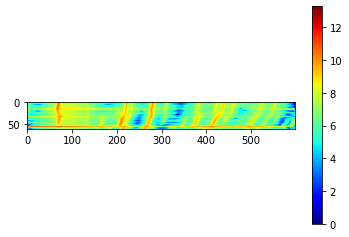

In [22]:
plt.imshow(np.log(1 + bgsubbed), cmap = 'jet')
plt.colorbar()

In [30]:
bgsubbed_noise = np.vstack([fit_curves(y, noise_estimate = fast_T.T[i], stdratio_threshold = 1.5) for y in patterns])

numBlocks: 358, dataPts/Block: 1.670391061452514
[  0.  35. 127. 183. 230. 263. 297. 342. 408. 430. 448. 501. 512. 539.
 567. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  35., 127., 183., 230., 263., 297., 342., 408., 430., 448.,
       501., 512., 539., 567., 597.])}
Peak at 7, start iteration with error = 0.9522141479331878
Peak at 7, iteration 0: error = 1.4771205021148746
45.81680774272451
Peak at 7, iteration 1: error = 1.383759675834048
40.888922105178075
Peak at 7, iteration 2: error = 1.124026301612643
    ----Saving data for block between 1.00 - 34.00
Peak at 71, start iteration with error = 0.34495506127333136
Peak at 71, iteration 0: error = 0.6027901866074106
10.732075564184159
Peak at 71, iteration 1: error = 0.02530567183498203
1.1958643815532521
    ----Saving data for block between 35.00 - 126.00
Peak at 132, start iteration with error = 0.8034674005309951
Peak at 132, iteration 0: error = 0.15687590084012784
5.480185640682441
Peak at 132, iteration 1: 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 523, start iteration with error = 0.4717826947423572
Peak at 523, iteration 0: error = 0.4852790525793488
10.026656348238864
Peak at 523, iteration 1: error = 0.08596431828267401
2.1674345834641606
Peak at 523, iteration 2: error = 0.07364007080460469
    ----Saving data for block between 511.00 - 538.00
Peak at 554, start iteration with error = 0.39939646718384025
Peak at 554, iteration 0: error = 0.5834095379626083
5.465759054362207
Peak at 554, iteration 1: error = 0.08400434865714232
0.9951273182723549
    ----Saving data for block between 539.00 - 563.00
Peak at 572, start iteration with error = 0.7509888990531967
Peak at 572, iteration 0: error = 0.3580628682858496
5.511986780270467
Peak at 572, iteration 1: error = 0.4564932993310396
3.1270293890108416
Peak at 572, iteration 2: error = 0.6449469828323626
    ----Saving data for block between 564.00 - 596.00
numBlocks: 364, dataPts/Block: 1.6428571428571428
[  0.  35. 127. 183. 230. 263. 303. 340. 408. 431. 448. 488. 514.

Peak at 523, start iteration with error = 0.3993439305831897
Peak at 523, iteration 0: error = 0.5746310561102752
8.559306603252152
Peak at 523, iteration 1: error = 0.06216084083958278
1.4603157790592027
    ----Saving data for block between 514.00 - 543.00
Peak at 554, start iteration with error = 0.4802046244540223
Peak at 554, iteration 0: error = 0.5160415985718282
10.634475579397066
Peak at 554, iteration 1: error = 0.027208551736644892
0.7136874970783279
    ----Saving data for block between 544.00 - 566.00
Peak at 572, start iteration with error = 0.47099027953109557
Peak at 572, iteration 0: error = 0.5206187155649641
15.334827015933833
Peak at 572, iteration 1: error = 0.03403418553814109
1.964540191906422
Peak at 572, iteration 2: error = 0.03510031386326232
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 567.00 - 596.00
numBlocks: 362, dataPts/Block: 1.6519337016574585
[  0.  34. 128. 183. 229. 263.

Peak at 461, start iteration with error = 0.3906798629683095
Peak at 461, iteration 0: error = 0.5582454418587385
7.9406084865876645
Peak at 461, iteration 1: error = 0.033724634652567496
0.9476738698143248
    ----Saving data for block between 447.00 - 499.00
Peak at 509, start iteration with error = 0.267051438191037
Peak at 509, iteration 0: error = 0.7309781295962344
2.950413122802926
Peak at 509, iteration 1: error = 0.002649376618474777
0.015575734828176665


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 500.00 - 509.00
Peak at 522, start iteration with error = 0.42842721518562193
Peak at 522, iteration 0: error = 0.5323048828596851
10.644268177719104
Peak at 522, iteration 1: error = 0.06935798284328722
1.6939430977301546
Peak at 522, iteration 2: error = 0.04319003241257736
    ----Saving data for block between 510.00 - 537.00
Peak at 554, start iteration with error = 0.36511811686525336
Peak at 554, iteration 0: error = 0.6309146321267542
6.3336496556042015
Peak at 554, iteration 1: error = 0.028387725959660343
0.34965559609488056
    ----Saving data for block between 538.00 - 562.00
Peak at 572, start iteration with error = 0.7934374097153754
Peak at 572, iteration 0: error = 0.2981294159265565
5.291070942194075
Peak at 572, iteration 1: error = 0.5535930055907602
2.4063592819901
Peak at 572, iteration 2: error = 0.6789624441651443
    ----Saving data for block between 563.00 - 596.00
numBlocks: 359, dataPts/Block: 1.6657381615598885
[  0.  35.

    ----Saving data for block between 451.00 - 485.00
Peak at 508, start iteration with error = 0.14546858162666454
Peak at 508, iteration 0: error = 0.8524123986783995
5.008863148189567
Peak at 508, iteration 1: error = 0.005425152524790529
0.03760194066066896
    ----Saving data for block between 486.00 - 509.00
Peak at 522, start iteration with error = 0.39684133645351466
Peak at 522, iteration 0: error = 0.5788592194592103
8.035653724757283
Peak at 522, iteration 1: error = 0.06751747818249684
1.4620230344906855
    ----Saving data for block between 510.00 - 542.00
Peak at 553, start iteration with error = 0.5177649689848118
Peak at 553, iteration 0: error = 0.47812734679061963
7.0777168561816595
Peak at 553, iteration 1: error = 0.020603651941439784
0.3350923563129571
    ----Saving data for block between 543.00 - 565.00
Peak at 571, start iteration with error = 0.8675233085042511
Peak at 571, iteration 0: error = 0.14681172587180685
2.459152373517726
Peak at 571, iteration 1: err

Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 406.00 - 429.00
Peak at 438, start iteration with error = 0.4452352103306618
Peak at 438, iteration 0: error = 0.5509791501762727
14.413409476206409
Peak at 438, iteration 1: error = 0.024397140015275237
0.8750022116590044
    ----Saving data for block between 430.00 - 446.00
Peak at 460, start iteration with error = 0.30371339134091885
Peak at 460, iteration 0: error = 0.6774887595116994
15.460807093555596
Peak at 460, iteration 1: error = 0.023340585237615882
1.0598189225088523
    ----Saving data for block between 447.00 - 496.00
Peak at 507, start iteration with error = 0.17110470501252242
Peak at 507, iteration 0: error = 0.827766237541089
6.479850951107623
Peak at 507, iteration 1: error = 0.001193451579699739
0.014102023756196657
    ----Saving data for block between 497.00 - 508.00
Peak at 521, start iteration with error = 0.3438949144527931
Peak at 521, i

    ----Saving data for block between 337.00 - 404.00
Peak at 421, start iteration with error = 0.4587978138183444
Peak at 421, iteration 0: error = 0.5291839935287006
1.9213681708448591
Peak at 421, iteration 1: error = 0.0642523243758113
0.2751191369497574
    ----Saving data for block between 405.00 - 427.00
Peak at 438, start iteration with error = 0.4193064185351806
Peak at 438, iteration 0: error = 0.576040199467779
5.003273783276526
Peak at 438, iteration 1: error = 0.031151122381566296
0.33584838718109494
    ----Saving data for block between 428.00 - 445.00
Peak at 459, start iteration with error = 0.2887278870821966
Peak at 459, iteration 0: error = 0.6921500134117115
16.357460672746885
Peak at 459, iteration 1: error = 0.0197180887754007
1.0201285821916641
    ----Saving data for block between 446.00 - 495.00
Peak at 506, start iteration with error = 0.18940650247301383
Peak at 506, iteration 0: error = 0.8092300203469655
7.041272236446661
Peak at 506, iteration 1: error = 0

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 496.00 - 505.00
Peak at 520, start iteration with error = 0.3780101395491651
Peak at 520, iteration 0: error = 0.590418324381769
7.3618057860418284
Peak at 520, iteration 1: error = 0.06979401401293495
1.1259830730213316
    ----Saving data for block between 506.00 - 540.00
Peak at 551, start iteration with error = 0.4373455930697999
Peak at 551, iteration 0: error = 0.5610733610034495
6.1514318932690175
Peak at 551, iteration 1: error = 0.017902460025337106
0.2724625329959702
    ----Saving data for block between 541.00 - 560.00
Peak at 569, start iteration with error = 0.932055136526245
Peak at 569, iteration 0: error = 0.4121693027791029
2.5967983392910634
Peak at 569, iteration 1: error = 0.8141240482850246
1.4083567263282757
    ----Saving data for block between 561.00 - 596.00
numBlocks: 371, dataPts/Block: 1.6118598382749325
[  0.  33. 130. 189. 227. 261. 301. 350. 405. 427. 446. 495. 506. 534.
 561. 597.]
Experimental Info used: 

{'blockBo

Peak at 520, start iteration with error = 0.39415333511888706
Peak at 520, iteration 0: error = 0.5672297121349917
5.893779959202981
Peak at 520, iteration 1: error = 0.10945749267628715
1.4259979293214486
    ----Saving data for block between 506.00 - 539.00
Peak at 551, start iteration with error = 0.5259524805158885
Peak at 551, iteration 0: error = 0.46925383061527776
3.398104457061654
Peak at 551, iteration 1: error = 0.03387236171987306
0.3064362128371375
    ----Saving data for block between 540.00 - 564.00
Peak at 568, start iteration with error = 0.4855590582778128
Peak at 568, iteration 0: error = 0.45006190750301445
3.567107069718851
Peak at 568, iteration 1: error = 0.10250844088100808
0.8949848246016198
    ----Saving data for block between 565.00 - 596.00
numBlocks: 373, dataPts/Block: 1.6032171581769437
[  0.  33. 130. 187. 226. 260. 301. 348. 405. 428. 446. 494. 540. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  33., 130., 187., 226., 260., 301., 348., 4

    ----Saving data for block between 494.00 - 533.00
Peak at 550, start iteration with error = 0.8379083154539717
Peak at 550, iteration 0: error = 2.3361128044486716
1.732683486935358
Peak at 550, iteration 1: error = 1.924453073459339
1.366788064286355
    ----Saving data for block between 534.00 - 596.00
numBlocks: 378, dataPts/Block: 1.582010582010582
[  0.  32. 127. 186. 227. 260. 301. 349. 405. 426. 449. 494. 533. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  32., 127., 186., 227., 260., 301., 349., 405., 426., 449.,
       494., 533., 597.])}
Peak at 1, start iteration with error = 0.5038657185537979
Peak at 1, iteration 0: error = 0.4752303628939312
13.913837400776808
Peak at 1, iteration 1: error = 0.058134106313818726
2.725932010976204
Peak at 1, iteration 2: error = 0.042897525772746324
    ----Saving data for block between 1.00 - 31.00
Peak at 69, start iteration with error = 0.8645779126505446
Peak at 69, iteration 0: error = 0.9884536368516157
4.414727515

Peak at 6, start iteration with error = 0.9527258632077817
Peak at 6, iteration 0: error = 21.370178042085723
12.98810085476112
Peak at 6, iteration 1: error = 17.192849337049587
10.658772107032823
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 6, iteration 2: error = 18.972881852042743
    ----Saving data for block between 1.00 - 22.00
Peak at 69, start iteration with error = 0.6894087819255117
Peak at 69, iteration 0: error = 0.5227743570888408
6.56807756175555
Peak at 69, iteration 1: error = 0.13783264364440537
2.5523493787036844
Peak at 69, iteration 2: error = 0.09289372349558518
    ----Saving data for block between 23.00 - 129.00
Peak at 136, start iteration with error = 0.23007538597948285
Peak at 136, iteration 0: error = 0.7640157455811383
54.909135590877504
Peak at 136, iteration 1: error = 0.041715521230542375
4.744097645726605
Peak at 136, iteration 2: error = 0.03709354411635287
Optimal parameters not found: The maximum numb

    ----Saving data for block between 32.00 - 125.00
Peak at 136, start iteration with error = 0.35877815249939854
Peak at 136, iteration 0: error = 0.6207350821074455
36.78585672703144
Peak at 136, iteration 1: error = 0.06343490407405888
8.819416147605207
Peak at 136, iteration 2: error = 0.06343490447614138
    ----Saving data for block between 126.00 - 184.00
Peak at 220, start iteration with error = 0.5720074931809487
Peak at 220, iteration 0: error = 0.33459579853721433
2.9424015596750284
Peak at 220, iteration 1: error = 0.0500200640214637
0.73928728279929
    ----Saving data for block between 185.00 - 226.00
Peak at 232, start iteration with error = 0.5957314906004108
Peak at 232, iteration 0: error = 0.3882556646200122
3.279874024792033
Peak at 232, iteration 1: error = 0.0887464519632029
1.5380361438104224
Peak at 232, iteration 2: error = 0.10474359629266906
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block be

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 596, iteration 0: error = 0.9451787467745849
34.952802888758534
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 596, iteration 1: error = 0.005829108903060633
0.27683947842416123
    ----Saving data for block between 593.00 - 596.00
numBlocks: 386, dataPts/Block: 1.549222797927461
[  0.  31. 126. 187. 225. 259. 301. 345. 407. 426. 447. 488. 533. 591.
 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  31., 126., 187., 225., 259., 301., 345., 407., 426., 447.,
       488., 533., 591., 597.])}
Peak at 1, start iteration with error = 0.9142655892469129
Peak at 1, iteration 0: error = 4.091812503608881
9.981736162489044
Peak at 1, iteration 1: error = 1.4064679137595637
9.043199675159324
Peak at 1, iteration 2: error = 1.4061640114288243
    ----Saving data for block between 1.00 - 30.00
Peak at 70, start iteration with error = 0.9284472576057338
Peak at 70, iteration 0: error = 2.0569433080127113
5.439351139620756
Peak at 70

Peak at 517, iteration 0: error = 0.8025657703820369
32.2254121816171
Peak at 517, iteration 1: error = 0.015507519552612216
0.7552751331811042
    ----Saving data for block between 488.00 - 531.00
Peak at 547, start iteration with error = 0.7677626137198825
Peak at 547, iteration 0: error = 0.22086435150801326
5.651928134892435
Peak at 547, iteration 1: error = 0.09039573104580528
3.173234900847609
Peak at 547, iteration 2: error = 0.08271822176360993
    ----Saving data for block between 532.00 - 590.00
Peak at 591, start iteration with error = 0.4617901746960445
Peak at 591, iteration 0: error = 0.5110994193007082
3.709844359431202
Peak at 591, iteration 1: error = 0.04417404009855084
0.36646808480887905
    ----Saving data for block between 591.00 - 596.00


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


numBlocks: 389, dataPts/Block: 1.5372750642673523
[  0.  16. 129. 163. 187. 226. 259. 301. 342. 407. 441. 487. 532. 590.
 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  16., 129., 163., 187., 226., 259., 301., 342., 407., 441.,
       487., 532., 590., 597.])}
Peak at 12, start iteration with error = 0.8278189026699618
Peak at 12, iteration 0: error = 0.4188773976447592
28.9986121463966
Peak at 12, iteration 1: error = 0.33659883736530394
18.940970503200422
Peak at 12, iteration 2: error = 0.30511108550650134


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 1.00 - 15.00
Peak at 71, start iteration with error = 0.4533746108416518
Peak at 71, iteration 0: error = 0.44532216180266126
9.800857168210184
Peak at 71, iteration 1: error = 0.2961523113701469
5.09247330852702
Peak at 71, iteration 2: error = 0.14562448392469884
    ----Saving data for block between 16.00 - 128.00
Peak at 136, start iteration with error = 0.23376682213684427
Peak at 136, iteration 0: error = 0.7614765541589158
352.1718276453512
Peak at 136, iteration 1: error = 0.022461965418568423
17.887833485797337
Peak at 136, iteration 2: error = 0.022461965382605205
    ----Saving data for block between 129.00 - 162.00
Peak at 168, start iteration with error = 0.1035922635050865
Peak at 168, iteration 0: error = 0.8954433104338371
48.39231201058157
Peak at 168, iteration 1: error = 0.0032151660763601216
0.2423337460728338
    ----Saving data for block between 163.00 - 186.00
Peak at 219, start iteration with error = 0.5141886740732265
Peak 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 590.00 - 596.00
numBlocks: 392, dataPts/Block: 1.5255102040816326
[  0.  29. 129. 161. 187. 225. 259. 300. 342. 407. 445. 487. 532. 589.
 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  29., 129., 161., 187., 225., 259., 300., 342., 407., 445.,
       487., 532., 589., 597.])}
Peak at 1, start iteration with error = 0.9264489558968655
Peak at 1, iteration 0: error = 2.5637263435661533
6.475506236170388
Peak at 1, iteration 1: error = 0.9463314811525515
4.468572120164816
Peak at 1, iteration 2: error = 0.9463346309343666
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 1.00 - 28.00
Peak at 71, start iteration with error = 0.924483734931999
Peak at 71, iteration 0: error = 2.1149202526912405
4.996927988336536
Peak at 71, iteration 1: error = 0.5856180808110382
3.5620104919422517
Peak at 71, iteration 2: error = 0.5818769679769946
    ----Saving data for block bet

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


numBlocks: 387, dataPts/Block: 1.545219638242894
[  0.  27. 129. 160. 188. 226. 259. 300. 341. 407. 444. 486. 532. 552.
 589. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  27., 129., 160., 188., 226., 259., 300., 341., 407., 444.,
       486., 532., 552., 589., 597.])}
Peak at 1, start iteration with error = 0.22500969598113107
Peak at 1, iteration 0: error = 0.757025929441466
15.54565608868292
Peak at 1, iteration 1: error = 0.06312947033769888
2.429646313781856
Peak at 1, iteration 2: error = 0.06312902691493626
    ----Saving data for block between 1.00 - 26.00
Peak at 72, start iteration with error = 0.8126674963150605
Peak at 72, iteration 0: error = 0.8951986116439059
4.924695481950962
Peak at 72, iteration 1: error = 0.31545368778436833
3.320165297115899
Peak at 72, iteration 2: error = 0.2652970081934031
    ----Saving data for block between 27.00 - 128.00
Peak at 136, start iteration with error = 0.39615885703174375
Peak at 136, iteration 0: error = 0.585137268

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 589.00 - 596.00
numBlocks: 388, dataPts/Block: 1.541237113402062
[  0.  27. 129. 160. 188. 224. 259. 299. 342. 407. 443. 486. 532. 555.
 588. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  27., 129., 160., 188., 224., 259., 299., 342., 407., 443.,
       486., 532., 555., 588., 597.])}
Peak at 1, start iteration with error = 0.9199993875403301
Peak at 1, iteration 0: error = 1.4861341361995293
1.664367758987276
Peak at 1, iteration 1: error = 1.2387300745841558
1.4055654161585311
    ----Saving data for block between 1.00 - 26.00
Peak at 72, start iteration with error = 0.8980430877817801
Peak at 72, iteration 0: error = 1.5238471654739651
4.919155889953046
Peak at 72, iteration 1: error = 0.07426159403271056
1.7675902822954548
Peak at 72, iteration 2: error = 0.08362414027189483
    ----Saving data for block between 27.00 - 128.00
Peak at 136, start iteration with error = 0.35850057508232835
Peak at 136, iteration 0: error = 0.62542

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 588.00 - 596.00
numBlocks: 399, dataPts/Block: 1.4987468671679198
[  0.  22. 125. 159. 188. 225. 258. 299. 341. 356. 407. 439. 486. 531.
 554. 588. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  22., 125., 159., 188., 225., 258., 299., 341., 356., 407.,
       439., 486., 531., 554., 588., 597.])}
Peak at 17, start iteration with error = 0.19793837339220133
Peak at 17, iteration 0: error = 0.7933991852682432
19.34061963506693
Peak at 17, iteration 1: error = 0.03137212875546178
1.1584476081077961
    ----Saving data for block between 1.00 - 21.00
Peak at 72, start iteration with error = 0.7526316146180829
Peak at 72, iteration 0: error = 0.7164990192466109
4.961898416728351
Peak at 72, iteration 1: error = 0.06177365911383049
1.6538233495251713
Peak at 72, iteration 2: error = 0.060240745047018436
    ----Saving data for block between 22.00 - 124.00
Peak at 136, start iteration with error = 0.3978484617147056
Peak at 136, iteration 0

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


numBlocks: 398, dataPts/Block: 1.5025125628140703
[  0.   4. 125. 159. 188. 224. 258. 299. 341. 355. 407. 441. 486. 531.
 553. 588. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,   4., 125., 159., 188., 224., 258., 299., 341., 355., 407.,
       441., 486., 531., 553., 588., 597.])}
Peak at 3, start iteration with error = 0.5733646686899764
Peak at 3, iteration 0: error = 0.2974784937938489
5.8405612890584715


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 3, iteration 1: error = 0.10968492263451889
0.8040980426225259
    ----Saving data for block between 1.00 - 3.00
Peak at 73, start iteration with error = 0.6234301174088881
Peak at 73, iteration 0: error = 0.38082615488633886
5.366161620816979
Peak at 73, iteration 1: error = 0.04919165878295469
1.6277039204927217
Peak at 73, iteration 2: error = 0.04919165894097595
    ----Saving data for block between 4.00 - 124.00
Peak at 136, start iteration with error = 0.38669077910719757
Peak at 136, iteration 0: error = 0.557800513888366
174.01024808672855
Peak at 136, iteration 1: error = 0.03755849678985759
17.605068589293868
Peak at 136, iteration 2: error = 0.03755849685637523
    ----Saving data for block between 125.00 - 158.00
Peak at 170, start iteration with error = 0.24466993931112124
Peak at 170, iteration 0: error = 0.7533071743064826
24.559174273087972
Peak at 170, iteration 1: error = 0.008088451481515073
0.3225289912488208
    ----Saving data for block between 159.00 - 18

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


numBlocks: 402, dataPts/Block: 1.4875621890547264
[  0. 125. 159. 188. 225. 257. 298. 340. 356. 406. 441. 485. 531. 550.
 586. 597.]
Experimental Info used: 

{'blockBounds': array([  0., 125., 159., 188., 225., 257., 298., 340., 356., 406., 441.,
       485., 531., 550., 586., 597.])}
Peak at 73, start iteration with error = 0.9086725089227601
Peak at 73, iteration 0: error = 3.94069003889554
5.235360144976122
Peak at 73, iteration 1: error = 0.4748752184266903
1.766220772227294
Peak at 73, iteration 2: error = 0.38849304031923826
    ----Saving data for block between 1.00 - 124.00
Peak at 136, start iteration with error = 0.37762895261078816
Peak at 136, iteration 0: error = 0.5671537896923435
166.88654642861962
Peak at 136, iteration 1: error = 0.03567774954986725
16.384747823451647
Peak at 136, iteration 2: error = 0.038177220276926986
    ----Saving data for block between 125.00 - 158.00
Peak at 170, start iteration with error = 0.25222463355598973
Peak at 170, iteration 0: error 

Peak at 596, iteration 0: error = 0.26993834940377054
1.703794555121485
Peak at 596, iteration 1: error = 0.12133266204869593
0.5906860430058143
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 585.00 - 596.00
numBlocks: 414, dataPts/Block: 1.4444444444444444
[  0. 128. 151. 189. 224. 255. 298. 339. 365. 405. 438. 477. 524. 551.
 583. 597.]
Experimental Info used: 

{'blockBounds': array([  0., 128., 151., 189., 224., 255., 298., 339., 365., 405., 438.,
       477., 524., 551., 583., 597.])}
Peak at 73, start iteration with error = 0.7278140002765818
Peak at 73, iteration 0: error = 0.8101575238516157
5.363499021382212
Peak at 73, iteration 1: error = 0.12359530839121786
1.285034478096495
    ----Saving data for block between 1.00 - 127.00
Peak at 135, start iteration with error = 0.3311076783616203
Peak at 135, iteration 0: error = 0.6587047756596245
251.14051160923992
Peak at 135, iteration 1: error = 0.025656

Peak at 559, start iteration with error = 0.3062705951861644
Peak at 559, iteration 0: error = 0.6857360649587798
14.285728381171506
Peak at 559, iteration 1: error = 0.03491381277958497
0.9268297882011929
    ----Saving data for block between 547.00 - 580.00
Peak at 596, start iteration with error = 0.2317831118059971
Peak at 596, iteration 0: error = 0.7658944990353183
71.3468338286101
Peak at 596, iteration 1: error = 0.025428325229104876
2.6826155990046225
Peak at 596, iteration 2: error = 0.008300996375886428
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 581.00 - 596.00
numBlocks: 421, dataPts/Block: 1.4204275534441806
[  0. 128. 157. 188. 221. 254. 291. 337. 360. 403. 436. 471. 526. 548.
 578. 597.]
Experimental Info used: 

{'blockBounds': array([  0., 128., 157., 188., 221., 254., 291., 337., 360., 403., 436.,
       471., 526., 548., 578., 597.])}
Peak at 73, start iteration with error = 0.9861100131

Peak at 481, start iteration with error = 0.1413428004462274
Peak at 481, iteration 0: error = 0.8569924913668209
316.13608460522283
Peak at 481, iteration 1: error = 0.0022492839618866566
1.1943951572979101
    ----Saving data for block between 470.00 - 487.00
Peak at 509, start iteration with error = 0.47578662850560305
Peak at 509, iteration 0: error = 0.45122314437974653
8.406569033078103
Peak at 509, iteration 1: error = 0.11928505224971186
1.80515474266011
Peak at 509, iteration 2: error = 0.05720868447673317
    ----Saving data for block between 488.00 - 520.00
Peak at 537, start iteration with error = 0.3721132801977344
Peak at 537, iteration 0: error = 0.6237494643957726
5.889586741490626
Peak at 537, iteration 1: error = 0.034743751849592906
0.42966191708849016
    ----Saving data for block between 521.00 - 543.00
Peak at 556, start iteration with error = 0.943182727239275
Peak at 556, iteration 0: error = 1.7946558455684025
2.3481005465129137
Peak at 556, iteration 1: error 

Peak at 353, start iteration with error = 0.780054242815204
Peak at 353, iteration 0: error = 0.2402931225962747
2.275979962284057
Peak at 353, iteration 1: error = 0.16842598678766252
1.2048707003631016
    ----Saving data for block between 331.00 - 358.00
Peak at 380, start iteration with error = 0.5393347431355663
Peak at 380, iteration 0: error = 0.45345218909100315
2.0971698522579136
Peak at 380, iteration 1: error = 0.06161998454920531
0.49005827887298564
    ----Saving data for block between 359.00 - 400.00
Peak at 421, start iteration with error = 0.618898149938188
Peak at 421, iteration 0: error = 0.3721468108939447
1.0003506306569494
    ----Saving data for block between 401.00 - 433.00
Peak at 445, start iteration with error = 0.54513210065475
Peak at 445, iteration 0: error = 0.4167524476869762
2.556546527641543
Peak at 445, iteration 1: error = 0.11718276676341434
0.6141093301535177
    ----Saving data for block between 434.00 - 467.00
Peak at 480, start iteration with err

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 572.00 - 583.00
Peak at 596, start iteration with error = 0.2772316340392683
Peak at 596, iteration 0: error = 0.7130926893139553
23.30937837254739
Peak at 596, iteration 1: error = 0.04464117970590959
1.9326286733827636
Peak at 596, iteration 2: error = 0.030712223042369705


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 584.00 - 596.00
numBlocks: 409, dataPts/Block: 1.4621026894865525
[  0. 128. 156. 187. 219. 254. 289. 328. 363. 400. 434. 468. 487. 519.
 544. 572. 584. 597.]
Experimental Info used: 

{'blockBounds': array([  0., 128., 156., 187., 219., 254., 289., 328., 363., 400., 434.,
       468., 487., 519., 544., 572., 584., 597.])}
Peak at 72, start iteration with error = 0.9718457958070628
Peak at 72, iteration 0: error = 0.688592633425035
3.993968655736964
Peak at 72, iteration 1: error = 0.26217864763547005
1.028396394076105
    ----Saving data for block between 1.00 - 127.00
Peak at 135, start iteration with error = 0.31352823180726597
Peak at 135, iteration 0: error = 0.6787164281803465
246.3438344284853
Peak at 135, iteration 1: error = 0.02423689851718263
16.264550280810983
Peak at 135, iteration 2: error = 0.02432982858293507
    ----Saving data for block between 128.00 - 155.00
Peak at 168, start iteration with error = 0.43074535020303556
Peak at 1

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 584.00 - 596.00
numBlocks: 412, dataPts/Block: 1.4514563106796117
[  0. 128. 156. 187. 219. 254. 288. 326. 358. 400. 433. 468. 483. 523.
 544. 572. 588. 597.]
Experimental Info used: 

{'blockBounds': array([  0., 128., 156., 187., 219., 254., 288., 326., 358., 400., 433.,
       468., 483., 523., 544., 572., 588., 597.])}
Peak at 72, start iteration with error = 0.7790085738058646
Peak at 72, iteration 0: error = 1.2063178168448934
5.608414687272729
Peak at 72, iteration 1: error = 0.18940773755370713
1.5079024013211237
Peak at 72, iteration 2: error = 0.16601760571515906
    ----Saving data for block between 1.00 - 127.00
Peak at 135, start iteration with error = 0.2606020125203822
Peak at 135, iteration 0: error = 0.734483081143308
308.0920435652087
Peak at 135, iteration 1: error = 0.01895363456951592
13.886430730200379
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 135, iteration 2: error = 0.7429

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


numBlocks: 414, dataPts/Block: 1.4444444444444444
[  0. 125. 156. 188. 219. 254. 295. 330. 362. 399. 430. 468. 483. 519.
 543. 572. 585. 597.]
Experimental Info used: 

{'blockBounds': array([  0., 125., 156., 188., 219., 254., 295., 330., 362., 399., 430.,
       468., 483., 519., 543., 572., 585., 597.])}
Peak at 72, start iteration with error = 0.9245322550865048
Peak at 72, iteration 0: error = 0.5321234748113892
3.9659026302780025
Peak at 72, iteration 1: error = 0.10742920519971869
0.8423125829781991
    ----Saving data for block between 1.00 - 124.00
Peak at 135, start iteration with error = 0.37588752328779196
Peak at 135, iteration 0: error = 0.589033072983078
174.857808755689
Peak at 135, iteration 1: error = 0.03003629732761557
18.38920935929441
Peak at 135, iteration 2: error = 0.02415044027194491
    ----Saving data for block between 125.00 - 155.00
Peak at 168, start iteration with error = 0.46024200726554293
Peak at 168, iteration 0: error = 0.5257418691166239
20.3926748

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 468.00 - 482.00
Peak at 501, start iteration with error = 0.4504075642761119
Peak at 501, iteration 0: error = 0.5160504725058312
8.875320050517727
Peak at 501, iteration 1: error = 0.11917607713264974
2.07123637788705
Peak at 501, iteration 2: error = 0.08369309724281823
    ----Saving data for block between 483.00 - 518.00
Peak at 533, start iteration with error = 0.46433969537349334
Peak at 533, iteration 0: error = 0.5219876577199919
5.903475078771864
Peak at 533, iteration 1: error = 0.0510124752007523
0.6509947029809603
    ----Saving data for block between 519.00 - 542.00
Peak at 552, start iteration with error = 0.7764469200816216
Peak at 552, iteration 0: error = 0.24027281355466762
1.0625143588293042
    ----Saving data for block between 543.00 - 571.00
Peak at 582, start iteration with error = 0.6237667804520576
Peak at 582, iteration 0: error = 0.36301301192379665
8.12516267045877
Peak at 582, iteration 1: error = 0.04952732414371971
1.

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 585.00 - 596.00
numBlocks: 412, dataPts/Block: 1.4514563106796117
[  0.  88. 125. 156. 188. 219. 254. 295. 330. 358. 399. 430. 468. 483.
 519. 540. 571. 585. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  88., 125., 156., 188., 219., 254., 295., 330., 358., 399.,
       430., 468., 483., 519., 540., 571., 585., 597.])}
Peak at 72, start iteration with error = 0.9702171034430035
Peak at 72, iteration 0: error = 5.081533551614982
1.9249405654392742
Peak at 72, iteration 1: error = 2.285077697456029
0.9220170268838707
    ----Saving data for block between 1.00 - 87.00
Peak at 92, start iteration with error = 0.3271877209453076
Peak at 92, iteration 0: error = 0.6678272815286139
149.22271267600127
Peak at 92, iteration 1: error = 0.011989032808718278
3.3973663023674123
Peak at 92, iteration 2: error = 0.009619705130200277
    ----Saving data for block between 88.00 - 124.00
Peak at 135, start iteration with error = 0.4538976104976529
Pea

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 585.00 - 596.00
numBlocks: 405, dataPts/Block: 1.4765432098765432
[  0.  87. 125. 156. 188. 218. 254. 295. 327. 358. 399. 429. 468. 487.
 514. 543. 571. 584. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  87., 125., 156., 188., 218., 254., 295., 327., 358., 399.,
       429., 468., 487., 514., 543., 571., 584., 597.])}
Peak at 72, start iteration with error = 0.9305810793349156
Peak at 72, iteration 0: error = 0.4874322159998186
2.042523207144681
Peak at 72, iteration 1: error = 0.39292564946458625
1.130141533289662
    ----Saving data for block between 1.00 - 86.00
Peak at 92, start iteration with error = 0.262055988834842
Peak at 92, iteration 0: error = 0.7352783664315056
201.16534243403035
Peak at 92, iteration 1: error = 0.009044882650829337
3.5416402024695595
Peak at 92, iteration 2: error = 0.007267026180986071
    ----Saving data for block between 87.00 - 124.00
Peak at 135, start iteration with error = 0.3439458267633665
Pea

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 571.00 - 583.00
Peak at 596, start iteration with error = 0.47046023348145394
Peak at 596, iteration 0: error = 0.4741998961459154
14.579531517964176
Peak at 596, iteration 1: error = 0.10681249079772501
3.813820820596775
Peak at 596, iteration 2: error = 0.071354963671992


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 584.00 - 596.00
numBlocks: 413, dataPts/Block: 1.4479418886198547
[  0.  87. 125. 156. 189. 218. 253. 295. 328. 362. 398. 432. 467. 482.
 522. 542. 571. 587. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  87., 125., 156., 189., 218., 253., 295., 328., 362., 398.,
       432., 467., 482., 522., 542., 571., 587., 597.])}
Peak at 71, start iteration with error = 0.6654311098887173
Peak at 71, iteration 0: error = 0.30198465406454694
2.2311144891842365
Peak at 71, iteration 1: error = 0.300800222428861
1.0875602731382406
    ----Saving data for block between 1.00 - 86.00
Peak at 94, start iteration with error = 0.26101599770932465
Peak at 94, iteration 0: error = 0.7372300081176849
195.8811685532797
Peak at 94, iteration 1: error = 0.009543441282633732
3.8302965497898396
Peak at 94, iteration 2: error = 0.0074176314800410365
    ----Saving data for block between 87.00 - 124.00
Peak at 135, start iteration with error = 0.3426844969879212


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 467.00 - 481.00
Peak at 499, start iteration with error = 0.47882264491841225
Peak at 499, iteration 0: error = 0.571041555587229
7.044448901504561
Peak at 499, iteration 1: error = 0.38010902835216653
3.292990943413826
Peak at 499, iteration 2: error = 0.3074486475013306
    ----Saving data for block between 482.00 - 521.00
Peak at 532, start iteration with error = 0.5765999049914294
Peak at 532, iteration 0: error = 0.4118362112089529
3.250405373912836
Peak at 532, iteration 1: error = 0.027587158447083156
0.3430992715652987
    ----Saving data for block between 522.00 - 541.00
Peak at 551, start iteration with error = 0.7741180252280437
Peak at 551, iteration 0: error = 0.2580364013623443
0.3509322728972345
    ----Saving data for block between 542.00 - 570.00
Peak at 581, start iteration with error = 0.7664764060453791
Peak at 581, iteration 0: error = 0.22422360562720162
5.649997250938908
Peak at 581, iteration 1: error = 0.030699353414851485


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 587.00 - 596.00
numBlocks: 410, dataPts/Block: 1.4585365853658536
[  0.  85. 124. 156. 188. 218. 253. 295. 327. 362. 398. 429. 467. 486.
 513. 542. 570. 584. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  85., 124., 156., 188., 218., 253., 295., 327., 362., 398.,
       429., 467., 486., 513., 542., 570., 584., 597.])}
Peak at 71, start iteration with error = 0.8232078671564605
Peak at 71, iteration 0: error = 1.0833437151381904
1.6946094822588373
Peak at 71, iteration 1: error = 0.8562538461221739
0.990050404748169
    ----Saving data for block between 1.00 - 84.00
Peak at 96, start iteration with error = 0.27842630947187313
Peak at 96, iteration 0: error = 0.7198780605466881
156.22381417496374
Peak at 96, iteration 1: error = 0.015712392747837103
3.9448383666073203
Peak at 96, iteration 2: error = 0.008940362917784514
    ----Saving data for block between 85.00 - 123.00
Peak at 135, start iteration with error = 0.3915663365618599
P

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 584.00 - 596.00
numBlocks: 410, dataPts/Block: 1.4585365853658536
[  0.  84. 124. 156. 189. 218. 252. 288. 326. 361. 397. 428. 466. 481.
 517. 541. 569. 586. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  84., 124., 156., 189., 218., 252., 288., 326., 361., 397.,
       428., 466., 481., 517., 541., 569., 586., 597.])}
Peak at 71, start iteration with error = 0.9845411437796259
Peak at 71, iteration 0: error = 3.728287716516883
29.82199631968584
Peak at 71, iteration 1: error = 3.74059395526945
29.818538093280242
Peak at 71, iteration 2: error = 3.740593966149269
    ----Saving data for block between 1.00 - 83.00
Peak at 84, start iteration with error = 0.27868815012648046
Peak at 84, iteration 0: error = 0.7186390153564106
962.4845281436982
Peak at 84, iteration 1: error = 0.010524286259106347
22.763004873614975
Peak at 84, iteration 2: error = 0.008811861298381348
    ----Saving data for block between 84.00 - 123.00
Peak at 124, st

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 498, start iteration with error = 0.1744828827565719
Peak at 498, iteration 0: error = 0.8227847962576632
85.41662277033096
Peak at 498, iteration 1: error = 0.029623461983787222
3.8652870723148776
Peak at 498, iteration 2: error = 0.01766570194248847
    ----Saving data for block between 481.00 - 516.00
Peak at 531, start iteration with error = 0.1826627445680209
Peak at 531, iteration 0: error = 0.8124350079328163
108.57254829440913
Peak at 531, iteration 1: error = 0.028716532594040545
4.424360492259923
Peak at 531, iteration 2: error = 0.02020814923418991
    ----Saving data for block between 517.00 - 540.00
Peak at 541, start iteration with error = 0.35434684298991576
Peak at 541, iteration 0: error = 0.6348291603145176
35.15089840204336
Peak at 541, iteration 1: error = 0.033274944032774416
2.1657807723906815
Peak at 541, iteration 2: error = 0.010451920186298489
    ----Saving data for block between 541.00 - 568.00
Peak at 569, start iteration with error = 0.618675219197

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 586.00 - 596.00
numBlocks: 409, dataPts/Block: 1.4621026894865525
[  0.  83. 124. 150. 189. 217. 252. 288. 328. 361. 396. 428. 465. 481.
 512. 541. 568. 583. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  83., 124., 150., 189., 217., 252., 288., 328., 361., 396.,
       428., 465., 481., 512., 541., 568., 583., 597.])}
Peak at 71, start iteration with error = 0.7892522357882578
Peak at 71, iteration 0: error = 0.8784560865115582
1.4940990064082005
    ----Saving data for block between 1.00 - 82.00
Peak at 92, start iteration with error = 0.30052865408486196
Peak at 92, iteration 0: error = 0.6967753072732443
113.99777328440365
Peak at 92, iteration 1: error = 0.010272445223354632
2.447549619822682
Peak at 92, iteration 2: error = 0.008321392543459195
    ----Saving data for block between 83.00 - 123.00
Peak at 135, start iteration with error = 0.45819370736483145
Peak at 135, iteration 0: error = 0.4760995492973382
133.24631991523066

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 568.00 - 582.00
Peak at 596, start iteration with error = 0.9171025305154272
Peak at 596, iteration 0: error = 4.1129650295248625
4.409868447853393
Peak at 596, iteration 1: error = 3.140715099859086
3.359811737884959
Peak at 596, iteration 2: error = 2.7110274122338205
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 583.00 - 596.00
numBlocks: 414, dataPts/Block: 1.4444444444444444
[  0.  82. 124. 150. 190. 217. 252. 288. 323. 356. 394. 427. 464. 480.
 516. 540. 567. 584. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  82., 124., 150., 190., 217., 252., 288., 323., 356., 394.,
       427., 464., 480., 516., 540., 567., 584., 597.])}
Peak at 71, start iteration with error = 0.6648686357477634
Peak at 71, iteration 0: error = 0.30947598454361336
2.686093992618944
Peak at 71, iteration 1: error = 0.10665396519925574
0.9564713561417753
    ----Saving data for bloc

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 584.00 - 596.00
numBlocks: 411, dataPts/Block: 1.4549878345498783
[  0.  81. 124. 149. 188. 216. 251. 288. 324. 359. 393. 430. 454. 479.
 516. 539. 566. 580. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  81., 124., 149., 188., 216., 251., 288., 324., 359., 393.,
       430., 454., 479., 516., 539., 566., 580., 597.])}
Peak at 71, start iteration with error = 0.9352994571891473
Peak at 71, iteration 0: error = 2.908321541724224
1.7857200224978795
Peak at 71, iteration 1: error = 1.771810541167128
1.6056174312919944
Peak at 71, iteration 2: error = 1.671005007342061
    ----Saving data for block between 1.00 - 80.00
Peak at 96, start iteration with error = 0.2139171404035229
Peak at 96, iteration 0: error = 0.7852228059558507
94.02295192467801
Peak at 96, iteration 1: error = 0.008438632400246273
1.2488975405678158
    ----Saving data for block between 81.00 - 123.00
Peak at 135, start iteration with error = 0.29086424469952515
Peak a

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 566.00 - 579.00
Peak at 594, start iteration with error = 0.6008305815806078
Peak at 594, iteration 0: error = 0.37535692693910805
20.583016622473778
Peak at 594, iteration 1: error = 0.05674194495634499
3.9469599523313232
Peak at 594, iteration 2: error = 0.04240834225548769
    ----Saving data for block between 580.00 - 596.00
numBlocks: 410, dataPts/Block: 1.4585365853658536
[  0.  80. 124. 153. 180. 216. 250. 295. 319. 358. 390. 426. 450. 478.
 510. 535. 565. 579. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  80., 124., 153., 180., 216., 250., 295., 319., 358., 390.,
       426., 450., 478., 510., 535., 565., 579., 597.])}
Peak at 70, start iteration with error = 0.8102292160979588
Peak at 70, iteration 0: error = 0.21754082566936883
2.1210679022470864
Peak at 70, iteration 1: error = 0.10390837091525017
1.0575346800621683
    ----Saving data for block between 1.00 - 79.00
Peak at 91, start iteration with error = 0.2618264651458

    ----Saving data for block between 315.00 - 353.00
Peak at 373, start iteration with error = 0.5512949198085929
Peak at 373, iteration 0: error = 0.4165711728202969
4.099229858265808
Peak at 373, iteration 1: error = 0.047443231309555634
0.4995119353993198
    ----Saving data for block between 354.00 - 385.00
Peak at 413, start iteration with error = 0.4894530595516306
Peak at 413, iteration 0: error = 0.49208136393862223
2.6526921258440757
Peak at 413, iteration 1: error = 0.06143802280142299
0.3534031555937885
    ----Saving data for block between 386.00 - 427.00
Peak at 436, start iteration with error = 0.24412047605354598
Peak at 436, iteration 0: error = 0.7354779829000628
2.0014876892715994
Peak at 436, iteration 1: error = 0.07252883324787507
0.23661779692855112
    ----Saving data for block between 428.00 - 459.00
Peak at 472, start iteration with error = 0.25243600173838077
Peak at 472, iteration 0: error = 0.7456876916786468
316.435679882081
Peak at 472, iteration 1: error

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)



Peak at 499, start iteration with error = 0.5740768223652559
Peak at 499, iteration 0: error = 0.41643061882115695
6.148344046111922
Peak at 499, iteration 1: error = 0.025436600619886295
0.4360040402090824
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 495.00 - 508.00
Peak at 526, start iteration with error = 0.3651381367714687
Peak at 526, iteration 0: error = 0.6252427774786579
8.25503856522498
Peak at 526, iteration 1: error = 0.04537982302270963
0.6591077968689176
    ----Saving data for block between 509.00 - 533.00
Peak at 543, start iteration with error = 0.47014843608850754
Peak at 543, iteration 0: error = 0.44026307569066936
1.5814542024874776
Peak at 543, iteration 1: error = 0.13588106900351707
0.39002372847920014
    ----Saving data for block between 534.00 - 557.00
Peak at 574, start iteration with error = 0.6869495207475004
Peak at 574, iteration 0: error = 0.22352274591762442
0.97155935206809

Peak at 157, start iteration with error = 0.30421903645277965
Peak at 157, iteration 0: error = 0.694285684654888
309.9115489360738
Peak at 157, iteration 1: error = 0.011894275658708583
8.230699077991027
Peak at 157, iteration 2: error = 0.004235320540386007
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 143.00 - 159.00
Peak at 165, start iteration with error = 0.2905147368537558
Peak at 165, iteration 0: error = 0.696417630256991
54.47309134736051
Peak at 165, iteration 1: error = 0.047243430908134494
4.373856320446732
Peak at 165, iteration 2: error = 0.035807574475969745


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 160.00 - 174.00
Peak at 185, start iteration with error = 0.4593961423428179
Peak at 185, iteration 0: error = 0.511500048614879
137.9606181229355
Peak at 185, iteration 1: error = 0.058166580364075994
17.418100147982916
Peak at 185, iteration 2: error = 0.045501431799919625
    ----Saving data for block between 175.00 - 195.00
Peak at 209, start iteration with error = 0.5446837305447382
Peak at 209, iteration 0: error = 0.42224820504591315
8.853480172349617
Peak at 209, iteration 1: error = 0.16476978875282322
2.5622691530977058
Peak at 209, iteration 2: error = 0.07315412923617333
    ----Saving data for block between 196.00 - 214.00
Peak at 220, start iteration with error = 0.6086303055872777
Peak at 220, iteration 0: error = 0.39200120668289307
4.875914537073469
Peak at 220, iteration 1: error = 0.27874759342095906
2.5925401054212105
Peak at 220, iteration 2: error = 0.34197400122259464
    ----Saving data for block between 215.00 - 248.00
Peak

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 165.00 - 175.00
Peak at 185, start iteration with error = 0.5126507741987134
Peak at 185, iteration 0: error = 0.46809642368126975
141.54809423106002
Peak at 185, iteration 1: error = 0.06139383312529429
23.96799958885833
Peak at 185, iteration 2: error = 0.05181782126463628
    ----Saving data for block between 176.00 - 194.00
Peak at 214, start iteration with error = 0.8013021236808987
Peak at 214, iteration 0: error = 0.41873556801881656
5.420585610758242
Peak at 214, iteration 1: error = 0.3702452646849436
3.213961267744176
Peak at 214, iteration 2: error = 0.49215065601926555
    ----Saving data for block between 195.00 - 247.00
Peak at 266, start iteration with error = 0.8219672460390504
Peak at 266, iteration 0: error = 1.2169400231676477
1.9659167093264793
Peak at 266, iteration 1: error = 2.00635549885637
1.0025108758893158
    ----Saving data for block between 248.00 - 310.00
Peak at 328, start iteration with error = 0.8010148671105283
Pe

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 341.00 - 355.00
Peak at 368, start iteration with error = 0.36684638725765917
Peak at 368, iteration 0: error = 0.6282378065842839
50.82275481220615
Peak at 368, iteration 1: error = 0.028108978949834287
3.095573472714585
Peak at 368, iteration 2: error = 0.010389621048166818
    ----Saving data for block between 356.00 - 371.00
Peak at 385, start iteration with error = 0.31300008608652097
Peak at 385, iteration 0: error = 0.6853861792997715
5.435146460410266
Peak at 385, iteration 1: error = 0.012335709037946
0.11361575628836201
    ----Saving data for block between 372.00 - 387.00
Peak at 396, start iteration with error = 0.33105842201714253
Peak at 396, iteration 0: error = 0.6666400316324282
21.391471731313725
Peak at 396, iteration 1: error = 0.025951564139393243
0.9847470298957034
    ----Saving data for block between 388.00 - 400.00
Peak at 411, start iteration with error = 0.4974603640467876
Peak at 411, iteration 0: error = 0.4950139583397

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 465, start iteration with error = 0.1172994415831635
Peak at 465, iteration 0: error = 0.8804935593830094
63.553878416183395
Peak at 465, iteration 1: error = 0.018688660928281878
1.6963757627416414
Peak at 465, iteration 2: error = 0.00985611793815376
    ----Saving data for block between 454.00 - 475.00
Peak at 495, start iteration with error = 0.4243342270225929
Peak at 495, iteration 0: error = 0.5720025910865252
9.691514690460998
Peak at 495, iteration 1: error = 0.020476976260519284
0.4210510234868446
    ----Saving data for block between 476.00 - 509.00
Peak at 522, start iteration with error = 0.4622433328482082
Peak at 522, iteration 0: error = 0.5219245401034269
12.953365102104396
Peak at 522, iteration 1: error = 0.0479786868048022
1.4780822683898212
    ----Saving data for block between 510.00 - 531.00
Peak at 535, start iteration with error = 0.5538615525794318
Peak at 535, iteration 0: error = 0.43973989182384243
1.8039050316511105
Peak at 535, iteration 1: error 

numBlocks: 435, dataPts/Block: 1.374712643678161
[  0.  75. 124. 143. 163. 176. 200. 224. 246. 273. 311. 336. 356. 374.
 387. 398. 419. 444. 454. 475. 505. 529. 558. 584. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  75., 124., 143., 163., 176., 200., 224., 246., 273., 311.,
       336., 356., 374., 387., 398., 419., 444., 454., 475., 505., 529.,
       558., 584., 597.])}
Peak at 68, start iteration with error = 0.9536136445563601
Peak at 68, iteration 0: error = 0.40490189179276737
1.6839758270558447
Peak at 68, iteration 1: error = 0.38678530819705914
1.5686635727112779
Peak at 68, iteration 2: error = 0.3867844062117343
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 1.00 - 74.00
Peak at 92, start iteration with error = 0.30694275406592625
Peak at 92, iteration 0: error = 0.6912463847750029
8.218347946722341
Peak at 92, iteration 1: error = 0.017525049998380338
0.24356088638116422
    ----Sa

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 464, start iteration with error = 0.10291631418053457
Peak at 464, iteration 0: error = 0.8953495349109801
80.56218231303694
Peak at 464, iteration 1: error = 0.014237691421972534
1.6605995405761476
Peak at 464, iteration 2: error = 0.005274819787673858
    ----Saving data for block between 454.00 - 474.00
Peak at 493, start iteration with error = 0.42534709300532875
Peak at 493, iteration 0: error = 0.5734679512587277
15.721684876861989
Peak at 493, iteration 1: error = 0.019642587278551157
0.7084826401434573
    ----Saving data for block between 475.00 - 504.00
Peak at 518, start iteration with error = 0.45537806041067475
Peak at 518, iteration 0: error = 0.5372388566518648
10.893333264749428
Peak at 518, iteration 1: error = 0.02662878271143738
0.6760370730982986
    ----Saving data for block between 505.00 - 528.00
Peak at 534, start iteration with error = 0.3853145348837751
Peak at 534, iteration 0: error = 0.6117484457998081
4.815973632917609
Peak at 534, iteration 1: err

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 385, start iteration with error = 0.5692096446864302
Peak at 385, iteration 0: error = 0.3913665490393494
0.7407732023170064
    ----Saving data for block between 370.00 - 386.00
Peak at 395, start iteration with error = 0.3638424094799958
Peak at 395, iteration 0: error = 0.6220927103731486
8.859597756224154
Peak at 395, iteration 1: error = 0.052306169401211626
0.9304826331810097
    ----Saving data for block between 387.00 - 395.00


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 406, start iteration with error = 0.7046404585263377
Peak at 406, iteration 0: error = 0.1927774067766255
6.696120367361055
Peak at 406, iteration 1: error = 0.1233906140501686
2.1926276088495227
Peak at 406, iteration 2: error = 0.10508419389267003
    ----Saving data for block between 396.00 - 420.00
Peak at 429, start iteration with error = 0.8098581450897662
Peak at 429, iteration 0: error = 0.16115405685429193
0.15282646041979098
    ----Saving data for block between 421.00 - 443.00
Peak at 450, start iteration with error = 0.6961668093124154
Peak at 450, iteration 0: error = 0.29484387124227196
0.20298842405566414
    ----Saving data for block between 444.00 - 452.00
Peak at 464, start iteration with error = 0.6823363956570979
Peak at 464, iteration 0: error = 0.25323975527523546
1.3050253300591903
    ----Saving data for block between 453.00 - 473.00
Peak at 491, start iteration with error = 0.8259329849939382
Peak at 491, iteration 0: error = 0.20220704901901615
3.02007

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 359.00 - 369.00
Peak at 385, start iteration with error = 0.45804253187182686
Peak at 385, iteration 0: error = 0.5315113801628532
1.3156447656541375
    ----Saving data for block between 370.00 - 386.00
Peak at 404, start iteration with error = 0.6687404148789681
Peak at 404, iteration 0: error = 0.3235908958604433
12.54457361364904
Peak at 404, iteration 1: error = 0.21426339884361145
5.338351473804227
Peak at 404, iteration 2: error = 0.16014239115605922
    ----Saving data for block between 387.00 - 417.00
Peak at 429, start iteration with error = 0.4941190595569612
Peak at 429, iteration 0: error = 0.4373789780023458
0.5810430002292437
    ----Saving data for block between 418.00 - 443.00
Peak at 450, start iteration with error = 0.2814703496408008
Peak at 450, iteration 0: error = 0.7155187464738816
2.2394084876466684
Peak at 450, iteration 1: error = 0.0035132976533380055
0.014423827358677152
Optimal parameters not found: The maximum number 

Peak at 453, iteration 1: error = 0.0064454726705771605
0.05597493069865877
    ----Saving data for block between 447.00 - 459.00
Peak at 467, start iteration with error = 0.17836071327521064
Peak at 467, iteration 0: error = 0.8198916487039719
345.9198634127898
Peak at 467, iteration 1: error = 0.008276024763854745
4.003005094641573
Peak at 467, iteration 2: error = 0.006022655233548004
    ----Saving data for block between 460.00 - 475.00
Peak at 492, start iteration with error = 0.5760627754634188
Peak at 492, iteration 0: error = 0.42375891520048753
12.566299720397865
Peak at 492, iteration 1: error = 0.04526805249668229
1.98321866180347
Peak at 492, iteration 2: error = 0.049406106150843995
    ----Saving data for block between 476.00 - 502.00
Peak at 518, start iteration with error = 0.5466767358859815
Peak at 518, iteration 0: error = 0.44400376186951623
6.064195017642401
Peak at 518, iteration 1: error = 0.045465784803766916
0.939328789852869
    ----Saving data for block betwe

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [31]:
(bgsubbed_noise.mean(axis = 1) >= threshold).sum()

30

In [50]:
for i, recalculate in enumerate(bgsubbed_noise.mean(axis = 1) >= threshold):
    if recalculate:
        bgsubbed_noise[i] = fit_curves(patterns[i], noise_estimate = fast_T.T[i], stdratio_threshold = 2)

numBlocks: 405, dataPts/Block: 1.4765432098765432
[  0.  87. 125. 156. 188. 218. 254. 295. 327. 358. 399. 429. 468. 487.
 514. 543. 571. 584. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  87., 125., 156., 188., 218., 254., 295., 327., 358., 399.,
       429., 468., 487., 514., 543., 571., 584., 597.])}
Peak at 72, start iteration with error = 0.953171499923533
Peak at 72, iteration 0: error = 0.30830382990141986
9.480720549387641
Peak at 72, iteration 1: error = 0.2870001511445211
6.954728689327316
Peak at 72, iteration 2: error = 0.2863043232249425
    ----Saving data for block between 1.00 - 86.00
Peak at 90, start iteration with error = 0.27347819717197913
Peak at 90, iteration 0: error = 0.7231583593100953
55.34637069929626
Peak at 90, iteration 1: error = 0.009010287316987546
1.0226296539840183
    ----Saving data for block between 87.00 - 124.00
Peak at 135, start iteration with error = 0.35168311157882337
Peak at 135, iteration 0: error = 0.620554103579434
25.954

In [156]:
from matplotlib.widgets import Slider
from pylab import *

In [174]:
# bad rows: 50, ...
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

def f(i):
#     plt.plot(patterns[i], label = 'raw')
    plt.plot(bgsubbed[i], label = 'curve fit subtraction')
    plt.legend()
    plt.grid()

interactive_plot = interactive(f, i=(0, 60), step = 1)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=30, description='i', max=60), Output(layout=Layout(height='350px'))), _d…

In [16]:
bgsubbed = np.vstack(bgsubbed)

In [194]:
with open('data/yijin_cheb_bgsub.npy', 'wb') as f:
    np.save(f, bgsubbed)

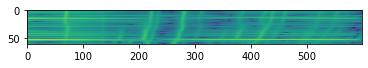

In [15]:
plt.imshow(np.log(1 + np.vstack(bgsubbed)))

# Stop condition based on noise estimate

In [390]:
from importlib import reload
reload(sep)

<module 'xrdc.source_separation' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/source_separation.py'>

In [391]:
from xrdc import source_separation as sep
slow_q, fast_q, slow_T, fast_T = sep.separate_signal(patterns)

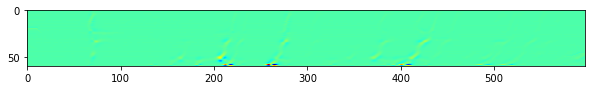

In [124]:
plt.imshow(fast_T.T, cmap = 'jet')

In [16]:
%pdb

Automatic pdb calling has been turned ON


In [20]:
tmp_noise = fit_curves(patterns[i], noise_estimate = fast_T.T[i], stdratio_threshold = 1.5)

numBlocks: 410, dataPts/Block: 1.4585365853658536
[  0.  80. 124. 153. 180. 216. 250. 295. 319. 358. 390. 426. 450. 478.
 510. 535. 565. 579. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  80., 124., 153., 180., 216., 250., 295., 319., 358., 390.,
       426., 450., 478., 510., 535., 565., 579., 597.])}
Peak at 70, start iteration with error = 0.8954622878967595
Peak at 70, iteration 0: error = 0.2032032707641565
4.30003736421616
Peak at 70, iteration 1: error = 0.1634125912060861
3.117529377364593
Peak at 70, iteration 2: error = 0.15372658798604658
    ----Saving data for block between 1.00 - 79.00
Peak at 91, start iteration with error = 0.29744862632659186
Peak at 91, iteration 0: error = 0.7005850547703371
655.4673565515208
Peak at 91, iteration 1: error = 0.023507799728151004
25.363323736540465
Peak at 91, iteration 2: error = 0.011132750393302283
    ----Saving data for block between 80.00 - 123.00
Peak at 135, start iteration with error = 0.3813735195299301
Peak 

In [10]:
tmp = fit_curves(patterns[i], noise_estimate = None, stdratio_threshold = 2)

numBlocks: 411, dataPts/Block: 1.4549878345498783
[  0.  76. 127. 149. 167. 176. 202. 226. 246. 273. 314. 344. 358. 376.
 390. 398. 421. 447. 460. 476. 503. 531. 559. 587. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  76., 127., 149., 167., 176., 202., 226., 246., 273., 314.,
       344., 358., 376., 390., 398., 421., 447., 460., 476., 503., 531.,
       559., 587., 597.])}
Peak at 68, start iteration with error = 0.5097905812309175
Peak at 68, iteration 0: error = 0.4142675508058265
Peak at 68, iteration 1: error = 0.1440705288145415
Peak at 68, iteration 2: error = 0.14406258502538766
    ----Saving data for block between 1.00 - 75.00
Peak at 104, start iteration with error = 0.3985823902099456
Peak at 104, iteration 0: error = 0.5648419350456224
Peak at 104, iteration 1: error = 0.023726759362318786
Peak at 104, iteration 2: error = 0.02372675936831845
    ----Saving data for block between 76.00 - 126.00
Peak at 137, start iteration with error = 0.5061215860788141
Pe

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 167.00 - 175.00
Peak at 185, start iteration with error = 0.5799326033985286
Peak at 185, iteration 0: error = 0.21005639620205369
Peak at 185, iteration 1: error = 0.12405988680701076
Peak at 185, iteration 2: error = 0.08640814350795845
    ----Saving data for block between 176.00 - 201.00
Peak at 216, start iteration with error = 0.7537770280742621
Peak at 216, iteration 0: error = 0.3511869124612352
Peak at 216, iteration 1: error = 0.914429041743698
Peak at 216, iteration 2: error = 0.9214191471281974
    ----Saving data for block between 202.00 - 225.00
Peak at 231, start iteration with error = 0.5063420522845157
Peak at 231, iteration 0: error = 0.47012966003238466
Peak at 231, iteration 1: error = 0.1141114633726182
Peak at 231, iteration 2: error = 0.0319757065956475
    ----Saving data for block between 226.00 - 245.00
Peak at 263, start iteration with error = 0.7777521440124979
Peak at 263, iteration 0: error = 0.32847170062612474
Peak a

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 369, start iteration with error = 0.1964234596412536
Peak at 369, iteration 0: error = 0.8007264655480879
Peak at 369, iteration 1: error = 0.021142880142990334
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 369, iteration 2: error = 0.8079594113289948
    ----Saving data for block between 358.00 - 375.00
Peak at 387, start iteration with error = 0.35345695076455375
Peak at 387, iteration 0: error = 0.6459129036073927
Peak at 387, iteration 1: error = 0.002797556437281869
Peak at 387, iteration 2: error = 0.0027975564373533025


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 376.00 - 389.00
Peak at 397, start iteration with error = 0.2948606185763136
Peak at 397, iteration 0: error = 0.7016490783654602
Peak at 397, iteration 1: error = 0.02287805966146249
Peak at 397, iteration 2: error = 0.013556979137872887
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 390.00 - 397.00
Peak at 407, start iteration with error = 0.562216329182747
Peak at 407, iteration 0: error = 0.39241302599345884
Peak at 407, iteration 1: error = 0.06581374537495352
Peak at 407, iteration 2: error = 0.04619870652336674
    ----Saving data for block between 398.00 - 420.00
Peak at 431, start iteration with error = 0.2204807428438116
Peak at 431, iteration 0: error = 0.7744661526312993
Peak at 431, iteration 1: error = 0.013065531264307678
Peak at 431, iteration 2: error = 0.0061447110016406795
    ----Saving data for block between 421.00 - 446.00
Peak at 453, start iteration

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 447.00 - 459.00
Peak at 467, start iteration with error = 0.08778266993948618
Peak at 467, iteration 0: error = 0.911491159918923
Peak at 467, iteration 1: error = 0.003620511898454562
Peak at 467, iteration 2: error = 0.0026483062367927907
    ----Saving data for block between 460.00 - 475.00
Peak at 492, start iteration with error = 0.42587968824864936
Peak at 492, iteration 0: error = 0.5730571932313349
Peak at 492, iteration 1: error = 0.023911655371024527
Peak at 492, iteration 2: error = 0.024254250579525127
    ----Saving data for block between 476.00 - 502.00
Peak at 518, start iteration with error = 0.4335314532507298
Peak at 518, iteration 0: error = 0.5599159733422311
Peak at 518, iteration 1: error = 0.031321984773253785
Peak at 518, iteration 2: error = 0.020924295447626647
    ----Saving data for block between 503.00 - 530.00
Peak at 537, start iteration with error = 0.32680028294204216
Peak at 537, iteration 0: error = 0.670640148898

## Chebyshev background fit instability:

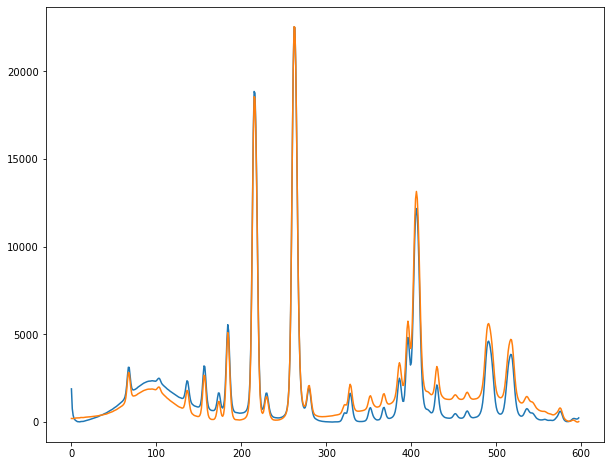

In [14]:
plt.plot(tmp_noise)
plt.plot(tmp)

# Add in fourier background subtraction, compare to Chebyshev

Use default stop condition

In [63]:
from importlib import reload
reload(hitp)

<module 'dataproc.operations.hitp' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/dataproc-1.0-py3.7.egg/dataproc/operations/hitp.py'>

In [53]:
patterns.shape

(60, 598)

In [385]:
reload(sep)

<module 'xrdc.source_separation' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/source_separation.py'>

In [386]:
from xrdc import source_separation as sep
slow_q, fast_q, slow_T, fast_T = sep.separate_signal(patterns)

#background = sep.get_background(patterns, threshold = 25, smooth_q = 1.7, method = 'simple')
background = sep.get_background(slow_T, threshold = 25, smooth_q = 1.7, method = 'simple')

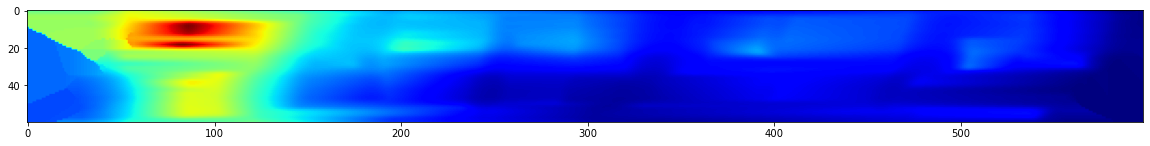

In [387]:
plt.imshow(background, cmap = 'jet')

In [383]:
signal = slow_T - background

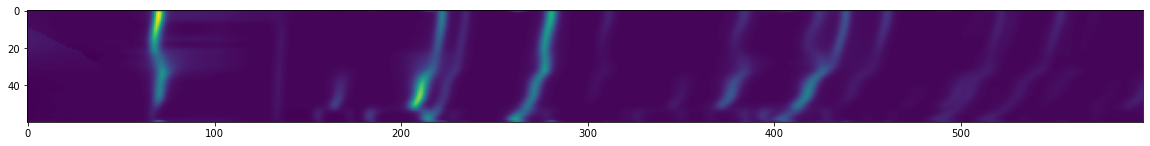

In [384]:
plt.imshow(signal)

In [393]:
background = sep.get_background(slow_T, threshold = 25, method='simple')

Raw data:

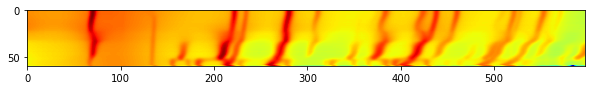

In [249]:
plt.imshow(np.log(1 + patterns - patterns.min()), cmap = 'jet')

Extracted peaks:

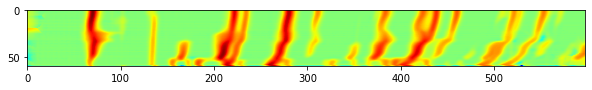

In [248]:
plt.imshow(np.log(1 + fast_q - fast_q.min()), cmap = 'jet')

Peak exclusion map with threshold == 25th percentile:

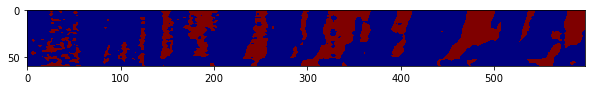

In [241]:
plt.imshow(np.log(.001 + sep.get_bgmask(patterns, 25)), cmap = 'jet', interpolation = 'none')

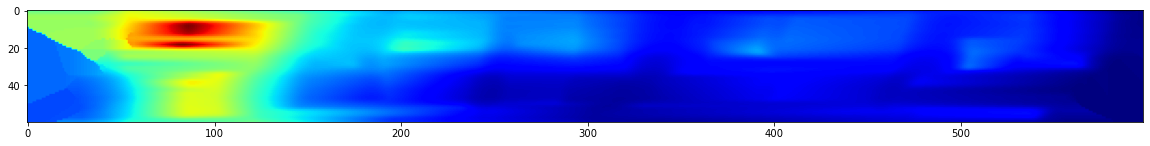

In [394]:
plt.imshow(background, cmap = 'jet')

(2, 60, 598)
(2, 60, 598)


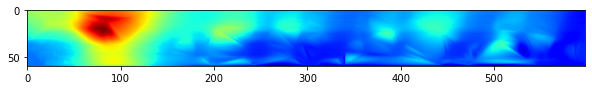

In [200]:
plt.imshow(sep.get_background(patterns, threshold = 25, method='cloughtocher'), cmap = 'jet')

In [202]:
y_chebsub = fit_curves(patterns[i], downsample_int = 50)

numBlocks: 414, dataPts/Block: 1.4444444444444444
[  0. 128. 151. 189. 224. 255. 298. 339. 365. 405. 438. 477. 524. 551.
 583. 597.]
Experimental Info used: 

{'blockBounds': array([  0., 128., 151., 189., 224., 255., 298., 339., 365., 405., 438.,
       477., 524., 551., 583., 597.])}
Peak at 73, start iteration with error = 0.9746976658181494
Peak at 73, iteration 0: error = 0.7632643049653883
Peak at 73, iteration 1: error = 0.28786401653171223
Peak at 73, iteration 2: error = 0.2836495505385252
    ----Saving data for block between 1.00 - 127.00
Peak at 135, start iteration with error = 0.3522892839538164
Peak at 135, iteration 0: error = 0.6356975531416189
Peak at 135, iteration 1: error = 0.02825465988502006
Peak at 135, iteration 2: error = 0.025922827919779984
    ----Saving data for block between 128.00 - 150.00
Peak at 170, start iteration with error = 0.27702391295418577
Peak at 170, iteration 0: error = 0.7165927381413776
Peak at 170, iteration 1: error = 0.0216082439181571

In [205]:
y_fsub = fit_curves(patterns[i], background = background[i])

numBlocks: 414, dataPts/Block: 1.4444444444444444
[  0. 128. 151. 189. 224. 255. 298. 339. 365. 405. 438. 477. 524. 551.
 583. 597.]
Experimental Info used: 

{'blockBounds': array([  0., 128., 151., 189., 224., 255., 298., 339., 365., 405., 438.,
       477., 524., 551., 583., 597.])}
Peak at 73, start iteration with error = 2.2557912022718787
Peak at 73, iteration 0: error = 2.8251054570348244
Peak at 73, iteration 1: error = 0.9413973281888355
Peak at 73, iteration 2: error = 0.9413973292908348
    ----Saving data for block between 1.00 - 127.00
Peak at 136, start iteration with error = 0.6475416311150094
Peak at 136, iteration 0: error = 0.11733597048635004
Peak at 136, iteration 1: error = -0.6684159352874665
Peak at 136, iteration 2: error = -1.4072143919629334
    ----Saving data for block between 128.00 - 150.00
Peak at 170, start iteration with error = 1.2639816664070973
Peak at 170, iteration 0: error = -1.5352019854667773
Peak at 170, iteration 1: error = -0.2272234977887527

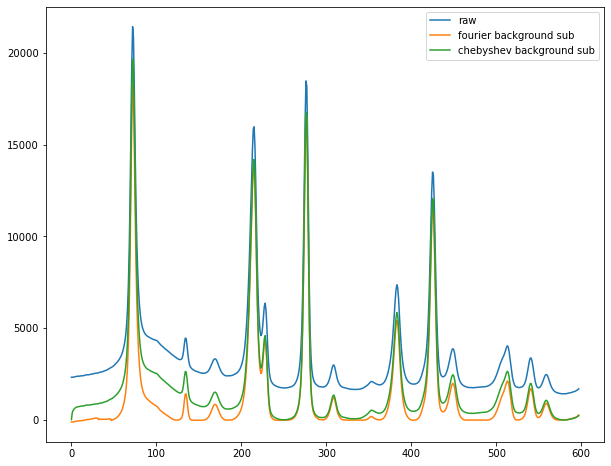

In [204]:
plt.plot(patterns[i], label = 'raw')
plt.plot(y_fsub, label = 'fourier background sub')
plt.plot(y_chebsub, label = 'chebyshev background sub')
plt.legend()

In [222]:
background[i]

array([2437.8668571 , 2437.8668571 , 2437.8668571 , 2437.8668571 ,
       2437.8668571 , 2437.8668571 , 2437.8668571 , 2437.8668571 ,
       2437.8668571 , 2437.8668571 , 2437.8668571 , 2437.8668571 ,
       2437.8668571 , 2437.8668571 , 2437.8668571 , 2437.8668571 ,
       2437.8668571 , 2437.8668571 , 2437.8668571 , 2437.8668571 ,
       2437.8668571 , 2437.8668571 , 2437.8668571 , 2437.8668571 ,
       2437.8668571 , 2437.8668571 , 2437.8668571 , 2437.8668571 ,
       2437.8668571 , 2447.58764304, 2457.45383819, 2467.53325923,
       2547.40016237, 2547.40016237, 2559.11517484, 2571.49106603,
       2584.83047422, 2599.37466381, 2615.27750857, 2632.51542532,
       2650.82885336, 2669.88540293, 2689.54795656, 2709.94965527,
       2731.26090727, 2753.33907069, 2775.67098244, 2888.69926423,
       2888.69926423, 2910.3514427 , 2931.04283183, 2949.91794161,
       2966.43140302, 2980.87221525, 2994.05676825, 3006.70838138,
       3019.20074904, 3031.65949873, 3044.1132218 , 3056.56641

# Put in stop condition

In [253]:
y_fsub_stop = fit_curves(patterns[i], background = background[i],
                         noise_estimate = fast_T.T[i], stdratio_threshold = 2)

numBlocks: 414, dataPts/Block: 1.4444444444444444
[  0. 128. 151. 189. 224. 255. 298. 339. 365. 405. 438. 477. 524. 551.
 583. 597.]
Experimental Info used: 

{'blockBounds': array([  0., 128., 151., 189., 224., 255., 298., 339., 365., 405., 438.,
       477., 524., 551., 583., 597.])}
negative values in background-subtracted pattern. taking absolute value.
Peak at 73, start iteration with error = 0.9801843484918483
Peak at 73, iteration 0: error = 3.63321718291097
2.1610252173555535
Peak at 73, iteration 1: error = 0.3799127635112271
1.036314994127792
    ----Saving data for block between 1.00 - 127.00
Peak at 136, start iteration with error = 0.4486477954730887
Peak at 136, iteration 0: error = 0.5250500405974753
32.29733294251421
Peak at 136, iteration 1: error = 0.14171338093970287
12.035267824642911
Peak at 136, iteration 2: error = 0.13205790689479233
    ----Saving data for block between 128.00 - 150.00
Peak at 170, start iteration with error = 0.4564312106486672
Peak at 170, it

In [206]:
y_fsub_stop = fit_curves(patterns[i], background = background[i],
                         noise_estimate = fast_T.T[i], stdratio_threshold = 2)

numBlocks: 414, dataPts/Block: 1.4444444444444444
[  0. 128. 151. 189. 224. 255. 298. 339. 365. 405. 438. 477. 524. 551.
 583. 597.]
Experimental Info used: 

{'blockBounds': array([  0., 128., 151., 189., 224., 255., 298., 339., 365., 405., 438.,
       477., 524., 551., 583., 597.])}
Peak at 73, start iteration with error = 2.2557912022718787
Peak at 73, iteration 0: error = 2.8251054570348244
2.2962954504819257
Peak at 73, iteration 1: error = 0.9413973281888355
1.036315107814895
    ----Saving data for block between 1.00 - 127.00
Peak at 136, start iteration with error = 0.6475416311150094
Peak at 136, iteration 0: error = 0.11733597048635004
17.79877005286934
Peak at 136, iteration 1: error = -0.6684159352874665
12.035267297298853
Peak at 136, iteration 2: error = -1.4072143919629334
    ----Saving data for block between 128.00 - 150.00
Peak at 170, start iteration with error = 1.2639816664070973
Peak at 170, iteration 0: error = -1.5352019854667773
0.8686290269342464
    ----Savi

## Peak fit examples

_block0peakAt_73.000.png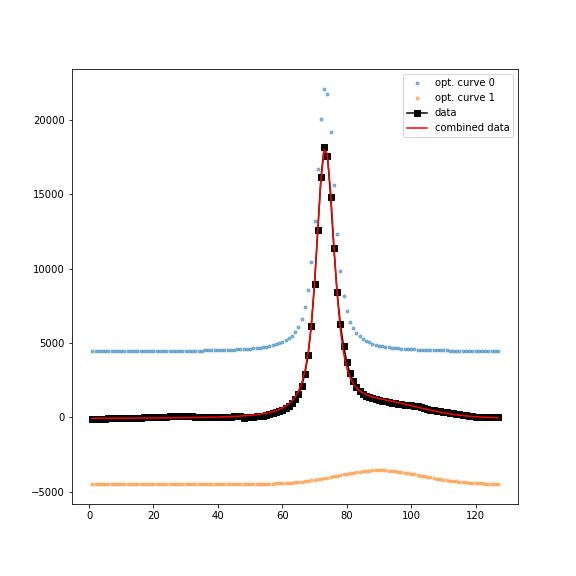 _block1peakAt_136.000.png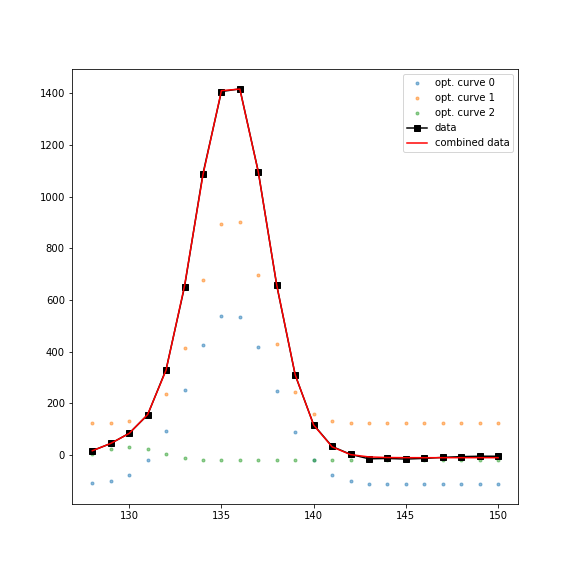 _block2peakAt_170.000.png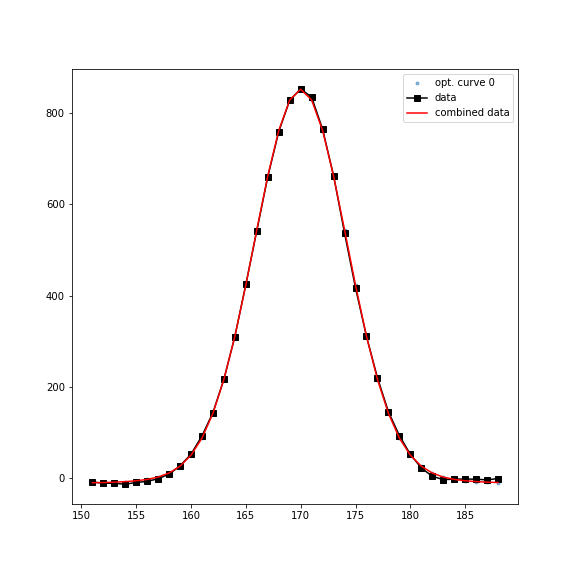

## Stop condition with Chebyshev subtraction 

The purpose of this comparison is to check the effect of background subtraction on the robustness of peak-finding.

In [258]:
y_fsub_stop_cheb = fit_curves(patterns[i], 
                         noise_estimate = fast_T.T[i], stdratio_threshold = 2)

numBlocks: 414, dataPts/Block: 1.4444444444444444
[  0. 128. 151. 189. 224. 255. 298. 339. 365. 405. 438. 477. 524. 551.
 583. 597.]
Experimental Info used: 

{'blockBounds': array([  0., 128., 151., 189., 224., 255., 298., 339., 365., 405., 438.,
       477., 524., 551., 583., 597.])}
Peak at 73, start iteration with error = 0.9477578430819944
Peak at 73, iteration 0: error = 5.419372690178083
17.148812836886528
Peak at 73, iteration 1: error = 5.46637398681453
17.147597525429006
Peak at 73, iteration 2: error = 5.466373617769352
    ----Saving data for block between 1.00 - 127.00
Peak at 135, start iteration with error = 0.0682417486363587
Peak at 135, iteration 0: error = 0.9314728913059315
1754.7502432231522
Peak at 135, iteration 1: error = 0.004943885222143594
14.017151778091094
Peak at 135, iteration 2: error = 0.0034453079664042803
    ----Saving data for block between 128.00 - 150.00
Peak at 170, start iteration with error = 0.04774299085962311
Peak at 170, iteration 0: error 

_block0peakAt_73.000.png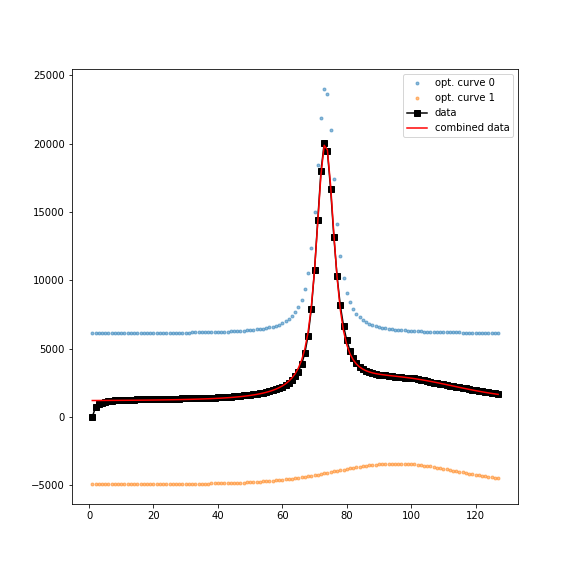 _block1peakAt_135.000.png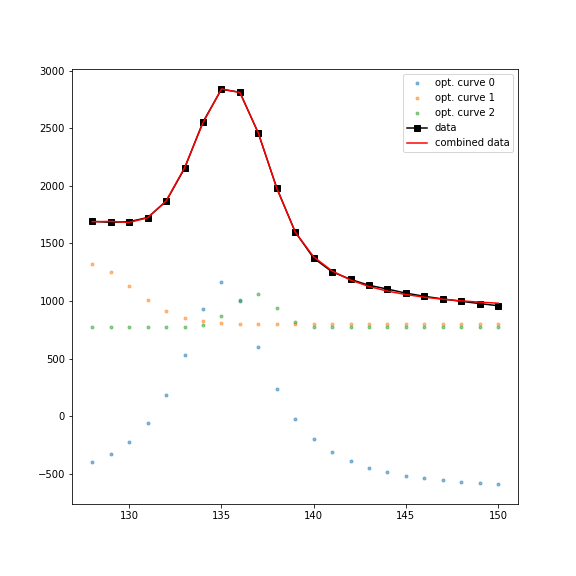 _block2peakAt_170.000.png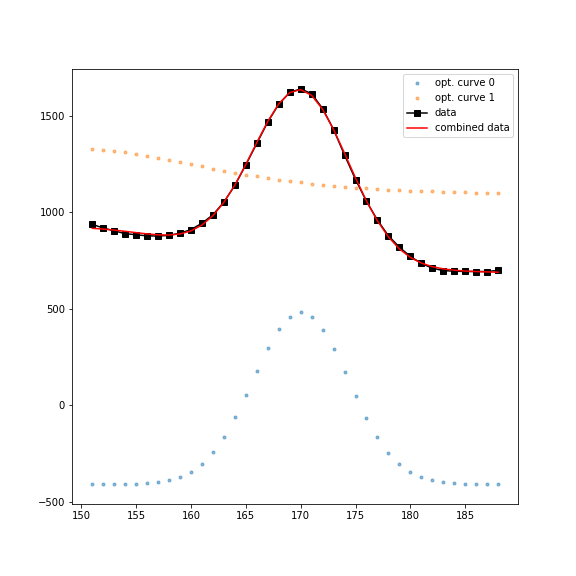

In [256]:
y_fsub_stop_cheb.shape

(598,)

In [397]:
fast_T.shape

(60, 598)

In [398]:
fsub_stop_2d = curvefit_2d(patterns, background = background,
                         noise_estimate = fast_T, stdratio_threshold = 2)

numBlocks: 358, dataPts/Block: 1.670391061452514
[  0.  35. 127. 183. 230. 263. 297. 342. 408. 430. 448. 501. 512. 539.
 567. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  35., 127., 183., 230., 263., 297., 342., 408., 430., 448.,
       501., 512., 539., 567., 597.])}
Peak at 1, start iteration with error = 0.30331701532722166
Peak at 1, iteration 0: error = 0.6919530324721228
0.5129178191896026
    ----Saving data for block between 1.00 - 34.00
Peak at 71, start iteration with error = 0.6747103591996849
Peak at 71, iteration 0: error = 1.1001737182528977
0.43048179374991885
    ----Saving data for block between 35.00 - 126.00
Peak at 132, start iteration with error = 0.7445823021466336
Peak at 132, iteration 0: error = 0.1654188995501884
0.13762815970815598
    ----Saving data for block between 127.00 - 182.00
Peak at 223, start iteration with error = 0.7454547636466078
Peak at 223, iteration 0: error = 0.21903342218911023
0.0372173556145643
    ----Saving data for bl

    ----Saving data for block between 35.00 - 126.00
Peak at 132, start iteration with error = 0.9335408661113903
Peak at 132, iteration 0: error = 0.9983701633737037
3.48614731738564
Peak at 132, iteration 1: error = 0.9539218700768914
3.48429269691039
Peak at 132, iteration 2: error = 0.9538536495345655
    ----Saving data for block between 127.00 - 182.00
Peak at 223, start iteration with error = 0.7350162763577927
Peak at 223, iteration 0: error = 0.22365066259489041
2.920164513492498
Peak at 223, iteration 1: error = 0.1166073316654119
1.4095693743239688
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 183.00 - 229.00
Peak at 235, start iteration with error = 0.6727651840599324
Peak at 235, iteration 0: error = 0.2970979331785573
6.1724337193828305
Peak at 235, iteration 1: error = 0.12496399784026835
3.52387300515049
Peak at 235, iteration 2: error = 0.12574602611784394
Optimal parameters not found: The ma

Peak at 522, start iteration with error = 0.6503300188739655
Peak at 522, iteration 0: error = 0.2282349845661784
57.59698756596687
Peak at 522, iteration 1: error = 0.19814379674749247
20.921662092750864
Peak at 522, iteration 2: error = 0.22668932766790026
    ----Saving data for block between 514.00 - 543.00
Peak at 554, start iteration with error = 0.6935291575151377
Peak at 554, iteration 0: error = 0.24064104015229038
24.703625609655646
Peak at 554, iteration 1: error = 0.05540907229847671
4.742818980253701
Peak at 554, iteration 2: error = 0.058886062629907136
    ----Saving data for block between 544.00 - 566.00
Peak at 572, start iteration with error = 0.3289053754426885
Peak at 572, iteration 0: error = 0.6594172011969078
23.800451878782024
Peak at 572, iteration 1: error = 0.03629446615253253
1.6563435027301892
    ----Saving data for block between 567.00 - 596.00
numBlocks: 362, dataPts/Block: 1.6519337016574585
[  0.  34. 128. 183. 229. 263. 303. 340. 407. 430. 448. 500. 5

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 500.00 - 510.00
Peak at 522, start iteration with error = 0.6576532296735205
Peak at 522, iteration 0: error = 0.22581262145594475
50.1399194302781
Peak at 522, iteration 1: error = 0.14259210738701003
23.569730069754044
Peak at 522, iteration 2: error = 0.09354659704784285
    ----Saving data for block between 511.00 - 543.00
Peak at 554, start iteration with error = 0.6845296343398884
Peak at 554, iteration 0: error = 0.25557807161345264
19.66317398787485
Peak at 554, iteration 1: error = 0.056489688964141395
6.384477011360313
Peak at 554, iteration 2: error = 0.058100595412185554
    ----Saving data for block between 544.00 - 566.00
Peak at 572, start iteration with error = 0.2989905689839521
Peak at 572, iteration 0: error = 0.6907676929954756
44.77921692678281
Peak at 572, iteration 1: error = 0.032493038380995036
2.690989229596795
Peak at 572, iteration 2: error = 0.03094682734144764
    ----Saving data for block between 567.00 - 596.00
numBl

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 500.00 - 509.00
Peak at 522, start iteration with error = 0.741258636636133
Peak at 522, iteration 0: error = 0.26032063718937837
51.31314238142359
Peak at 522, iteration 1: error = 0.1859227805620048
24.775736696983966
Peak at 522, iteration 2: error = 0.11692843505131797
    ----Saving data for block between 510.00 - 537.00
Peak at 554, start iteration with error = 0.6110700484912672
Peak at 554, iteration 0: error = 0.3558826779976294
13.093825544557358
Peak at 554, iteration 1: error = 0.1330472921887315
5.024979182874208
Peak at 554, iteration 2: error = 0.14116156695130302
    ----Saving data for block between 538.00 - 562.00
Peak at 572, start iteration with error = 0.30762609591661993
Peak at 572, iteration 0: error = 0.6463451135930389
25.85274198488026
Peak at 572, iteration 1: error = 0.07777219097820647
3.5596893598665105
Peak at 572, iteration 2: error = 0.07534542281800705
    ----Saving data for block between 563.00 - 596.00
numBlock

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 522, start iteration with error = 0.699037447797388
Peak at 522, iteration 0: error = 0.22858443446209942
54.21754647134237
Peak at 522, iteration 1: error = 0.18447618709403057
33.164223435992575
Peak at 522, iteration 2: error = 0.11667417003139513
    ----Saving data for block between 510.00 - 542.00
Peak at 553, start iteration with error = 0.7050851339332366
Peak at 553, iteration 0: error = 0.2591799412937476
23.357973307887082
Peak at 553, iteration 1: error = 0.14533390171520055
9.973127380334008
Peak at 553, iteration 2: error = 0.07830184394560162
    ----Saving data for block between 543.00 - 566.00
Peak at 572, start iteration with error = 0.2932944253477597
Peak at 572, iteration 0: error = 0.6929874583825733
28.057549542404217
Peak at 572, iteration 1: error = 0.040195534030420484
2.718686525078657
Peak at 572, iteration 2: error = 0.04019553403199325
    ----Saving data for block between 567.00 - 596.00
numBlocks: 366, dataPts/Block: 1.633879781420765
[  0.  35. 

Peak at 311, start iteration with error = 0.36578702013791453
Peak at 311, iteration 0: error = 0.6121899483820735
8.73858759361394
Peak at 311, iteration 1: error = 0.09139171047106852
2.016342936110895
Peak at 311, iteration 2: error = 0.09139171079285856
    ----Saving data for block between 297.00 - 351.00
Peak at 383, start iteration with error = 0.4785488656757049
Peak at 383, iteration 0: error = 0.4782681559196431
6.07669587091069
Peak at 383, iteration 1: error = 0.16850372242312114
2.8070706843212103
Peak at 383, iteration 2: error = 0.16307254945165206
    ----Saving data for block between 352.00 - 405.00
Peak at 423, start iteration with error = 0.6761134185273199
Peak at 423, iteration 0: error = 0.33834096320463114
7.003522316166718
Peak at 423, iteration 1: error = 0.13355017098755692
4.482732098793373
Peak at 423, iteration 2: error = 0.229478249116851
    ----Saving data for block between 406.00 - 428.00
Peak at 438, start iteration with error = 0.5883411589786623
Peak

    ----Saving data for block between 1.00 - 33.00
Peak at 70, start iteration with error = 0.9714111352166998
Peak at 70, iteration 0: error = 3.6260870989160536
5.248168973307494
Peak at 70, iteration 1: error = 3.0465426997846374
4.4500230574419986
Peak at 70, iteration 2: error = 3.046542699756747
    ----Saving data for block between 34.00 - 129.00
Peak at 137, start iteration with error = 0.9286537444551827
Peak at 137, iteration 0: error = 1.0108814662195544
2.130503275285297
Peak at 137, iteration 1: error = 0.9312570454364917
1.77581546775827
    ----Saving data for block between 130.00 - 192.00
Peak at 222, start iteration with error = 0.6690450387513415
Peak at 222, iteration 0: error = 0.1877958220893019
3.0762454070750436
Peak at 222, iteration 1: error = 0.07800271326184242
1.04911423642324
    ----Saving data for block between 193.00 - 226.00
Peak at 234, start iteration with error = 0.6673723230985928
Peak at 234, iteration 0: error = 0.34888429173287205
30.223949378574

Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 496.00 - 510.00
Peak at 521, start iteration with error = 0.7493568211955512
Peak at 521, iteration 0: error = 0.21884256542292516
26.69461295033207
Peak at 521, iteration 1: error = 0.19396873549264484
15.931601885931693
Peak at 521, iteration 2: error = 0.29297288018946527
    ----Saving data for block between 511.00 - 540.00
Peak at 552, start iteration with error = 0.7818130151989806
Peak at 552, iteration 0: error = 0.18471603178617296
10.330890438566572
Peak at 552, iteration 1: error = 0.05896349488994399
4.02003223328934
Peak at 552, iteration 2: error = 0.051696650330636786
    ----Saving data for block between 541.00 - 560.00
Peak at 570, start iteration with error = 0.38966996878022403
Peak at 570, iteration 0: error = 0.4749963706967143
21.76739325663353
Peak at 570, iteration 1: error = 0.18281317950865694
5.885788199422878
Peak at 570, iteration 2: e

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 496.00 - 505.00
Peak at 520, start iteration with error = 0.7198436482456949
Peak at 520, iteration 0: error = 0.28691365138679537
26.69427725950673
Peak at 520, iteration 1: error = 0.22190548186656914
14.952187929668943
Peak at 520, iteration 2: error = 0.10748930268041824
    ----Saving data for block between 506.00 - 540.00
Peak at 551, start iteration with error = 0.7862378101461024
Peak at 551, iteration 0: error = 0.15530978549813979
11.296845187153743
Peak at 551, iteration 1: error = 0.04776864846875877
3.5013517883601017
Peak at 551, iteration 2: error = 0.060394251687465414
    ----Saving data for block between 541.00 - 560.00
Peak at 569, start iteration with error = 0.3422420089232891
Peak at 569, iteration 0: error = 0.5832570639664644
23.14668744909983
Peak at 569, iteration 1: error = 0.12947632991148042
5.1548231873799875
Peak at 569, iteration 2: error = 0.12887068737993704
    ----Saving data for block between 561.00 - 596.00
num

    ----Saving data for block between 301.00 - 349.00
Peak at 380, start iteration with error = 0.6999805157368626
Peak at 380, iteration 0: error = 0.3193247844559956
7.022457585839656
Peak at 380, iteration 1: error = 0.3481273341595581
5.5259927176664565
Peak at 380, iteration 2: error = 0.3481273351078943
    ----Saving data for block between 350.00 - 403.00
Peak at 420, start iteration with error = 0.7848668006311481
Peak at 420, iteration 0: error = 0.22288549810320885
12.517904247077212
Peak at 420, iteration 1: error = 0.37359193859901424
6.815188519867735
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 420, iteration 2: error = 0.17822325675893053
    ----Saving data for block between 404.00 - 425.00
Peak at 437, start iteration with error = 0.5692542548249937
Peak at 437, iteration 0: error = 0.4012802155512073
36.426334304045376
Peak at 437, iteration 1: error = 0.06869253546825442
5.705977914446623
Peak at 437, iteration 2: erro

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 495.00 - 505.00
Peak at 520, start iteration with error = 0.7800430694934364
Peak at 520, iteration 0: error = 0.37224715655846
27.449319515977933
Peak at 520, iteration 1: error = 0.25501427807047194
17.686480940765293
Peak at 520, iteration 2: error = 0.28499654876209346
    ----Saving data for block between 506.00 - 539.00
Peak at 551, start iteration with error = 0.817501990817913
Peak at 551, iteration 0: error = 0.2674927463043377
8.915010513304695
Peak at 551, iteration 1: error = 0.15462787167496211
5.105270419102745
Peak at 551, iteration 2: error = 0.12442113046288604
    ----Saving data for block between 540.00 - 564.00
Peak at 569, start iteration with error = 0.4077910780257634
Peak at 569, iteration 0: error = 0.5454353481417252
3.2109578644350716
Peak at 569, iteration 1: error = 0.0756344911238575
0.8732270305046687
    ----Saving data for block between 565.00 - 596.00
numBlocks: 373, dataPts/Block: 1.6032171581769437
[  0.  33. 130

Peak at 420, start iteration with error = 0.7319780545484272
Peak at 420, iteration 0: error = 0.2902675313101991
9.773359115346128
Peak at 420, iteration 1: error = 0.12406215671564622
5.91227491516372
Peak at 420, iteration 2: error = 0.18492678917480151
    ----Saving data for block between 405.00 - 425.00
Peak at 436, start iteration with error = 0.5468275389179349
Peak at 436, iteration 0: error = 0.4053078995350662
30.220106069994067
Peak at 436, iteration 1: error = 0.058652164920296054
5.19981297341841
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 436, iteration 2: error = 0.49385458388340553
    ----Saving data for block between 426.00 - 448.00
Peak at 458, start iteration with error = 0.3998095721860708
Peak at 458, iteration 0: error = 0.5539620576514029
10.561693411918155
Peak at 458, iteration 1: error = 0.2949337792484202
4.5482414035901
Peak at 458, iteration 2: error = 0.2949337792300927
    ----Saving data for block betwe

Peak at 308, start iteration with error = 0.20856674082133125
Peak at 308, iteration 0: error = 0.7830954688808651
29.825758436808975
Peak at 308, iteration 1: error = 0.03355862999229244
2.0445767615101955
Peak at 308, iteration 2: error = 0.0335586299884278
    ----Saving data for block between 301.00 - 347.00
Peak at 380, start iteration with error = 0.32308929780132045
Peak at 380, iteration 0: error = 0.6540268554354564
28.416515198671384
Peak at 380, iteration 1: error = 0.08776789051969125
6.400876862633636
Peak at 380, iteration 2: error = 0.08776788956408992
    ----Saving data for block between 348.00 - 404.00
Peak at 419, start iteration with error = 0.6652294197135141
Peak at 419, iteration 0: error = 0.39572010372542454
35.76815221163407
Peak at 419, iteration 1: error = 0.3404277847386907
16.009153783222807
Peak at 419, iteration 2: error = 0.11267225449995907
    ----Saving data for block between 405.00 - 426.00
Peak at 436, start iteration with error = 0.511247897530495

    ----Saving data for block between 227.00 - 259.00
Peak at 278, start iteration with error = 0.5149619890293953
Peak at 278, iteration 0: error = 0.4748621484452255
10.022730937689305
Peak at 278, iteration 1: error = 0.0916729713595037
3.3655345773069683
Peak at 278, iteration 2: error = 0.09167302306382247
    ----Saving data for block between 260.00 - 300.00
Peak at 308, start iteration with error = 0.16476507541745788
Peak at 308, iteration 0: error = 0.8313955012504847
30.645546577144554
Peak at 308, iteration 1: error = 0.015791379127375323
1.0526654986118813
    ----Saving data for block between 301.00 - 346.00
Peak at 380, start iteration with error = 0.2589078438148884
Peak at 380, iteration 0: error = 0.7302159967879444
31.049663322673034
Peak at 380, iteration 1: error = 0.053327114763765004
3.9260007175105556
Peak at 380, iteration 2: error = 0.05332712009407365
    ----Saving data for block between 347.00 - 405.00
Peak at 420, start iteration with error = 0.600662690325

    ----Saving data for block between 32.00 - 125.00
Peak at 136, start iteration with error = 0.18626522145582852
Peak at 136, iteration 0: error = 0.809233259477128
85.90075296702967
Peak at 136, iteration 1: error = 0.0279950942252488
3.3662820273506986
Peak at 136, iteration 2: error = 0.0192982355139028
    ----Saving data for block between 126.00 - 185.00
Peak at 220, start iteration with error = 0.5863295796344967
Peak at 220, iteration 0: error = 0.2336861007330974
21.206084735392956
Peak at 220, iteration 1: error = 0.04580751075213066
6.792131140280352
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 220, iteration 2: error = 0.4181073288151086
    ----Saving data for block between 186.00 - 224.00
Peak at 232, start iteration with error = 0.3835174789786478
Peak at 232, iteration 0: error = 0.5524419437749083
47.95889087126929
Peak at 232, iteration 1: error = 0.2238187809970999
18.122688856496172
Peak at 232, iteration 2: error = 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


numBlocks: 386, dataPts/Block: 1.549222797927461
[  0.  31. 126. 187. 225. 259. 301. 345. 407. 426. 447. 488. 533. 591.
 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  31., 126., 187., 225., 259., 301., 345., 407., 426., 447.,
       488., 533., 591., 597.])}
negative values in background-subtracted pattern. taking absolute value.
Peak at 1, start iteration with error = 0.1479934320264699
Peak at 1, iteration 0: error = 0.8508454781999557
42.47363640514598
Peak at 1, iteration 1: error = 0.009502671082500889
0.6784691289798329
    ----Saving data for block between 1.00 - 30.00
Peak at 70, start iteration with error = 0.9850254923257871
Peak at 70, iteration 0: error = 12.107998444865022
19.673560313713377
Peak at 70, iteration 1: error = 2.9872512371794318
12.861168176864986
Peak at 70, iteration 2: error = 2.987217003357442
    ----Saving data for block between 31.00 - 125.00
Peak at 136, start iteration with error = 0.16131117834213354
Peak at 136, iteration 0: error =

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 591.00 - 596.00
numBlocks: 389, dataPts/Block: 1.5372750642673523
[  0.  30. 129. 163. 187. 226. 259. 295. 343. 407. 426. 447. 488. 532.
 591. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  30., 129., 163., 187., 226., 259., 295., 343., 407., 426.,
       447., 488., 532., 591., 597.])}
negative values in background-subtracted pattern. taking absolute value.
Peak at 1, start iteration with error = 0.13320906723614787
Peak at 1, iteration 0: error = 0.8655297956454941
240.89127584411324
Peak at 1, iteration 1: error = 0.01169019898778607
4.131343280234902
Peak at 1, iteration 2: error = 0.009478085616009718
    ----Saving data for block between 1.00 - 29.00
Peak at 70, start iteration with error = 0.9869879389384154
Peak at 70, iteration 0: error = 10.173730295794964
25.65063295900902
Peak at 70, iteration 1: error = 9.751859189854132
25.604880228583358
Peak at 70, iteration 2: error = 4.264533255381054
    ----Saving data for block b

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


numBlocks: 389, dataPts/Block: 1.5372750642673523
[  0.  16. 129. 163. 187. 226. 259. 301. 342. 407. 441. 487. 532. 590.
 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  16., 129., 163., 187., 226., 259., 301., 342., 407., 441.,
       487., 532., 590., 597.])}
negative values in background-subtracted pattern. taking absolute value.
Peak at 1, start iteration with error = 0.08642328542696044
Peak at 1, iteration 0: error = 0.9125657848948912
111.86378624714331
Peak at 1, iteration 1: error = 0.010987745095276977
1.5719421279652914
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 1.00 - 15.00
Peak at 71, start iteration with error = 0.9889839417397231
Peak at 71, iteration 0: error = 9.359318856160959
29.529410143196152
Peak at 71, iteration 1: error = 9.359318852707359
29.529410143196476
Peak at 71, iteration 2: error = 9.359318852451862
    ----Saving data for block between 16.00 - 128.00
Peak at 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


numBlocks: 392, dataPts/Block: 1.5255102040816326
[  0.  29. 129. 161. 187. 225. 259. 300. 342. 407. 445. 487. 532. 589.
 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  29., 129., 161., 187., 225., 259., 300., 342., 407., 445.,
       487., 532., 589., 597.])}
negative values in background-subtracted pattern. taking absolute value.
Peak at 1, start iteration with error = 0.10535019068027847
Peak at 1, iteration 0: error = 0.8933318542718637
258.52525840123644
Peak at 1, iteration 1: error = 0.01200613003957378
4.103116907612473
Peak at 1, iteration 2: error = 0.008637526861294636
    ----Saving data for block between 1.00 - 28.00
Peak at 71, start iteration with error = 0.9875304888543234
Peak at 71, iteration 0: error = 10.825764958008387
57.33673327681321
Peak at 71, iteration 1: error = 10.82421024911362
57.3367298431127
Peak at 71, iteration 2: error = 10.824011739756902
    ----Saving data for block between 29.00 - 128.00
Peak at 136, start iteration with error = 0.

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 589.00 - 596.00
numBlocks: 387, dataPts/Block: 1.545219638242894
[  0.  27. 129. 160. 188. 226. 259. 300. 341. 407. 444. 486. 532. 552.
 589. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  27., 129., 160., 188., 226., 259., 300., 341., 407., 444.,
       486., 532., 552., 589., 597.])}
negative values in background-subtracted pattern. taking absolute value.
Peak at 1, start iteration with error = 0.16212482969525263
Peak at 1, iteration 0: error = 0.834890984554613
142.227398147994
Peak at 1, iteration 1: error = 0.025384724532839124
4.859841217096335
Peak at 1, iteration 2: error = 0.019243382858671967
    ----Saving data for block between 1.00 - 26.00
Peak at 72, start iteration with error = 0.9870376368121603
Peak at 72, iteration 0: error = 7.048795072809542
30.284006275439197
Peak at 72, iteration 1: error = 3.276977194766134
22.753679770588775
Peak at 72, iteration 2: error = 3.2769771947680444
    ----Saving data for block bet

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


numBlocks: 388, dataPts/Block: 1.541237113402062
[  0.  27. 129. 160. 188. 224. 259. 299. 342. 407. 443. 486. 532. 555.
 588. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  27., 129., 160., 188., 224., 259., 299., 342., 407., 443.,
       486., 532., 555., 588., 597.])}
negative values in background-subtracted pattern. taking absolute value.
Peak at 1, start iteration with error = 0.17911666475209073
Peak at 1, iteration 0: error = 0.8166109758879172
87.89338098626543
Peak at 1, iteration 1: error = 0.0336125146731896
4.1158163493371465
Peak at 1, iteration 2: error = 0.025868840974004582
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 1.00 - 26.00
Peak at 72, start iteration with error = 0.9874196725217054
Peak at 72, iteration 0: error = 6.482548438675949
73.58356890002648
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 72, iteration 1: error = 6.56

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 588.00 - 596.00
numBlocks: 399, dataPts/Block: 1.4987468671679198
[  0.  22. 125. 159. 188. 225. 258. 299. 341. 356. 407. 439. 486. 531.
 554. 588. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  22., 125., 159., 188., 225., 258., 299., 341., 356., 407.,
       439., 486., 531., 554., 588., 597.])}
negative values in background-subtracted pattern. taking absolute value.
Peak at 1, start iteration with error = 0.212871700115475
Peak at 1, iteration 0: error = 0.7817940723905294
110.54703265323184
Peak at 1, iteration 1: error = 0.03174181805837535
5.992362875139462
Peak at 1, iteration 2: error = 0.032495029137798385
    ----Saving data for block between 1.00 - 21.00
Peak at 72, start iteration with error = 0.9409197143258052
Peak at 72, iteration 0: error = 1.3639248582901031
54.42812140814878
Peak at 72, iteration 1: error = 0.8136521967853154
43.49136519292022
Peak at 72, iteration 2: error = 0.3591143673723775
    ----Saving data f

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


numBlocks: 398, dataPts/Block: 1.5025125628140703
[  0.   4. 125. 159. 188. 224. 258. 299. 341. 355. 407. 441. 486. 531.
 553. 588. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,   4., 125., 159., 188., 224., 258., 299., 341., 355., 407.,
       441., 486., 531., 553., 588., 597.])}
negative values in background-subtracted pattern. taking absolute value.
Peak at 1, start iteration with error = 0.03337123178119795


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 1, iteration 0: error = 0.9641422241779362
53.890369800900864
Peak at 1, iteration 1: error = 0.0006452140425019277
0.04338999127518245
    ----Saving data for block between 1.00 - 3.00
Peak at 73, start iteration with error = 0.9229095607416161
Peak at 73, iteration 0: error = 1.392498309666234
29.33836235929486
Peak at 73, iteration 1: error = 1.111938129133554
25.118723108355763
Peak at 73, iteration 2: error = 0.7690527611400549
    ----Saving data for block between 4.00 - 124.00
Peak at 136, start iteration with error = 0.9096681360381332
Peak at 136, iteration 0: error = 0.6339222886751963
2.7914924097404725
Peak at 136, iteration 1: error = 0.46356500084175967
2.214443328576878
Peak at 136, iteration 2: error = 0.26473490775917674
    ----Saving data for block between 125.00 - 158.00
Peak at 170, start iteration with error = 0.6999486368500127
Peak at 170, iteration 0: error = 0.2676549524857384
5.7401542245593244
Peak at 170, iteration 1: error = 0.10210265418119803
1.7

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 588.00 - 596.00
numBlocks: 402, dataPts/Block: 1.4875621890547264
[  0. 125. 159. 188. 225. 257. 298. 340. 356. 406. 441. 485. 531. 550.
 586. 597.]
Experimental Info used: 

{'blockBounds': array([  0., 125., 159., 188., 225., 257., 298., 340., 356., 406., 441.,
       485., 531., 550., 586., 597.])}
negative values in background-subtracted pattern. taking absolute value.
Peak at 73, start iteration with error = 0.9878582240926512
Peak at 73, iteration 0: error = 4.432266224329333
20.838100435116505
Peak at 73, iteration 1: error = 3.085023497830794
17.759094468941907
Peak at 73, iteration 2: error = 1.7264105410812585
    ----Saving data for block between 1.00 - 124.00
Peak at 136, start iteration with error = 0.594929943800385
Peak at 136, iteration 0: error = 0.34110260954322086
4.410721447198965
Peak at 136, iteration 1: error = 0.17394773759187102
2.145474452226775
Peak at 136, iteration 2: error = 0.12188175117302882
    ----Saving data for 

Peak at 543, start iteration with error = 0.6293789917760277
Peak at 543, iteration 0: error = 0.34630414929841963
2.1821261976802613
Peak at 543, iteration 1: error = 0.06083663761896257
0.6002012087742589
    ----Saving data for block between 524.00 - 551.00
Peak at 560, start iteration with error = 0.5804600336717872
Peak at 560, iteration 0: error = 0.40117557756456174
3.331346239873078
Peak at 560, iteration 1: error = 0.07347373535287283
0.624391398854379
    ----Saving data for block between 552.00 - 584.00
Peak at 596, start iteration with error = 0.39982478902723956
Peak at 596, iteration 0: error = 0.5852629374370518
66.63155781296511
Peak at 596, iteration 1: error = 0.05061525011763069
6.066070884455431
Peak at 596, iteration 2: error = 0.020200652373243644


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 585.00 - 596.00
numBlocks: 414, dataPts/Block: 1.4444444444444444
[  0. 128. 151. 189. 224. 255. 298. 339. 365. 405. 438. 477. 524. 551.
 583. 597.]
Experimental Info used: 

{'blockBounds': array([  0., 128., 151., 189., 224., 255., 298., 339., 365., 405., 438.,
       477., 524., 551., 583., 597.])}
negative values in background-subtracted pattern. taking absolute value.
Peak at 73, start iteration with error = 0.979749579615024
Peak at 73, iteration 0: error = 2.638738564292161
2.756418865456757
Peak at 73, iteration 1: error = 1.970961892849835
2.4139115777325726
Peak at 73, iteration 2: error = 1.6598499568160974
    ----Saving data for block between 1.00 - 127.00
Peak at 136, start iteration with error = 0.5880598146059716
Peak at 136, iteration 0: error = 0.3807826460981473
17.782117667294543
Peak at 136, iteration 1: error = 0.30652803657664457
11.3461985107329
Peak at 136, iteration 2: error = 0.3581938789815956
    ----Saving data for blo

Peak at 540, start iteration with error = 0.6355125625571091
Peak at 540, iteration 0: error = 0.361592697776985
4.592312432748573
Peak at 540, iteration 1: error = 0.009751896889940293
0.22892685281043493
    ----Saving data for block between 528.00 - 546.00
Peak at 559, start iteration with error = 0.5552972133818036
Peak at 559, iteration 0: error = 0.3939078111788447
6.757166504771821
Peak at 559, iteration 1: error = 0.07668890384013703
1.2050142651187767
    ----Saving data for block between 547.00 - 580.00
Peak at 596, start iteration with error = 0.3813566862871829
Peak at 596, iteration 0: error = 0.6026891010425647
16.856491282407646
Peak at 596, iteration 1: error = 0.07407357535685549
2.166747635201052
Peak at 596, iteration 2: error = 0.02431187248671498
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 581.00 - 596.00
numBlocks: 421, dataPts/Block: 1.4204275534441806
[  0. 128. 157. 188. 221. 254. 2

Peak at 423, start iteration with error = 0.7049670912674021
Peak at 423, iteration 0: error = 0.33755607436357415
3.2969326260831373
Peak at 423, iteration 1: error = 0.3179936177225778
1.5521389501255844
    ----Saving data for block between 402.00 - 431.00
Peak at 446, start iteration with error = 0.494058466129612
Peak at 446, iteration 0: error = 0.438594765347741
8.096267625342705
Peak at 446, iteration 1: error = 0.07740263582809892
1.5407829662204227
    ----Saving data for block between 432.00 - 469.00
Peak at 481, start iteration with error = 0.06328193176928233
Peak at 481, iteration 0: error = 0.9318561188670442
12.995451629934042
Peak at 481, iteration 1: error = 0.005676990298877808
0.10959700545245946
    ----Saving data for block between 470.00 - 487.00
Peak at 509, start iteration with error = 0.6945056916315889
Peak at 509, iteration 0: error = 0.3862039332658273
14.531275243068505
Peak at 509, iteration 1: error = 0.21543638194373663
5.47262629173017
Peak at 509, ite

Peak at 226, start iteration with error = 0.37496550199762596
Peak at 226, iteration 0: error = 0.6095673268329289
23.44778670311089
Peak at 226, iteration 1: error = 0.2839499794891401
9.642964388933766
Peak at 226, iteration 2: error = 0.283949979236849
    ----Saving data for block between 220.00 - 252.00
Peak at 274, start iteration with error = 0.472115091771733
Peak at 274, iteration 0: error = 0.5238849844815506
4.215095618909571
Peak at 274, iteration 1: error = 0.059396958496831014
1.700619592571566
    ----Saving data for block between 253.00 - 295.00
Peak at 306, start iteration with error = 0.26447261143008516
Peak at 306, iteration 0: error = 0.7320646978623014
46.532807944451775
Peak at 306, iteration 1: error = 0.014525781501507759
1.0584140528332961
    ----Saving data for block between 296.00 - 330.00
Peak at 352, start iteration with error = 0.3480920089735329
Peak at 352, iteration 0: error = 0.6489103055547518
50.76459804201253
Peak at 352, iteration 1: error = 0.01

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 584.00 - 596.00
numBlocks: 409, dataPts/Block: 1.4621026894865525
[  0. 128. 156. 187. 219. 254. 289. 328. 363. 400. 434. 468. 487. 519.
 544. 572. 584. 597.]
Experimental Info used: 

{'blockBounds': array([  0., 128., 156., 187., 219., 254., 289., 328., 363., 400., 434.,
       468., 487., 519., 544., 572., 584., 597.])}
negative values in background-subtracted pattern. taking absolute value.
Peak at 72, start iteration with error = 0.9870091878633522
Peak at 72, iteration 0: error = 2.0147972682161392
6.668964335000008
Peak at 72, iteration 1: error = 1.5808713190867023
6.309813133067786
Peak at 72, iteration 2: error = 1.5808014627514344
    ----Saving data for block between 1.00 - 127.00
Peak at 135, start iteration with error = 0.2644829517434878
Peak at 135, iteration 0: error = 0.7321412427787728
59.27510666136971
Peak at 135, iteration 1: error = 0.012935763809742854
1.264053838873038
    ----Saving data for block between 128.00 - 155.00
P

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 572.00 - 583.00
Peak at 596, start iteration with error = 0.24178976056044166
Peak at 596, iteration 0: error = 0.7504772002888879
286.6306484306917
Peak at 596, iteration 1: error = 0.03752924223269629
19.300412411821128
Peak at 596, iteration 2: error = 0.027014447851685826


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 584.00 - 596.00
numBlocks: 412, dataPts/Block: 1.4514563106796117
[  0. 128. 156. 187. 219. 254. 288. 326. 358. 400. 433. 468. 483. 523.
 544. 572. 588. 597.]
Experimental Info used: 

{'blockBounds': array([  0., 128., 156., 187., 219., 254., 288., 326., 358., 400., 433.,
       468., 483., 523., 544., 572., 588., 597.])}
negative values in background-subtracted pattern. taking absolute value.
Peak at 72, start iteration with error = 0.9846293694030808
Peak at 72, iteration 0: error = 2.9119579014169177
7.7039866197902676
Peak at 72, iteration 1: error = 2.131119459456277
6.99399856908362
Peak at 72, iteration 2: error = 1.945620361482598
    ----Saving data for block between 1.00 - 127.00
Peak at 135, start iteration with error = 0.2484246974383311
Peak at 135, iteration 0: error = 0.7484915967470153
48.42733866745781
Peak at 135, iteration 1: error = 0.012115837391145402
0.9852311541527994
    ----Saving data for block between 128.00 - 155.00
Pe

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 588.00 - 596.00
numBlocks: 414, dataPts/Block: 1.4444444444444444
[  0. 125. 156. 188. 219. 254. 295. 330. 362. 399. 430. 468. 483. 519.
 543. 572. 585. 597.]
Experimental Info used: 

{'blockBounds': array([  0., 125., 156., 188., 219., 254., 295., 330., 362., 399., 430.,
       468., 483., 519., 543., 572., 585., 597.])}
negative values in background-subtracted pattern. taking absolute value.
Peak at 72, start iteration with error = 0.9868468686062052
Peak at 72, iteration 0: error = 2.6265013809212925
27.7805107113602
Peak at 72, iteration 1: error = 1.8766407639826257
21.50702600258328
Peak at 72, iteration 2: error = 1.6031586185706772
    ----Saving data for block between 1.00 - 124.00
Peak at 135, start iteration with error = 0.23408346874421773
Peak at 135, iteration 0: error = 0.7628989346535736
117.32005500283334
Peak at 135, iteration 1: error = 0.012943696404059681
2.349292050194912
Peak at 135, iteration 2: error = 0.008391888858785066

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 468.00 - 482.00
Peak at 501, start iteration with error = 0.5219982040139727
Peak at 501, iteration 0: error = 0.45415902252841434
96.34323161386124
Peak at 501, iteration 1: error = 0.2103483239297781
33.9342237730463
Peak at 501, iteration 2: error = 0.14076708472770705
    ----Saving data for block between 483.00 - 518.00
Peak at 533, start iteration with error = 0.3725611200541075
Peak at 533, iteration 0: error = 0.6237854728343107
84.13749296318449
Peak at 533, iteration 1: error = 0.026320427067602622
4.4948814853768
Peak at 533, iteration 2: error = 0.02301735537976925
    ----Saving data for block between 519.00 - 542.00
Peak at 553, start iteration with error = 0.40831352478934607
Peak at 553, iteration 0: error = 0.586387871788345
111.06221212773038
Peak at 553, iteration 1: error = 0.024384292553881335
5.142031070362286
Peak at 553, iteration 2: error = 0.014833923074538548
    ----Saving data for block between 543.00 - 571.00
Peak at 5

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 585.00 - 596.00
numBlocks: 412, dataPts/Block: 1.4514563106796117
[  0.  88. 125. 156. 188. 219. 254. 295. 330. 358. 399. 430. 468. 483.
 519. 540. 571. 585. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  88., 125., 156., 188., 219., 254., 295., 330., 358., 399.,
       430., 468., 483., 519., 540., 571., 585., 597.])}
negative values in background-subtracted pattern. taking absolute value.
Peak at 72, start iteration with error = 0.9833511836074738
Peak at 72, iteration 0: error = 3.253693880191994
14.846788914042213
Peak at 72, iteration 1: error = 3.029609902131579
13.599307619918964
Peak at 72, iteration 2: error = 2.8606574792090864
    ----Saving data for block between 1.00 - 87.00
Peak at 92, start iteration with error = 0.12286620094702871
Peak at 92, iteration 0: error = 0.8742369853850666
153.1584689205358
Peak at 92, iteration 1: error = 0.007286575616104479
1.6373351518373045
    ----Saving data for block between 88.00 - 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 468.00 - 482.00
Peak at 500, start iteration with error = 0.498359916423388
Peak at 500, iteration 0: error = 0.48078331633848026
107.08651086058559
Peak at 500, iteration 1: error = 0.2429431447113709
39.730418357132486
Peak at 500, iteration 2: error = 0.16630229293512377
    ----Saving data for block between 483.00 - 518.00
Peak at 533, start iteration with error = 0.3818831662259613
Peak at 533, iteration 0: error = 0.6153011733236157
78.63053179874991
Peak at 533, iteration 1: error = 0.02230555841071859
3.5030161627700944
Peak at 533, iteration 2: error = 0.013388780629044203
    ----Saving data for block between 519.00 - 539.00
Peak at 552, start iteration with error = 0.38462207323344244
Peak at 552, iteration 0: error = 0.6047213543098409
118.14755700705409
Peak at 552, iteration 1: error = 0.023261901699898346
5.700224223269859
Peak at 552, iteration 2: error = 0.015206508555842527
    ----Saving data for block between 540.00 - 570.00
Pea

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 585.00 - 596.00
numBlocks: 405, dataPts/Block: 1.4765432098765432
[  0.  87. 125. 156. 188. 218. 254. 295. 327. 358. 399. 429. 468. 487.
 514. 543. 571. 584. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  87., 125., 156., 188., 218., 254., 295., 327., 358., 399.,
       429., 468., 487., 514., 543., 571., 584., 597.])}
negative values in background-subtracted pattern. taking absolute value.
Peak at 72, start iteration with error = 0.9838063674981778
Peak at 72, iteration 0: error = 3.3982543723673158
9.58418183334188
Peak at 72, iteration 1: error = 3.1268994932287013
8.79201544541005
Peak at 72, iteration 2: error = 2.502685486282651
    ----Saving data for block between 1.00 - 86.00
Peak at 92, start iteration with error = 0.1360315043815416
Peak at 92, iteration 0: error = 0.8610080622146717
34.31927041628921
Peak at 92, iteration 1: error = 0.011891396545528371
0.5837398327192814
    ----Saving data for block between 87.00 - 124.

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 584.00 - 596.00
numBlocks: 413, dataPts/Block: 1.4479418886198547
[  0.  87. 125. 156. 189. 218. 253. 295. 328. 362. 398. 432. 467. 482.
 522. 542. 571. 587. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  87., 125., 156., 189., 218., 253., 295., 328., 362., 398.,
       432., 467., 482., 522., 542., 571., 587., 597.])}
negative values in background-subtracted pattern. taking absolute value.
Peak at 71, start iteration with error = 0.9830613063309662
Peak at 71, iteration 0: error = 3.6938842042124005
4.229918117975119
Peak at 71, iteration 1: error = 3.3180626389491645
3.7628234937712084
Peak at 71, iteration 2: error = 1.8822111544550908
    ----Saving data for block between 1.00 - 86.00
Peak at 94, start iteration with error = 0.09166563121630544
Peak at 94, iteration 0: error = 0.905494283980843
22.629670849180055
Peak at 94, iteration 1: error = 0.008661732277125316
0.260401878770669
    ----Saving data for block between 87.00 - 

/Users/ollie/anaconda3/lib/python3.7/site-packages/dataproc-1.0-py3.7.egg/dataproc/operations/hitp.py:557: IntegrationWarning: The integral is probably divergent, or slowly convergent.


Peak at 304, start iteration with error = 0.2159760905553923
Peak at 304, iteration 0: error = 0.7815644505631075
24.09650150999044
Peak at 304, iteration 1: error = 0.00692921046674422
0.313975416830926
    ----Saving data for block between 295.00 - 327.00
Peak at 351, start iteration with error = 0.27278048149543005
Peak at 351, iteration 0: error = 0.7248561525045433
29.27006140807629
Peak at 351, iteration 1: error = 0.010691161548471865
0.6149632611050397
    ----Saving data for block between 328.00 - 361.00
Peak at 378, start iteration with error = 0.5095999036814285
Peak at 378, iteration 0: error = 0.4857920164912976
10.673810494036074
Peak at 378, iteration 1: error = 0.04949670758832121
1.7106345371161413
    ----Saving data for block between 362.00 - 397.00
Peak at 419, start iteration with error = 0.5457599298183167
Peak at 419, iteration 0: error = 0.4487094208126841
7.419338049977403
Peak at 419, iteration 1: error = 0.044115011699371515
2.083016869635118
Peak at 419, ite

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 587.00 - 596.00
numBlocks: 410, dataPts/Block: 1.4585365853658536
[  0.  85. 124. 156. 188. 218. 253. 295. 327. 362. 398. 429. 467. 486.
 513. 542. 570. 584. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  85., 124., 156., 188., 218., 253., 295., 327., 362., 398.,
       429., 467., 486., 513., 542., 570., 584., 597.])}
negative values in background-subtracted pattern. taking absolute value.
Peak at 71, start iteration with error = 0.9831026671325367
Peak at 71, iteration 0: error = 3.891269334177507
3.3549793881543253
Peak at 71, iteration 1: error = 3.4734458940537793
2.976339422004927
Peak at 71, iteration 2: error = 1.6871856253222974
    ----Saving data for block between 1.00 - 84.00
Peak at 96, start iteration with error = 0.07541327768003706
Peak at 96, iteration 0: error = 0.9216638921044602
35.827564938632676
Peak at 96, iteration 1: error = 0.010089213265593958
0.4902633937856608
    ----Saving data for block between 85.00 -

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 584.00 - 596.00
numBlocks: 410, dataPts/Block: 1.4585365853658536
[  0.  84. 124. 156. 189. 218. 252. 288. 326. 361. 397. 428. 466. 481.
 517. 541. 569. 586. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  84., 124., 156., 189., 218., 252., 288., 326., 361., 397.,
       428., 466., 481., 517., 541., 569., 586., 597.])}
negative values in background-subtracted pattern. taking absolute value.
Peak at 71, start iteration with error = 0.9834601065032997
Peak at 71, iteration 0: error = 4.151223997512318
2.4150491619577537
Peak at 71, iteration 1: error = 3.7169209523250224
2.15971689877929
Peak at 71, iteration 2: error = 1.8657592133012328
    ----Saving data for block between 1.00 - 83.00
Peak at 96, start iteration with error = 0.06461210882719695
Peak at 96, iteration 0: error = 0.9324512269985192
153.59499930142903
Peak at 96, iteration 1: error = 0.013985800008112555
2.832965732184089
Peak at 96, iteration 2: error = 0.011589502320

Peak at 376, start iteration with error = 0.4807873321311415
Peak at 376, iteration 0: error = 0.5160831802180941
4.708366733014995
Peak at 376, iteration 1: error = 0.03585017906146642
0.8175138586202434
    ----Saving data for block between 361.00 - 395.00
Peak at 417, start iteration with error = 0.5494835464225595
Peak at 417, iteration 0: error = 0.44639200689903424
3.147017231923685
Peak at 417, iteration 1: error = 0.0406111276047649
0.9914495923948177
    ----Saving data for block between 396.00 - 427.00
Peak at 441, start iteration with error = 0.30160306328654757
Peak at 441, iteration 0: error = 0.6806648639836309
26.491036686847043
Peak at 441, iteration 1: error = 0.049512953810996116
2.299046149262451
Peak at 441, iteration 2: error = 0.04566364000081374
    ----Saving data for block between 428.00 - 464.00
Peak at 476, start iteration with error = 0.3170993383236557
Peak at 476, iteration 0: error = 0.6811236693340705
31.575139182629215
Peak at 476, iteration 1: error = 

    ----Saving data for block between 1.00 - 80.00
Peak at 96, start iteration with error = 0.07010778665699881
Peak at 96, iteration 0: error = 0.9270488580101078
45.57613984675613
Peak at 96, iteration 1: error = 0.00995959046260105
0.6477993971040925
    ----Saving data for block between 81.00 - 123.00
Peak at 135, start iteration with error = 0.24165387060914104
Peak at 135, iteration 0: error = 0.7562723157363709
54.029726834923956
Peak at 135, iteration 1: error = 0.010905263856349762
1.2007227888758696
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 124.00 - 148.00
Peak at 166, start iteration with error = 0.3751106342975416
Peak at 166, iteration 0: error = 0.6179962001718552
6.40088512554735
Peak at 166, iteration 1: error = 0.03500271303366202
0.4467016708693215
    ----Saving data for block between 149.00 - 187.00
Peak at 209, start iteration with error = 0.5876565893285303
Peak at 209, iteration 0: 

Peak at 473, start iteration with error = 0.22125377604824575
Peak at 473, iteration 0: error = 0.775908332400726
23.446126055307246
Peak at 473, iteration 1: error = 0.010435900396065803
0.45272740610973355
    ----Saving data for block between 450.00 - 477.00
Peak at 494, start iteration with error = 0.553493892030664
Peak at 494, iteration 0: error = 0.45271286518538767
16.467906906713537
Peak at 494, iteration 1: error = 0.25774093344875926
6.1425604278873775
Peak at 494, iteration 2: error = 0.14536980096962948
    ----Saving data for block between 478.00 - 509.00
Peak at 527, start iteration with error = 0.3883326505701843
Peak at 527, iteration 0: error = 0.6076107357095188
14.43305137560905
Peak at 527, iteration 1: error = 0.026910434831057276
0.9258537805869965
    ----Saving data for block between 510.00 - 534.00
Peak at 545, start iteration with error = 0.3307702648615368
Peak at 545, iteration 0: error = 0.6565158876486237
15.160500356188281
Peak at 545, iteration 1: error

Peak at 135, start iteration with error = 0.4200376799599142
Peak at 135, iteration 0: error = 0.5519814216050267
17.437043907689656
Peak at 135, iteration 1: error = 0.11546645632205621
3.945325650102975
Peak at 135, iteration 2: error = 0.0251826957058264
    ----Saving data for block between 124.00 - 147.00
Peak at 165, start iteration with error = 0.7098792144434684
Peak at 165, iteration 0: error = 0.22157061318756752
5.904336540718489
Peak at 165, iteration 1: error = 0.1215828784573953
2.2277354452992815
Peak at 165, iteration 2: error = 0.09324123309470408
    ----Saving data for block between 148.00 - 174.00
Peak at 185, start iteration with error = 0.5612419184482837
Peak at 185, iteration 0: error = 0.3639500597217995
5.1435386041614946
Peak at 185, iteration 1: error = 0.1233077063884856
1.3352812427958232
    ----Saving data for block between 175.00 - 191.00
Peak at 208, start iteration with error = 0.542887623508446
Peak at 208, iteration 0: error = 0.4325840949525464
6.5

Peak at 384, start iteration with error = 0.15412121862429948
Peak at 384, iteration 0: error = 0.8444751333109525
23.88641761102408
Peak at 384, iteration 1: error = 0.012284300308458434
0.43443682092129193
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 376.00 - 386.00
Peak at 396, start iteration with error = 0.31295169590076155
Peak at 396, iteration 0: error = 0.6817774325552666
28.717548660847765
Peak at 396, iteration 1: error = 0.03380225381644587
1.8435029617761507
    ----Saving data for block between 387.00 - 399.00
Peak at 412, start iteration with error = 0.49697299141766776
Peak at 412, iteration 0: error = 0.4934173245764552
21.121066232113286
Peak at 412, iteration 1: error = 0.051007185735350666
2.4102429344175325
Peak at 412, iteration 2: error = 0.04228976093236213
    ----Saving data for block between 400.00 - 420.00
Peak at 428, start iteration with error = 0.5079557265441814
Peak at 428, i

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 445.00 - 453.00
Peak at 465, start iteration with error = 0.16896724446432196
Peak at 465, iteration 0: error = 0.8265865999617804
32.91665175941602
Peak at 465, iteration 1: error = 0.022346577346413224
1.0790754184334448
    ----Saving data for block between 454.00 - 475.00
Peak at 495, start iteration with error = 0.5067835983481137
Peak at 495, iteration 0: error = 0.48360197018288825
5.997458812912333
Peak at 495, iteration 1: error = 0.032325604342792164
0.47510463314402773
    ----Saving data for block between 476.00 - 509.00
Peak at 522, start iteration with error = 0.5801988662723215
Peak at 522, iteration 0: error = 0.3871350331140199
7.18958289737121
Peak at 522, iteration 1: error = 0.06790057383967596
1.4349863839601602
    ----Saving data for block between 510.00 - 531.00
Peak at 536, start iteration with error = 0.15337289834219442
Peak at 536, iteration 0: error = 0.8423698964024909
23.116399732988526
Peak at 536, iteration 1: error

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 184, start iteration with error = 0.5803692735323207
Peak at 184, iteration 0: error = 0.37685801495665516
4.253729610945452
Peak at 184, iteration 1: error = 0.09534121195208012
1.017773359434273
    ----Saving data for block between 176.00 - 194.00
Peak at 216, start iteration with error = 0.6264542692096013
Peak at 216, iteration 0: error = 0.4117198063623169
2.0578082948220064
Peak at 216, iteration 1: error = 0.1288111910424725
1.1252535269988488
    ----Saving data for block between 195.00 - 224.00
Peak at 229, start iteration with error = 0.39508385128223567
Peak at 229, iteration 0: error = 0.6010705072982314
12.958015258777086
Peak at 229, iteration 1: error = 0.03184614233552496
1.5788012247367325
    ----Saving data for block between 225.00 - 246.00
Peak at 265, start iteration with error = 0.458069108679754
Peak at 265, iteration 0: error = 0.4189208540568931
4.052110335992789
Peak at 265, iteration 1: error = 0.19480932157137096
1.5773119991806008
    ----Saving da

    ----Saving data for block between 311.00 - 335.00
Peak at 351, start iteration with error = 0.3070643456122015
Peak at 351, iteration 0: error = 0.689272134633067
36.90466773904952
Peak at 351, iteration 1: error = 0.025124417023947222
1.8155269458071621
    ----Saving data for block between 336.00 - 355.00
Peak at 367, start iteration with error = 0.3085088616415394
Peak at 367, iteration 0: error = 0.6863421412346937
24.534670675264575
Peak at 367, iteration 1: error = 0.0287164336615382
1.2484955060577345
    ----Saving data for block between 356.00 - 373.00
Peak at 385, start iteration with error = 0.4793367802948254
Peak at 385, iteration 0: error = 0.5196882384543015
22.836753242970524
Peak at 385, iteration 1: error = 0.0023612567811795234
0.1314304357935793
    ----Saving data for block between 374.00 - 386.00
Peak at 395, start iteration with error = 0.3463609378143267
Peak at 395, iteration 0: error = 0.6484746831861812
28.70866033685046
Peak at 395, iteration 1: error = 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 444.00 - 453.00
Peak at 464, start iteration with error = 0.23433429664741426
Peak at 464, iteration 0: error = 0.758259711608567
55.8076560209515
Peak at 464, iteration 1: error = 0.029432933451176976
2.8004478886890096
Peak at 464, iteration 2: error = 0.015196175038297899
    ----Saving data for block between 454.00 - 474.00
Peak at 493, start iteration with error = 0.5542139615478239
Peak at 493, iteration 0: error = 0.44356462744652647
4.231687345685311
Peak at 493, iteration 1: error = 0.03435937803529559
0.47248939959982766
    ----Saving data for block between 475.00 - 504.00
Peak at 518, start iteration with error = 0.652507309402305
Peak at 518, iteration 0: error = 0.3174648641093341
3.6231910199406534
Peak at 518, iteration 1: error = 0.05155834616631383
0.6367987163334754
    ----Saving data for block between 505.00 - 528.00
Peak at 535, start iteration with error = 0.2535771908763417
Peak at 535, iteration 0: error = 0.739103086668774

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 359.00 - 369.00
Peak at 385, start iteration with error = 0.3718635977092631
Peak at 385, iteration 0: error = 0.623604081162362
33.248235910101236
Peak at 385, iteration 1: error = 0.02277371329983193
1.3626659489951993
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 370.00 - 386.00
Peak at 395, start iteration with error = 0.31953760196015535
Peak at 395, iteration 0: error = 0.6713692347788894
29.813632364855767
Peak at 395, iteration 1: error = 0.04248093735237334
2.3865612060506747
Peak at 395, iteration 2: error = 0.024441632126222707
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 387.00 - 395.00
Peak at 406, start iteration with error = 0.6213145040784182
Peak at 406, iteration 0: error = 0.27211763827807967
4.71392262177103
Peak at 406, iteration 1: error = 0.08759754193487446
1.16946649127

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 444.00 - 452.00
Peak at 464, start iteration with error = 0.21381714792740789
Peak at 464, iteration 0: error = 0.778305287551968
58.413253114909004
Peak at 464, iteration 1: error = 0.024969826896760534
2.2422165578386513
Peak at 464, iteration 2: error = 0.019738211409109703
    ----Saving data for block between 453.00 - 473.00
Peak at 491, start iteration with error = 0.5767766758231291
Peak at 491, iteration 0: error = 0.4256688969457457
4.265832634730594
Peak at 491, iteration 1: error = 0.048195188162226135
0.6829175885278547
    ----Saving data for block between 474.00 - 500.00
Peak at 516, start iteration with error = 0.5007051567553663
Peak at 516, iteration 0: error = 0.49263134769351025
5.543936370435912
Peak at 516, iteration 1: error = 0.0569026919808579
0.7815093155467602
    ----Saving data for block between 501.00 - 524.00
Peak at 534, start iteration with error = 0.23844295803538862
Peak at 534, iteration 0: error = 0.7519664508794

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 464, start iteration with error = 0.1823199553537046
Peak at 464, iteration 0: error = 0.8125917314368654
8.88303350168971
Peak at 464, iteration 1: error = 0.018221795157416693
0.23627478634265106
    ----Saving data for block between 453.00 - 472.00
Peak at 488, start iteration with error = 0.5568535734760228
Peak at 488, iteration 0: error = 0.41551752410867954
1.0352036155735795
    ----Saving data for block between 473.00 - 501.00
Peak at 515, start iteration with error = 0.5927446198556406
Peak at 515, iteration 0: error = 0.3789476075461938
1.029668154372362
    ----Saving data for block between 502.00 - 526.00
Peak at 534, start iteration with error = 0.2062863428261968
Peak at 534, iteration 0: error = 0.7865946408991074
7.390592738440833
Peak at 534, iteration 1: error = 0.04360755221051603
0.523595978560291
    ----Saving data for block between 527.00 - 558.00
Peak at 573, start iteration with error = 0.4105104023915065
Peak at 573, iteration 0: error = 0.56067449527

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 390.00 - 397.00
Peak at 407, start iteration with error = 0.6583930965400956
Peak at 407, iteration 0: error = 0.2488257456680531
0.6032967349107933
    ----Saving data for block between 398.00 - 420.00
Peak at 431, start iteration with error = 0.45444104536168073
Peak at 431, iteration 0: error = 0.4970335738188749
0.3061217083965819
    ----Saving data for block between 421.00 - 446.00
Peak at 453, start iteration with error = 0.23396480847903364
Peak at 453, iteration 0: error = 0.7627552650548786
0.6452109918841639
    ----Saving data for block between 447.00 - 459.00
Peak at 467, start iteration with error = 0.23996722609242896
Peak at 467, iteration 0: error = 0.7574337319441835
0.37747421376422235
    ----Saving data for block between 460.00 - 475.00
Peak at 492, start iteration with error = 0.6498847932600177
Peak at 492, iteration 0: error = 0.35055027132781785
0.49193198378211794
    ----Saving data for block between 476.00 - 502.00
Peak 

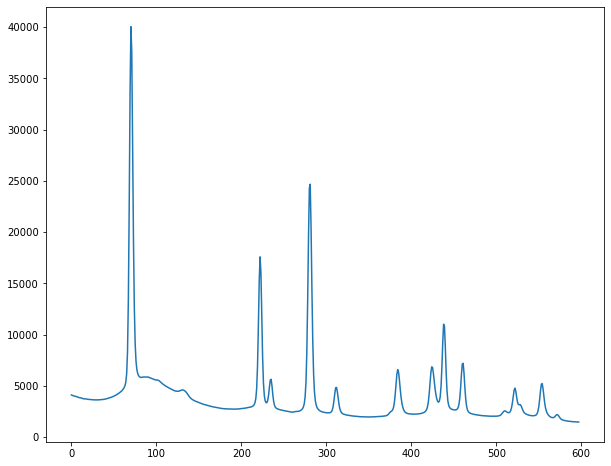

In [279]:
plt.plot(patterns[0])

In [325]:
def color_peaks(fit_list, pattern, imin = 10, fwhm_max = 20, area_min = 1000):
    """
    Return an array of 1s in indices corresponding to a peak (+- HWHM) and 0s elsewhere. 
    
    fit_list: list of derived curve fit parameters.
    
    Only the first curve in each group of fits is counted.
    """
    res = np.zeros_like(pattern)
    for peaks in fit_list:
        primary = peaks['curve 0']
        qwhm = int((primary['FWHM'] + 1) / 3)
        i0 = int(primary['x0'] + .5)
        if i0 >= imin and primary['FWHM'] <= fwhm_max:# and primary['area'] > area_min:
            res[i0 - qwhm: i0 + qwhm] = 1
    return res

In [328]:
def color_peaks_2d(fitlists, patterns, **kwargs):
    return np.vstack([color_peaks(fitlist, patterns[i], **kwargs) for i, fitlist in enumerate(fitlists)])

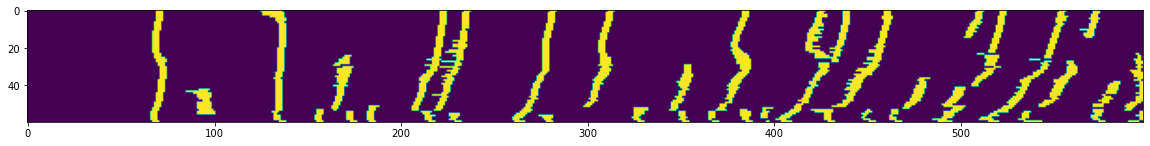

In [399]:
plt.imshow(color_peaks_2d(fsub_stop_2d[1], patterns))

In [326]:
peakmask = np.vstack([color_peaks(fitlist, patterns[i], area_min = 1) for i, fitlist in enumerate(fsub_stop_2d[1])])

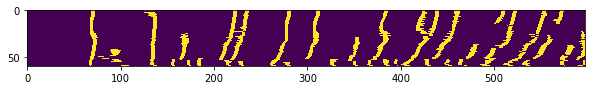

In [327]:
plt.imshow(peakmask, interpolation = 'none')

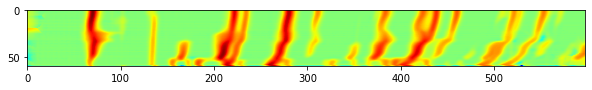

In [334]:
plt.imshow(np.log(1 + fast_q - fast_q.min()), cmap = 'jet')

In [337]:
from xrdc import featurization as feat

In [356]:
reload(feat)

<module 'xrdc.featurization' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/featurization.py'>

In [360]:
def peakfit_featurize(patterns_pp, fitlists):
    #patterns_pp = gf(patterns, (1, 1.7))
    labeled, feature_masks, activations, norm_, activations_n1 = feat.get_ridge_features(
        patterns_pp,
       smooth_ax1 = 'FWHM', smooth_ax0 = 2, threshold_percentile = 50, thicken = True, size_thresh = 5, bgsub=False,
        log_scale_features = False, fwhm_finder=feat.fwhm_finder, do_flood_thicken = False, max_size_flood = 20,
        thicken_ax0 = 0, thicken_ax1 = 0, flood_threshold=.95, smooth_factor_ax1 = .125, fitlists = fitlists)
    return labeled, feature_masks, activations, norm_, activations_n1

In [407]:
import matplotlib
matplotlib.rcParams.update({'font.size': 15})

using fitlists
Peak at 70, start iteration with error = 0.35307677296466045
Peak at 70, iteration 0: error = 0.34471987497825074
Peak at 69, start iteration with error = 0.13928933038224836
Peak at 69, iteration 0: error = 0.15089892018003775
Peak at 277, start iteration with error = 0.13077241822788968
Peak at 277, iteration 0: error = 0.1147428682989114
Peak at 277, start iteration with error = 0.22466927956503574
Peak at 277, iteration 0: error = 0.2477222202503471
Peak at 211, start iteration with error = 0.2108859353270414
Peak at 211, iteration 0: error = 0.2576948623230084
Peak at 208, start iteration with error = 0.222405073757889
Peak at 208, iteration 0: error = 0.23828123290960712
using fitlists
38
0.6743337289016471


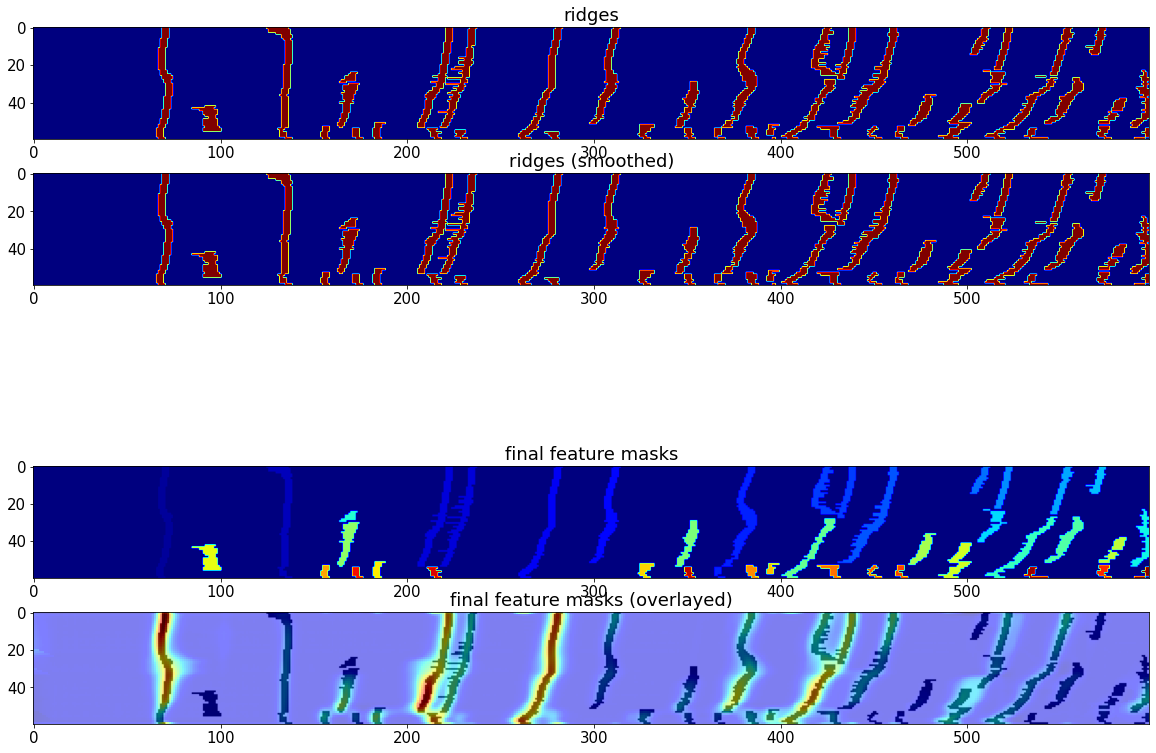

In [408]:
patterns_pp = fast_q - fast_q.min()
patterns_pp /= patterns_pp.mean()
fitlists = fsub_stop_2d[1]
labeled, feature_masks, activations, norm_, activations_n1 = peakfit_featurize(patterns_pp, fitlists)

In [362]:
patterns_pp.max()

30.3990574204235

{'linkage': 'ward', 'affinity': 'euclidean'}



    Similarity type: Cosine

    Scaling: linear
    
    Clustering type: agglom
    
    Linkage: ward
    

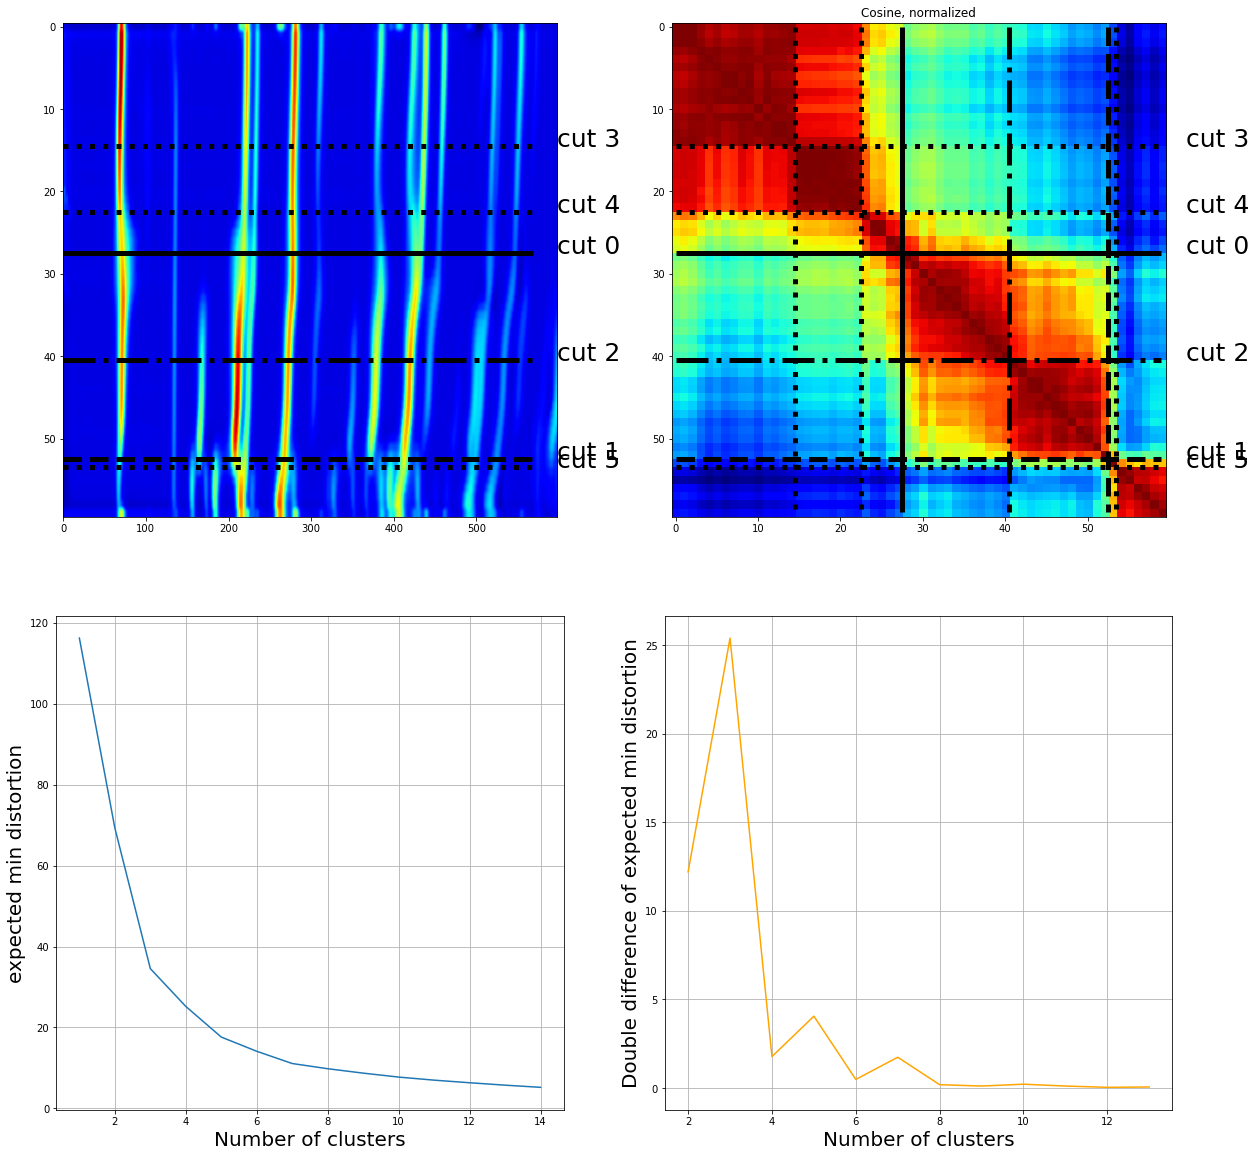

In [401]:
results = []

simtype = 'Cosine'
scaling = 'linear'
linkage = 'ward'
ctype = 'agglom'

feature_csims1, o_cuts = feat.sims_with_boundaries(patterns_pp, activations_n1, activations_n1, n = 7, simtype = simtype, extra_label='',
                    ctype = ctype, linkage = linkage, affinity = 'euclidean')
results.append({'simtype': simtype, 'scaling': scaling, 'linkage': linkage, 'ctype': ctype, 'cut_coords': o_cuts})
feat.printinfo(simtype, scaling, linkage, ctype)

In [ ]:
def place_peak

In [264]:
[len(elt) for elt in fsub_stop_2d[1]]

[2,
 3,
 3,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1]

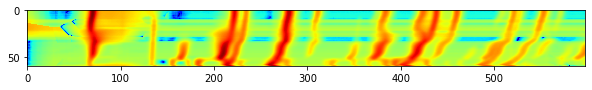

In [221]:
plt.imshow(np.log(1 + fsub_stop_2d), cmap = 'jet')

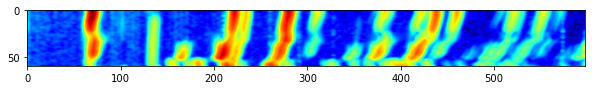

In [207]:
plt.imshow(np.log(sep.reference_bgsub(patterns) + 1), cmap = 'jet')

In [155]:
reload(sep)

<module 'xrdc.source_separation' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/source_separation.py'>

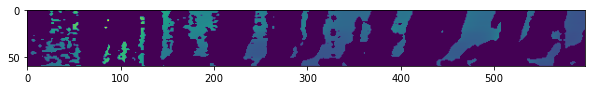

In [118]:
plt.imshow(sep.get_bgmask(patterns, 25) * patterns)

(2, 60, 598)
(2, 60, 598)


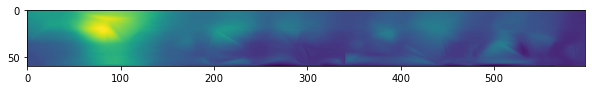

In [162]:
plt.imshow(sep.get_background(patterns, threshold = 25, smooth = 0, method = 'cloughtocher'))

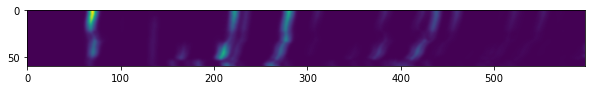

In [226]:
plt.imshow(sep.reference_bgsub(patterns))

In [231]:
reload(sep)
reload(sep.fourier)
reload(sep)

<module 'xrdc.source_separation' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/source_separation.py'>

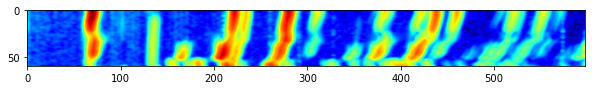

In [234]:
plt.imshow(np.log(1 + sep.reference_bgsub(patterns)), cmap = 'jet')

## 3d dataset

In [364]:
from xrdc.datasets import d3d

patterns = m3d = d3d.get_data()
arr2d = patterns[:, :, 200]

Loading Data from: /Users/ollie/Documents/SLAC/xrd_clustering/notebooks/../../TiNiSn_500C-20190604T152446Z-001/TiNiSn_500C/
Data Loaded Succesfully
(177, 800)


In [365]:
slow_q, fast_q, slow_T, fast_T = sep.separate_signal(patterns, cutoff = .25,  threshold = 50, smooth_q = 1.7)

In [370]:
reload(hitp)

ModuleNotFoundError: spec not found for the module 'dataproc.operations.hitp'

> /Users/ollie/anaconda3/lib/python3.7/importlib/__init__.py(168)reload()
    166         spec = module.__spec__ = _bootstrap._find_spec(name, pkgpath, target)
    167         if spec is None:
--> 168             raise ModuleNotFoundError(f"spec not found for the module {name!r}", name=name)
    169         _bootstrap._exec(spec, module)
    170         # The module may have replaced itself in sys.modules!

ipdb> c


In [371]:
from dataproc.operations import hitp

In [372]:
patterns.shape

(15, 15, 800)